In [1]:
import torch
# @title device
def get_device():
  if torch.cuda.is_available():
      device = torch.device("cuda")
      print("CUDA is available. Using GPU.")
  else:
      device = torch.device("cpu")
      print("CUDA is not available. Using CPU.")
  return device
device=get_device()

CUDA is available. Using GPU.


# Preprocessing

In [2]:
# @title code
from os import makedirs
import torch
import math
import os
import string
import shutil
import subprocess
import pandas as pd
import numpy as np
import pandas as pd

def get_x(value):

    if isinstance(value, str):
        return float(value.split("/")[0])
    elif isinstance(value, float):
        return value

def get_y(value):

    if isinstance(value, str):
        return float(value.split("/")[1])
    elif isinstance(value, float):
        return value

def read_dataframe(name):
  if not os.path.exists(name+".pkl"):
    print("reading dataframe: "+name+".xlsx")
    df=pd.read_excel(name+".xlsx")
    df.to_pickle(name+".pkl")
  else:
    print("using already read daframe")

def get_vocab(poses,vocab):
  for pos in poses:
    if pos not in vocab and not any(isinstance(n, float) and math.isnan(n) for n in pos):
        vocab[pos]=len(vocab)+1
  return vocab

def get_fix_time_encoding(df):

  df['month_sin'] = np.sin(2 * np.pi * df["start time"].dt.month / 12)
  df['month_cos'] = np.cos(2 * np.pi * df["start time"].dt.month / 12)

  df['day_sin'] = np.sin(2 * np.pi * df["start time"].dt.day / 31)
  df['day_cos'] = np.cos(2 * np.pi * df["start time"].dt.day / 31)

  df['hour_sin'] = np.sin(2 * np.pi * df["start time"].dt.hour / 24)
  df['hour_cos'] = np.cos(2 * np.pi * df["start time"].dt.hour / 24)

  df['minute_sin'] = np.sin(2 * np.pi * df["start time"].dt.minute / 60)
  df['minute_cos'] = np.cos(2 * np.pi * df["start time"].dt.minute / 60)

  df['second_sin'] = np.sin(2 * np.pi * df["start time"].dt.second / 60)
  df['second_cos'] = np.cos(2 * np.pi * df["start time"].dt.second / 60)
def get_time_data(df):
  df['month'] =  df["start time"].dt.month
  df['day'] =  df["start time"].dt.day
  df['hour'] =  df["start time"].dt.hour
  df['minute'] = df["start time"].dt.minute
  df['second'] = df["start time"].dt.second
  return df


def tokenize_pos(pos,vocab):

  if math.isnan(pos[0]) and math.isnan(pos[1]):
    return len(vocab)
  else:
    return vocab[pos]

def get_coordinates(df,input_position,full_dataset):

  if full_dataset:
    df['x'] = df['latitude']
    df['y'] = df['longitude']
  else:
    df['x'] = df['location(latitude/lontitude)'].apply(get_x)
    df['y'] = df['location(latitude/lontitude)'].apply(get_y)

  if input_position:
    df['x_normalised']=(df['x']-df['x'].mean())/(df['x'].std())
    df['y_normalised']=(df['y']-df['y'].mean())/df['y'].std()

  return df

def get_joined_coordinates(df):
  df['pos']= list(zip(df['x'],df['y']))
  poses=df['pos'].unique()
  return poses

def get_col_to_keep_and_drop(fixed_time_encoding,input_position,full_dataset):
  col_to_drop_in_df=['date', 'end time','pos']
  col_to_drop_in_dict=['x','y', 'time_to_end', 'time_to_next','start time', 'user id']
  col_to_add_to_dict=[]
  col_in_input=[]
  if not full_dataset:
    col_to_drop_in_df+=['location(latitude/lontitude)']
  else:
    col_to_drop_in_df+=['latitude','longitude']
  if fixed_time_encoding:
    col_to_drop_in_df+=[]
    col_to_drop_in_dict+=['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos']
    col_in_input+=['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos']
  else:
    col_to_add_to_dict+=['month','day','hour','minute','second']
  if input_position:
    col_to_drop_in_dict += ['x_normalised', 'y_normalised']
    col_in_input+=['x_normalised', 'y_normalised']
  return col_to_drop_in_df,col_to_drop_in_dict,col_in_input,col_to_add_to_dict

def replace_nan_with_previous_values(dict_user):
  index_start_sequence=0
  while index_start_sequence<dict_user["input"].shape[0] and dict_user["input"][index_start_sequence,-2:].isnan().any():
    index_start_sequence+=1
  for col in dict_user:
    dict_user[col]=dict_user[col][index_start_sequence:]
  for i in range(1,dict_user["input"].shape[0]):
    if dict_user["input"][i,-2:].isnan().any():
      dict_user["input"][i,-2:]=dict_user["input"][i-1,-2:]
  return dict_user



def process_user_data(df_user,vocab,col_in_input,col_to_drop_in_dict,col_to_add_to_dict,with_repeated_connections,drop_nan):
  #get the time to next connection
  df_user["time_to_next"] =  df_user["start time"].diff(-1).dt.total_seconds()
  dict_user=df_user.to_dict('list')
  #create input
  dict_user["pos_id"],dict_user["pos_id_target"]=torch.tensor(dict_user["pos_id"][:-1]),torch.tensor(dict_user["pos_id"][1:])

  if col_in_input:
    dict_user["input"]=torch.tensor([dict_user[col] for col in col_in_input]).T
    dict_user["input"]=dict_user["input"][:-1]
  if col_to_add_to_dict:
    for col in col_to_add_to_dict:
      dict_user[col]=torch.tensor(dict_user[col])
      dict_user[col]=dict_user[col][:-1]

  dict_user["time_target"]=torch.tensor([dict_user["time_to_end"],dict_user["time_to_next"]]).T
  dict_user["time_target"]=dict_user["time_target"][:-1]
  if not drop_nan and dict_user["input"][:,-2:].isnan().any():
    dict_user=replace_nan_with_previous_values(dict_user)
  for e in col_to_drop_in_dict:
    dict_user.pop(e)

  if not with_repeated_connections:
    dict_user=combine_repeated_connections_in_sequence_user(dict_user)
    dict_user=delete_end_of_sequence_repeated_connections(dict_user)
  return dict_user

def delete_end_of_sequence_repeated_connections(dict_user):
  if dict_user['pos_id'][-1]==dict_user["pos_id_target"][-1]:
    for key in dict_user:
      dict_user[key]=dict_user[key][:-1]
  return dict_user


def combine_repeated_connections_in_sequence_user(dict_user):
  index=0
  while index < len(dict_user["pos_id"])-1:
    if dict_user["pos_id"][index]==dict_user["pos_id_target"][index]:
      dict_user["pos_id_target"][index]=dict_user["pos_id_target"][index+1]
      dict_user["time_target"][index]=dict_user["time_target"][index+1]
      for key in dict_user:
        dict_user[key]=torch.cat((dict_user[key][:index+1],dict_user[key][index+2:]))
    else:
      index+=1


  return dict_user


def normalize_output(list_users):
  #get means and stds
  time_targets=torch.cat([dict_user["time_target"] for dict_user in list_users],dim=0)
  time_targets_mean=time_targets.mean(dim=0)
  time_targets_std=time_targets.std(dim=0)
  #normalize
  for i in range(len(list_users)):
    list_users[i]["time_target"]=(list_users[i]["time_target"]-time_targets_mean)/time_targets_std
  return list_users

def keep_sequence(df_user,min_sequence_size,drop_nan):

  return len(df_user)>=min_sequence_size and (not drop_nan or not df_user['x'].isnull().values.any()) and  (drop_nan or not df['latitude'].isnull().sum()==len(df['latitude']))

def process_dataframe(name,vocab,fixed_time_encoding,input_position,full_dataset,with_repeated_connections,min_sequence_size,drop_nan,format=".pkl"):
  df= pd.read_pickle(name+format)
  df=df.sort_values('start time')
  df=df.drop(['month'],axis=1)

  df=get_coordinates(df,input_position,full_dataset)

  poses=get_joined_coordinates(df)
  vocab=get_vocab(poses,vocab)
  df['pos_id'] = df['pos'].apply(lambda pos: tokenize_pos(pos,vocab))

  df['time_to_end']=df['end time']-df['start time']
  df['time_to_end']=df['time_to_end'].dt.total_seconds()
  if fixed_time_encoding:
    df=get_fix_time_encoding(df)
  else:
    df=get_time_data(df)

  col_to_drop_in_df,col_to_drop_in_dict,col_in_input,col_to_add_to_dict=get_col_to_keep_and_drop(fixed_time_encoding,input_position,full_dataset)
  df=df.drop(col_to_drop_in_df, axis=1)

  df_user_group = df.groupby('user id')
  list_users=[]
  for user, df_user in df_user_group:
    if keep_sequence(df_user,min_sequence_size,drop_nan):
        prossessed_user_data=process_user_data(df_user,vocab,col_in_input,col_to_drop_in_dict,col_to_add_to_dict,with_repeated_connections,drop_nan)
        if prossessed_user_data["pos_id"].shape[0]>=min_sequence_size-1:
          list_users.append(prossessed_user_data)
  list_users=normalize_output(list_users)

  return list_users,vocab

def runcmd(cmd, verbose = False, *args, **kwargs):

    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    pass

def get_raw_data(directory,src_directory,download_raw_data):
  if not download_raw_data:
    shutil.copytree(src_directory,directory)#telecomDataset6mont
  else:
    runcmd('wget http://sguangwang.com/dataset/telecom.zip', verbose = False)
    runcmd('unzip /content/telecom.zip')

def get_processed_dataset(load_dataset_path):
  saved_list_user_path = os.path.join(load_dataset_path,"list_users")
  saved_vocab_path = os.path.join(load_dataset_path,"vocab")
  print("loading already preprocessed data: ")
  print(saved_list_user_path)
  print(saved_vocab_path)
  list_users=torch.load(saved_list_user_path)
  vocab=torch.load(saved_vocab_path)
  return list_users,vocab

def get_and_process_raw_data(src_directory_raw_data,directory_raw_data,fixed_time_encoding,input_position,full_dataset,download_raw_data,with_repeated_connections,min_sequence_size,drop_nan):
  list_users=[]
  vocab={}
  if not os.path.exists(directory_raw_data):
    print('getting raw data at: '+src_directory_raw_data)
    get_raw_data(directory_raw_data,src_directory_raw_data,download_raw_data)
  for name in os.listdir(directory_raw_data):
    if not name.endswith(".pkl"):
      complete_name=os.path.join(directory_raw_data,".".join(name.split(".")[:-1]))
      print("processing dataframe: "+complete_name)
      read_dataframe(complete_name)
      new_list_users,vocab= process_dataframe(complete_name,vocab,fixed_time_encoding=fixed_time_encoding,input_position=input_position,full_dataset=full_dataset,with_repeated_connections=with_repeated_connections,min_sequence_size=min_sequence_size,drop_nan=drop_nan)
      list_users+=new_list_users
  return list_users,vocab

def split_long_sequences(list_users,max_sequence_length):
  new_list_users=[]
  for i in range(len(list_users)):
    seq_length=list_users[i]["input"].shape[0]
    if seq_length>=max_sequence_length:
      nb_of_seq=seq_length//max_sequence_length
      rest=seq_length%max_sequence_length
      list_splitted_seq=nb_of_seq*[{}]
      rest_splitted={}
      for key in list_users[i]:
        for j in range(nb_of_seq):
          list_splitted_seq[j][key]=list_users[i][key][max_sequence_length*j:max_sequence_length*(j+1)]
        if rest>2:
          rest_splitted[key]= list_users[i][key][-rest:]
      new_list_users=new_list_users+list_splitted_seq
      if len(rest_splitted)>0:
        new_list_users+=[rest_splitted]
    else:
      new_list_users.append(list_users[i])

  return new_list_users



def save_processed_data(list_users,vocab,path_to_save_dataset):
    print("creating directory: "+path_to_save_dataset)
    os.makedirs(path_to_save_dataset,exist_ok=True)
    print("saving processed data at: ")
    save_list_user_path = os.path.join(path_to_save_dataset,"list_users")
    save_vocab_path = os.path.join(path_to_save_dataset,"vocab")
    print(save_list_user_path)
    print(save_vocab_path)
    torch.save(list_users,save_list_user_path)
    torch.save(vocab,save_vocab_path)

def get_processed_data(src_directory_raw_data,directory_raw_data,fixed_time_encoding,input_position,full_dataset,spliting_long_sequences,with_repeated_connections,max_sequence_length=100,min_sequence_size=1,drop_nan=True,save=False,path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month",process_raw_data=True,download_raw_data=False,processed_dataset_path="/content/drive/MyDrive/telecomDataset6month"):
  if not process_raw_data:
    list_users,vocab = get_processed_dataset(processed_dataset_path)
  else:
    list_users,vocab=get_and_process_raw_data(src_directory_raw_data,directory_raw_data,fixed_time_encoding,input_position,full_dataset,download_raw_data,with_repeated_connections,min_sequence_size=min_sequence_size,drop_nan=drop_nan)
  if spliting_long_sequences:
    print("spliting sequences longuer than : "+str(max_sequence_length)+ " steps")
    list_users=split_long_sequences(list_users,max_sequence_length)
  if save:
    save_processed_data(list_users,vocab,path_to_save_dataset)
  return list_users,vocab

## preprocessing 1: replacing missing values

In [ ]:
list_users,vocab=get_processed_data(src_directory_raw_data=None,
                                    directory_raw_data='/content/smallDataset',
                                    fixed_time_encoding=False,
                                    input_position=True,
                                    full_dataset=True,
                                    spliting_long_sequences=False,
                                    with_repeated_connections=True,
                                    max_sequence_length=100,
                                    min_sequence_size=2,
                                    drop_nan=False,
                                    save=False,
                                    path_to_save_dataset=None,
                                    process_raw_data=False,
                                    download_raw_data=False,
                                    processed_dataset_path=None,)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
          4.3836e-02,  4.3836e-02,  4.3836e-02,  4.3836e-02,  4.3836e-02,
          7.6887e-02,  1.6537e-01,  1.6755e-01,  1.6755e-01,  1.6755e-01,
          1.6537e-01,  1.6755e-01,  1.6755e-01,  1.6755e-01,  1.6755e-01,
          1.4933e-01,  4.3836e-02,  4.3836e-02,  4.3836e-02,  4.7133e-02,
          4.7133e-02,  4.7133e-02,  4.3836e-02,  4.3836e-02,  3.9823e-02,
          4.3714e-02,  4.3836e-02,  4.5566e-02,  4.3714e-02,  1.6537e-01,
          1.6537e-01,  1.6755e-01,  1.6755e-01,  1.6537e-01,  1.6920e-01,
          1.6755e-01,  1.6755e-01,  1.6755e-01,  1.6755e-01,  1.6755e-01,
          1.6755e-01,  1.6755e-01,  1.6755e-01,  1.6537e-01,  6.0520e-02,
          6.0520e-02,  4.3836e-02,  4.3836e-02,  4.3836e-02,  4.3836e-02,
          5.0682e-02,  5.0682e-02,  4.3714e-02,  3.9823e-02,  3.9823e-02,
          5.9264e-02,  4.3836e-02,  4.3836e-02,  4.3836e-02,  4.3836e-02,
          5.0682e-02,  1.6755e-01,

In [ ]:
pos_id_concat=torch.cat([user['pos_id'] for user in list_users])


torch.Size([595800])

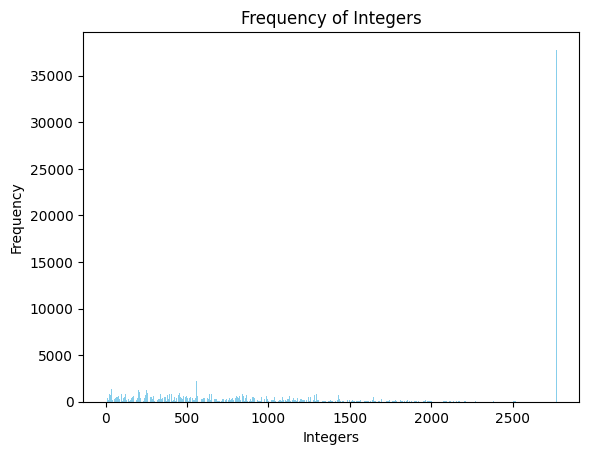

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

data = pos_id_concat.tolist()

# Count the frequency of each integer
counter = Counter(data)

# Extracting data for plotting
integers = list(counter.keys())
frequencies = list(counter.values())

# Creating the bar chart
plt.bar(integers, frequencies, color='skyblue')

# Adding labels and title
plt.xlabel('Integers')
plt.ylabel('Frequency')
plt.title('Frequency of Integers')

# Displaying the plot
plt.show()

## prepocessing 2 : dropping missing values

### **no split**: For LSTM

In [ ]:
list_users,vocab=get_processed_data(src_directory_raw_data="/content/drive/MyDrive/Shanghai-Telcome-Six-Months-DataSet",
                                    directory_raw_data='/content/dataset-telecom-6month',
                                    fixed_time_encoding=False,
                                    input_position=True,
                                    full_dataset=True,
                                    spliting_long_sequences=False,
                                    with_repeated_connections=True,
                                    max_sequence_length=None,
                                    min_sequence_size=2,
                                    drop_nan=True,
                                    save=True,
                                    path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month_without_nan_with_repeat_no_split",
                                    process_raw_data=True,
                                    download_raw_data=False,
                                    processed_dataset_path="/content/drive/MyDrive/telecomDataset6month_without_nan_with_repeat_no_split",)

getting raw data at: /content/drive/MyDrive/Shanghai-Telcome-Six-Months-DataSet
processing dataframe: /content/dataset-telecom-6month/data_11.1~11.15
reading dataframe: /content/dataset-telecom-6month/data_11.1~11.15.xlsx
processing dataframe: /content/dataset-telecom-6month/data_7.16~7.31
reading dataframe: /content/dataset-telecom-6month/data_7.16~7.31.xlsx
processing dataframe: /content/dataset-telecom-6month/data_6.1~6.15
reading dataframe: /content/dataset-telecom-6month/data_6.1~6.15.xlsx
processing dataframe: /content/dataset-telecom-6month/data_9.1~9.15
reading dataframe: /content/dataset-telecom-6month/data_9.1~9.15.xlsx
processing dataframe: /content/dataset-telecom-6month/data_6.16~6.30
reading dataframe: /content/dataset-telecom-6month/data_6.16~6.30.xlsx
processing dataframe: /content/dataset-telecom-6month/data_10.1~10.15
reading dataframe: /content/dataset-telecom-6month/data_10.1~10.15.xlsx
processing dataframe: /content/dataset-telecom-6month/data_11.16~11.30
reading d

### **split**: For Transformer

In [ ]:
list_users,vocab=get_processed_data(src_directory_raw_data="/content/drive/MyDrive/Shanghai-Telcome-Six-Months-DataSet",
                                    directory_raw_data='/content/dataset-telecom-6month',
                                    fixed_time_encoding=False,
                                    input_position=True,
                                    full_dataset=True,
                                    spliting_long_sequences=True,
                                    with_repeated_connections=True,
                                    max_sequence_length=100,
                                    min_sequence_size=2,
                                    drop_nan=True,
                                    save=True,
                                    path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month_without_nan_with_repeat_split_100",
                                    process_raw_data=True,
                                    download_raw_data=False,
                                    processed_dataset_path="/content/drive/MyDrive/telecomDataset6month_without_nan_with_repeat_split_100",)

processing dataframe: /content/dataset-telecom-6month/data_11.1~11.15
using already read daframe
processing dataframe: /content/dataset-telecom-6month/data_7.16~7.31
using already read daframe
processing dataframe: /content/dataset-telecom-6month/data_6.1~6.15
using already read daframe
processing dataframe: /content/dataset-telecom-6month/data_9.1~9.15
using already read daframe
processing dataframe: /content/dataset-telecom-6month/data_6.16~6.30
using already read daframe
processing dataframe: /content/dataset-telecom-6month/data_10.1~10.15
using already read daframe
processing dataframe: /content/dataset-telecom-6month/data_11.16~11.30
using already read daframe
processing dataframe: /content/dataset-telecom-6month/data_8.1~8.15
using already read daframe
processing dataframe: /content/dataset-telecom-6month/data_9.16~9.30
using already read daframe
processing dataframe: /content/dataset-telecom-6month/data_7.1~7.15
using already read daframe
processing dataframe: /content/dataset-t

In [ ]:
for user in list_users:
  for key in user:
    if user[key].shape[0]>100:
      print(key,len(user[key]))

## Preprocessing 3: merge repetitions

In [3]:
list_users,vocab=get_processed_data(src_directory_raw_data="/content",
                                    directory_raw_data='/content/dataset-telecom-6month',
                                    fixed_time_encoding=False,
                                    input_position=True,
                                    full_dataset=True,
                                    spliting_long_sequences=False,
                                    with_repeated_connections=False,
                                    max_sequence_length=100,
                                    min_sequence_size=2,
                                    drop_nan=False,
                                    save=False,
                                    path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3",
                                    process_raw_data=False,
                                    download_raw_data=False,
                                    processed_dataset_path="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3",)

loading already preprocessed data: 
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/list_users
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/vocab


## Analysis of sequence Repartition by length

21.458622016936104
21.458622016936104 25.618203688507787 100 1


(array([2448., 1909., 1118., 1149.,  800.,  753.,  626.,  599.,  516.,
         471.,  427.,  444.,  381.,  369.,  317.,  337.,  267.,  254.,
         239.,  239.,  237.,  234.,  222.,  205.,  206.,  171.,  189.,
         178.,  178.,  173.,  147.,  165.,  130.,  128.,  132.,  133.,
         134.,  118.,  122.,  109.,  130.,  109.,  118.,  122.,  103.,
         116.,   94.,   79.,   77.,   70.,   80.,   74.,   79.,   70.,
          82.,   74.,   69.,   61.,   77.,   64.,   69.,   54.,   65.,
          72.,   59.,   47.,   41.,   43.,   49.,   33.,   46.,   40.,
          49.,   44.,   45.,   34.,   33.,   30.,   31.,   30.,   24.,
          32.,   25.,   25.,   21.,   29.,   37.,   25.,   22.,   31.,
          19.,   26.,   21.,   21.,   21.,   23.,   17.,   12.,   21.,
         696.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  2

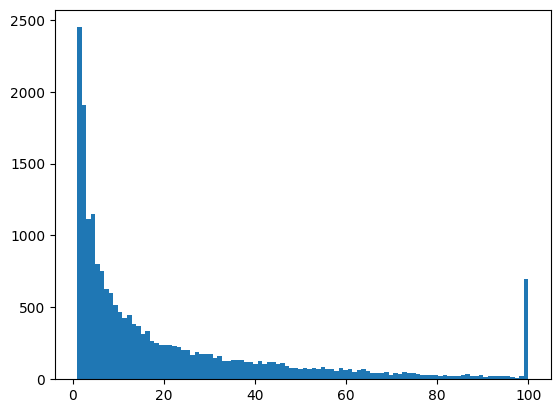

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
sum_len=0
len_list=[]
for user in list_users:
  len_list.append(len(user['pos_id']))
  sum_len+=len(user['pos_id'])
print(sum_len/len(list_users))
len_array=np.array(len_list)
print(len_array.mean(),len_array.std(),len_array.max(),len_array.min())
plt.hist(len_array,100)

21.458622016936104
21.458622016936104 25.618203688507787 100 1


(array([2448., 1909., 1118., 1149.,  800.,  753.,  626.,  599.,  516.,
         471.,  427.,  444.,  381.,  369.,  317.,  337.,  267.,  254.,
         239.,  239.,  237.,  234.,  222.,  205.,  206.,  171.,  189.,
         178.,  178.,  173.,  147.,  165.,  130.,  128.,  132.,  133.,
         134.,  118.,  122.,  109.,  130.,  109.,  118.,  122.,  103.,
         116.,   94.,   79.,   77.,   70.,   80.,   74.,   79.,   70.,
          82.,   74.,   69.,   61.,   77.,   64.,   69.,   54.,   65.,
          72.,   59.,   47.,   41.,   43.,   49.,   33.,   46.,   40.,
          49.,   44.,   45.,   34.,   33.,   30.,   31.,   30.,   24.,
          32.,   25.,   25.,   21.,   29.,   37.,   25.,   22.,   31.,
          19.,   26.,   21.,   21.,   21.,   23.,   17.,   12.,   21.,
         696.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  2

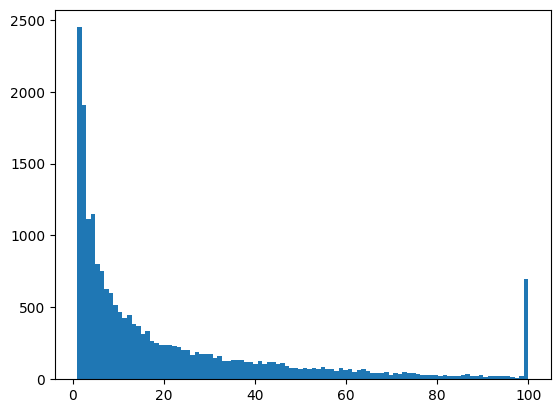

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
sum_len=0
len_list=[]
for user in list_users:
  len_list.append(len(user['pos_id']))
  sum_len+=len(user['pos_id'])
print(sum_len/len(list_users))
len_array=np.array(len_list)
print(len_array.mean(),len_array.std(),len_array.max(),len_array.min())
plt.hist(len_array,100)

21.458622016936104
21.458622016936104 25.618203688507787 100 1


(array([2448., 1909., 1118., 1149.,  800.,  753.,  626.,  599.,  516.,
         471.,  427.,  444.,  381.,  369.,  317.,  337.,  267.,  254.,
         239.,  239.,  237.,  234.,  222.,  205.,  206.,  171.,  189.,
         178.,  178.,  173.,  147.,  165.,  130.,  128.,  132.,  133.,
         134.,  118.,  122.,  109.,  130.,  109.,  118.,  122.,  103.,
         116.,   94.,   79.,   77.,   70.,   80.,   74.,   79.,   70.,
          82.,   74.,   69.,   61.,   77.,   64.,   69.,   54.,   65.,
          72.,   59.,   47.,   41.,   43.,   49.,   33.,   46.,   40.,
          49.,   44.,   45.,   34.,   33.,   30.,   31.,   30.,   24.,
          32.,   25.,   25.,   21.,   29.,   37.,   25.,   22.,   31.,
          19.,   26.,   21.,   21.,   21.,   23.,   17.,   12.,   21.,
         696.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  2

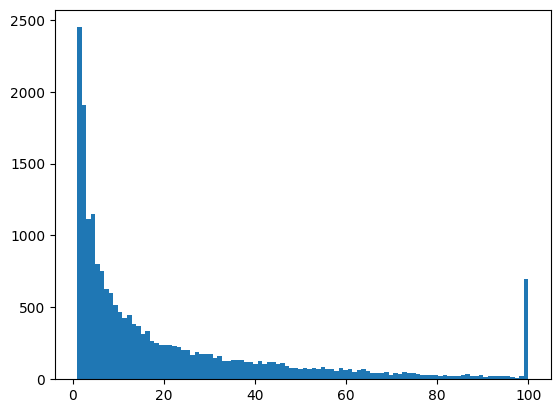

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
sum_len=0
len_list=[]
for user in list_users:
  len_list.append(len(user['pos_id']))
  sum_len+=len(user['pos_id'])
print(sum_len/len(list_users))
len_array=np.array(len_list)
print(len_array.mean(),len_array.std(),len_array.max(),len_array.min())
plt.hist(len_array,100)

In [ ]:
nb_repeated_end_of_sequence=0
len_1=0
for user in list_users:
  if len(user['pos_id'])==1:
    len_1+=1
    if user['pos_id'][-1]==user['pos_id_target'][-1]:
      nb_repeated_end_of_sequence+=1
print(nb_repeated_end_of_sequence/len_1)

0.0


In [ ]:
nb_repeated_end_of_sequence=0
len_1=0
for user in list_users:
  if len(user['pos_id'])==1:
    len_1+=1
    if user['pos_id'][-1]==user['pos_id_target'][-1]:
      nb_repeated_end_of_sequence+=1
print(nb_repeated_end_of_sequence/len_1)

0.0


# Dataset

## Reproducibility seed

In [4]:
import hashlib
import string
import random
def get_reproducible_seeds(name="ProjectLong",nb_seeds=100):
    # Calculate SHA-256 hash
    sha256_hash = hashlib.sha256(name.encode()).hexdigest()
    # Define character sets
    digits = string.digits
    # Use the hash to seed the random number generator
    hash_as_int = int(sha256_hash, 16)
    random.seed(hash_as_int)
    # Generate a random list of seed of desired length
    reproducibility_seeds = [random.randint(0,10000) for _ in range(nb_seeds)]

    return reproducibility_seeds

In [5]:
reproducibility_seed=get_reproducible_seeds()[0]

## Dataset

In [6]:
from torch.utils.data import Dataset, DataLoader
class VariableLengthDatasetWithPosID(Dataset):
    def __init__(self, time_series,curriculum_learning, transform=None):
        self.times_series=time_series
        self.curriculum_learning=curriculum_learning
    def __len__(self):
        return len(self.times_series)
    def __getitem__(self, idx):
        user_dict=self.times_series[idx]
        if self.curriculum_learning:
          user_dict["idx"]=idx
        return  user_dict

def create_dataset(list_users,curriculum_learning,split=[0.8,0.1,0.1]):
  dataset=VariableLengthDatasetWithPosID(list_users,curriculum_learning)
  generator = torch.Generator().manual_seed(reproducibility_seed)
  dataset_list=torch.utils.data.random_split(dataset,[0.8,0.1,0.1],generator)

  return dataset_list,len(dataset)


## Dataloader

In [7]:
def collate_fn_padd(batch_dict):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''


    dict_batch={key: [d[key] for d in batch_dict] for key in batch_dict[0]}
    if "idx" in dict_batch:
      dict_batch["idx"]=torch.tensor(dict_batch["idx"])
    dict_batch["lengths"] = torch.tensor([ user["input"].shape[0] for user in batch_dict ])
    if "input" in dict_batch:
      dict_batch["input"] = torch.nn.utils.rnn.pad_sequence(dict_batch["input"],batch_first=True,padding_value=0)
    dict_batch["month"] = torch.nn.utils.rnn.pad_sequence(dict_batch["month"],batch_first=True,padding_value=0)
    dict_batch["day"] = torch.nn.utils.rnn.pad_sequence(dict_batch["day"],batch_first=True,padding_value=0)
    dict_batch["hour"] = torch.nn.utils.rnn.pad_sequence(dict_batch["hour"],batch_first=True,padding_value=24)
    dict_batch["minute"] = torch.nn.utils.rnn.pad_sequence(dict_batch["minute"],batch_first=True,padding_value=60)
    dict_batch["second"] = torch.nn.utils.rnn.pad_sequence(dict_batch["second"],batch_first=True,padding_value=60)

    dict_batch["time_target"] = torch.nn.utils.rnn.pad_sequence(dict_batch["time_target"],batch_first=True,padding_value=-1)
    dict_batch["pos_id"] = torch.nn.utils.rnn.pad_sequence(dict_batch["pos_id"],batch_first=True,padding_value=len(vocab))
    dict_batch["pos_id_target"] = torch.nn.utils.rnn.pad_sequence(dict_batch["pos_id_target"],batch_first=True,padding_value=len(vocab))
    #print(dict_batch["input"])
    return dict_batch

## Instanciate

In [8]:
dataset_list,len_dataset=create_dataset(list_users,curriculum_learning=True)
train_dataset=dataset_list[0]
valid_dataset=dataset_list[1]
test_dataset=dataset_list[2]
train_dataloader=DataLoader(train_dataset,batch_size=128,collate_fn=collate_fn_padd,shuffle=True)
valid_dataloader=DataLoader(valid_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)
test_dataloader=DataLoader(test_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)

# Model

## Transformer Encoder followed by LSTM

### transformer

In [9]:
def get_mask(bath_size,sequence_length,lengths,device):
  mask=torch.zeros(bath_size,sequence_length).to(device)
  for i, length in enumerate(lengths):
    mask[i,length:]=float('-inf')
  return mask

#### Positional encoding

In [10]:
from torch import nn, Tensor
class VanillaPositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = (x.transpose(0,1) + self.pe[:x.transpose(0,1).size(0)]).transpose(0,1)
        return self.dropout(x)

In [11]:
class LearnablePositionalEncoding(nn.Module):

    def __init__(self,d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.positional_embedding=nn.Embedding(num_embeddings=max_len,embedding_dim= d_model)
    @property
    def device(self):
      return next(self.parameters()).device
    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size,seq_len, embedding_dim]``
        """
        x += self.positional_embedding(torch.arange(0,x.shape[1]).to(self.device))
        return self.dropout(x)

In [12]:
def get_PositionalEncoding(d_model: int, dropout: float = 0.1, max_len: int = 2000, learnable=False):
  if learnable:
    return LearnablePositionalEncoding(d_model, dropout, max_len)
  else:
    return VanillaPositionalEncoding(d_model, dropout, max_len)

#### model

In [13]:
class Encoder_Decoder_Transformer(nn.Module):
    def __init__(self,d_model,num_layers=3,nhead=10,dropout=0.1,batch_first=True):
      super().__init__()
      self.transformer=torch.nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers,  dropout=dropout, batch_first=batch_first)
    def forward(self,x,mask,src_key_padding_mask,is_causal):
      return self.transformer(x,
                       x,
                       src_mask=mask,
                       tgt_mask=mask,
                       memory_mask=mask,
                       src_key_padding_mask=src_key_padding_mask,
                       tgt_key_padding_mask=src_key_padding_mask,
                       memory_key_padding_mask=src_key_padding_mask,
                       src_is_causal=is_causal,
                       tgt_is_causal=is_causal,
                       memory_is_causal=is_causal)



def get_Transformer_architecture(d_model,encoder_only=False,num_layers=3,nhead=10,dropout=0.1,batch_first=True):
  if encoder_only:
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,batch_first=batch_first)
    return nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
  else:
    return Encoder_Decoder_Transformer(d_model,num_layers,nhead,dropout,batch_first=batch_first)

### feature embedding

In [14]:
class TimeStampEmbedding(nn.Module):
  def __init__(self,embedding_dim,dropout):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)
    self.month_embedding = nn.Embedding(num_embeddings=13,embedding_dim=embedding_dim)
    self.day_embedding = nn.Embedding(num_embeddings=32,embedding_dim=embedding_dim)
    self.hour_embedding = nn.Embedding(num_embeddings=25,embedding_dim=embedding_dim)
    self.minute_embedding = nn.Embedding(num_embeddings=61,embedding_dim=embedding_dim)
    self.second_embedding = nn.Embedding(num_embeddings=61,embedding_dim=embedding_dim)

  def forward(self,dict_batch):
    embedding= self.month_embedding(dict_batch['month'])
    embedding=+ self.day_embedding(dict_batch['day'])
    embedding=+ self.hour_embedding(dict_batch['hour'])
    embedding=+ self.minute_embedding(dict_batch['minute'])
    embedding=+ self.second_embedding(dict_batch['second'])
    return self.dropout(embedding)
class StationIdEmbedding(nn.Module):
  def __init__(self,embedding_dim,nb_of_pos_ids,dropout):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)
    self.stationIdEmbedding=nn.Embedding(num_embeddings=nb_of_pos_ids,embedding_dim=embedding_dim)
  def forward(self,dict_batch):
    embedding=self.stationIdEmbedding(dict_batch["pos_id"])
    return self.dropout(embedding)

In [15]:
class StationIdEmbedding(nn.Module):
  def __init__(self,embedding_dim,nb_of_pos_ids,dropout):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)
    self.stationIdEmbedding=nn.Embedding(num_embeddings=nb_of_pos_ids,embedding_dim=embedding_dim)
  def forward(self,dict_batch):
    embedding=self.stationIdEmbedding(dict_batch["pos_id"])
    return self.dropout(embedding)


#### graph_deepLearning

In [16]:
!pip install libpysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 27.0 MB/s eta 0:00:00


In [17]:
import os
import torch
if 'IS_GRADESCOPE_ENV' not in os.environ:
  torch_version = str(torch.__version__)
  scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  !pip install torch-scatter -f $scatter_src
  !pip install torch-sparse -f $sparse_src
  !pip install torch-geometric
  !pip install ogb

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 65.5 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.2 MB/s eta 0:00:0

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from libpysal.cg import voronoi_frames
from libpysal import weights, examples
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
import numpy as np

def get_net(vocab):
  x_array=[key[0] for key in vocab]
  y_array=[key[1] for key in vocab]
  coordinates=np.column_stack((x_array,y_array))
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
  delaunay = weights.Rook.from_dataframe(cells)
  delaunay_graph = delaunay.to_networkx()
  positions = dict(zip(delaunay_graph.nodes, coordinates))
  nx.set_node_attributes(delaunay_graph,positions,"coordinates")
  distance=np.linalg.norm(np.concatenate([delaunay_graph.nodes[index[0]]["coordinates"][None,:] for index in delaunay_graph.edges], axis=0)-np.concatenate([delaunay_graph.nodes[index[1]]["coordinates"][None,:] for index in delaunay_graph.edges], axis=0), axis=1)
  nx.set_edge_attributes(delaunay_graph,dict(zip(delaunay_graph.edges,distance)),"distance")
  net=from_networkx(delaunay_graph)
  return net

class GCN(nn.Module):
  def __init__(self, hidden_dim1, hidden_dim2, output_dim,vocab,dropout,device):
    super(GCN, self).__init__()
    net=get_net(vocab)
    self.dropout = nn.Dropout(p=dropout)
    self.edge_index=edge_index = net.edge_index.long().to(device)
    self.distance= net.distance.float().to(device)
    self.coordinates=net.coordinates.float().to(device)
    mean_distance=self.distance.mean()
    std_distance=self.distance.std()
    self.distance=(((self.distance-mean_distance)/std_distance)+1)/2

    mean_coordinates=self.coordinates.mean(dim=0)
    std_coordinates=self.coordinates.std(dim=0)
    self.coordinates=(self.coordinates-mean_coordinates.unsqueeze(0))/std_coordinates.unsqueeze(0)
    self.conv1 = GCNConv(2, hidden_dim1)
    self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
    self.conv3 = GCNConv(hidden_dim2, output_dim)

  @property
  def device(self):
    return next(self.parameters()).device

  def forward(self, dic_batch):
    x = self.conv1(self.coordinates, self.edge_index,self.distance)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)

    x = self.conv2(x, self.edge_index,self.distance)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv3(x, self.edge_index,self.distance)
    x=torch.cat((x,torch.zeros(1,x.shape[1]).to(self.device)),dim=0)
    embedding=x[dic_batch["pos_id"]]
    return self.dropout(embedding)


 #### Combine feature embeddng

In [19]:
class Feature_embedding(nn.Module):

  def __init__(self,d_model,nb_of_pos_ids,use_gcn,vocab,hidden_dim1, hidden_dim2,batch_first,concatenate_features,keep_input_positions,dropout,device):
    super().__init__()
    self.num_features=2+use_gcn
    self.concatenate_features=concatenate_features
    self.embedding_dim=d_model
    self.keep_input_positions=keep_input_positions
    if keep_input_positions:
      self.embedding_dim=self.embedding_dim-2
    if self.concatenate_features:
      self.embedding_dim=int(self.embedding_dim/self.num_features)

    list_feature_embedding=[StationIdEmbedding(self.embedding_dim,nb_of_pos_ids,dropout),TimeStampEmbedding(self.embedding_dim,dropout)]
    if use_gcn:
      list_feature_embedding.append(GCN(hidden_dim1, hidden_dim2, self.embedding_dim, vocab, dropout,device))
    self.list_feature_embedding=nn.ModuleList(list_feature_embedding)

  @property
  def device(self):
    return next(self.parameters()).device

  def forward(self,dic_batch):
    if self.concatenate_features:
      list_embeddings=[]
      for feature_emebdding in self.list_feature_embedding:
        list_embeddings.append(feature_emebdding(dic_batch))
      embedding=torch.cat(list_embeddings,dim=2)
    else:
      embedding=torch.zeros(*dic_batch["pos_id"].shape,self.embedding_dim).to(self.device)
      for feature_emebdding in self.list_feature_embedding:
        embedding+=feature_emebdding(dic_batch)
    if self.keep_input_positions:
      embedding=torch.cat((dic_batch["input"],embedding),dim=2)
    return embedding

### model

In [20]:
from torch import nn
from torch.nn import Embedding, LSTM



class MLP(nn.Module):
  def __init__(self,d_model):
    super().__init__()
    self.dim_perceptron=2*d_model
    self.linear_perceptron_in=nn.Linear(d_model,self.dim_perceptron)
    self.linear_perceptron_out=nn.Linear(self.dim_perceptron,d_model)

  def forward(self,x):
    return self.linear_perceptron_out(F.relu(self.linear_perceptron_in(x)))


class Transformer_LSTM_Layer(nn.Module):
  def __init__(self,d_model,output_regression_size,output_classfication_size,num_layers,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,dropout,batch_first):
    super().__init__()

    self.lstm=LSTM(input_size=d_model, hidden_size=d_model,batch_first=batch_first,num_layers=1,dropout=dropout)
    self.lstm_layer_with_perceptron=lstm_layer_with_perceptron
    self.lstm_layer_with_layer_norm=lstm_layer_with_layer_norm
    if self.lstm_layer_with_layer_norm:
      self.layer_normalisation=torch.nn.LayerNorm(d_model)
    if self.lstm_layer_with_perceptron:
      self.mlp=MLP(d_model)
    self.dropout=nn.Dropout(p=dropout)

  def forward(self,x,batch_sizes,sorted_indices,unsorted_indices,lengths):
    x=self.lstm(x)[0].data+x.data
    x=torch.torch.nn.utils.rnn.PackedSequence(x, batch_sizes, sorted_indices, unsorted_indices)
    if self.lstm_layer_with_layer_norm:
      x,_=torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)
      x=self.layer_normalisation(x)
      x=self.dropout(x)
      x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    if self.lstm_layer_with_perceptron:
      x=x.data
      x=self.mlp(x)+x
      x=torch.torch.nn.utils.rnn.PackedSequence(x, batch_sizes, sorted_indices, unsorted_indices)
      if self.layer_normalisation:
        x,_=torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)
        x=self.layer_normalisation(x)
        x=self.dropout(x)
        x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    return x






class  Transformer_encoder_LSTM_decoder(nn.Module):
  def __init__(self,d_model,nb_of_pos_ids,output_regression_size,output_classfication_size,num_layers_lstm,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,num_layers_transformer,encoder_only,nhead,learnable_pos_encoding,new_station_binary_classification,use_gcn,vocab,hidden_dim1, hidden_dim2,max_len,dropout,batch_first,concatenate_features,keep_input_positions,device):
    super().__init__()
    self.dropout=nn.Dropout(p=dropout)
    self.layer_normalisation=torch.nn.LayerNorm(d_model)
    self.feature_embedding=Feature_embedding(d_model,nb_of_pos_ids,use_gcn,vocab,hidden_dim1, hidden_dim2,batch_first,concatenate_features,keep_input_positions,dropout,device)

    self.num_layers_transformer=num_layers_transformer
    if num_layers_transformer>0:
      self.pos_encoder = get_PositionalEncoding(d_model, dropout, max_len,learnable_pos_encoding)
      self.transformer_model=get_Transformer_architecture(d_model,encoder_only,num_layers_transformer,nhead,dropout,batch_first)

    self.num_layers_lstm=num_layers_lstm
    if num_layers_lstm>0:
      self.transformer_lstm__list = nn.ModuleList([Transformer_LSTM_Layer(d_model,output_regression_size,output_classfication_size,num_layers_lstm,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,dropout,batch_first) for layer in range(num_layers_lstm)])
    self.linear_reg=nn.Linear(d_model,output_regression_size)
    self.classifier=nn.Linear(d_model,output_classfication_size)

    self.new_station_binary_classification=new_station_binary_classification
    if self.new_station_binary_classification:
      self.binary_classifier=nn.Linear(d_model,1)

  @property
  def device(self):
    return next(self.parameters()).device


  def forward(self,dic_batch,reg):
    if self.num_layers_transformer>0:
      x=self.feature_embedding(dic_batch)
      x=self.pos_encoder(x)
      with torch.no_grad():
        mask_x = get_mask(x.shape[0],x.shape[1],dic_batch["lengths"],self.device)
        causal_mask=torch.nn.Transformer.generate_square_subsequent_mask(x.shape[1],device=self.device)
      x=self.transformer_model(x,causal_mask,mask_x,is_causal=True)
    if self.num_layers_lstm>0:
      if self.num_layers_transformer>0:
        x+=self.feature_embedding(dic_batch)
      else:
        x=self.feature_embedding(dic_batch)

    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=dic_batch["lengths"],batch_first=True, enforce_sorted=False)
    batch_sizes=x.batch_sizes
    sorted_indices=x.sorted_indices
    unsorted_indices=x.unsorted_indices
    if self.num_layers_lstm>0:
      for transformer_lstm in self.transformer_lstm__list:
        x=transformer_lstm(x,batch_sizes,sorted_indices,unsorted_indices,dic_batch["lengths"])
    x=F.relu(x.data)
    out={}
    out["next_station"]=torch.nn.utils.rnn.PackedSequence(self.classifier(x), batch_sizes, sorted_indices, unsorted_indices)
    if reg:
      out["time_regression"]=torch.nn.utils.rnn.PackedSequence(torch.exp(self.linear_reg(x)), batch_sizes, sorted_indices, unsorted_indices)
    if self.new_station_binary_classification:
      out["new_station"]=  torch.nn.utils.rnn.PackedSequence( self.binary_classifier(x), batch_sizes, sorted_indices, unsorted_indices)
    return out



## Baselines

In [ ]:
from torch import nn
import torch.nn.functional as F
class  Baseline_model(nn.Module):
  def __init__(self,nb_of_pos_ids):
    super().__init__()
    self.nb_of_pos_ids=nb_of_pos_ids
  def forward(self,dic_batch,reg):
    out={}
    out["next_station"]=  torch.nn.utils.rnn.pack_padded_sequence(F.one_hot(dic_batch["pos_id"],self.nb_of_pos_ids).float(), lengths=dic_batch["lengths"],batch_first=True, enforce_sorted=False)
    return out

In [ ]:
model=Baseline_model(len(vocab)+1)
criterion=Total_loss(False)
evaluate(model,valid_dataloader,None,criterion,device,reg=False)

{'classification': 0.0004939125298306914,
 'total': 0.0004939125298306914,
 'acc': 0.7219973673527132}

In [ ]:
torch.rand(100).cuda()/torch.randint(high=100,size=(100,)).cuda()

tensor([3.3958e-02, 1.3890e-02, 6.6990e-03, 4.5001e-03, 4.6558e-03, 6.3707e-03,
        1.2496e-02, 1.3228e-02, 6.7749e-02, 7.6975e-03, 1.0034e-02, 1.7613e-01,
        3.2064e-03, 8.9171e-03, 6.3115e-04, 5.3042e-02, 2.8050e-03, 1.0247e-02,
        5.5167e-03, 7.2668e-03, 7.5455e-01, 3.9288e-02, 1.9941e-02, 2.0137e-02,
        6.0778e-02, 2.1938e-02, 2.0251e-03, 9.7655e-03, 8.7778e-03, 2.1396e-03,
        8.0644e-03, 1.1148e-02, 1.2412e-02, 2.9908e-02, 1.5560e-03, 2.6892e-03,
        2.3730e-02, 1.8345e-03, 1.3769e-02, 9.2302e-03, 7.2989e-03, 8.3533e-03,
        5.9968e-02, 8.6533e-03, 7.7752e-04, 6.6639e-03, 6.0347e-02, 2.4936e-02,
        9.3127e-03, 9.3299e-03, 1.3498e-01, 2.3055e-02, 4.2083e-03, 1.4018e-02,
        6.6818e-03, 3.3214e-03, 4.3341e-02, 9.3677e-03, 2.3635e-03, 1.6182e-01,
        8.1041e-03, 5.0747e-03, 1.4674e-02, 2.3883e-02, 7.0223e-03, 1.4062e-01,
        1.0073e-02, 5.3781e-03, 5.9303e-03, 8.4234e-03, 1.1114e-02, 9.1733e-03,
        3.3980e-03, 9.0783e-03, 9.0299e-

# Trainning

In [21]:
# @title loss
from torch import nn
class Loss_next_station_classification(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
    self.criterion_gather_loss=torch.nn.CrossEntropyLoss(ignore_index=len(vocab),reduction='none')
  def forward(self, out, target_pos_ids, index_training_element,gather_loss):
    if not gather_loss:
      loss_classification=self.criterion(out.data[index_training_element],target_pos_ids.data[index_training_element])
      return loss_classification,None
    else:
      losses=self.criterion_gather_loss(out.data,target_pos_ids.data)
      loss_classification=losses.mean()
      return loss_classification,losses.detach().cpu()

class Loss_time_regression(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion = nn.MSELoss(reduction='none')

  def forward(self,out,dict_batch):

    time_targets=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["time_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
    mask_time_targets = (time_targets.data != -1)
    loss_regression=self.criterion(out.data,time_targets.data)
    loss_regression = (loss_regression * mask_time_targets.float()).mean()
    return loss_regression

class Loss_new_station_binary_classification(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion =  nn.BCEWithLogitsLoss()
  def forward(self,out,target):
    loss_classification=self.criterion(out.data.squeeze(),target.float())
    return loss_classification

def get_repetition_labels(target_pos_ids,pos_ids):

  return (target_pos_ids.data==pos_ids.data).type(torch.LongTensor)

def upsampling_strategy(target, epoch, epochs_new_station_only,pourcentage_of_repeat_training_elment):

    index_non_repeat =(target==0).nonzero()
    coeff=pourcentage_of_repeat_training_elment/(1-pourcentage_of_repeat_training_elment)
    index_for_training= index_non_repeat
    if epoch>= epochs_new_station_only:
      index_repeat = target.nonzero().squeeze()
      nb_non_repeat= index_non_repeat.shape[0]
      slice_repeat=index_repeat[torch.randperm(index_repeat.shape[0])[:int(coeff*nb_non_repeat)]].squeeze()
      index_for_training = torch.cat((index_non_repeat.squeeze(),slice_repeat))
    return index_for_training.squeeze()


class Total_loss(nn.Module):
  def __init__(self,new_station_binary_classification) -> None:
    super().__init__()
    self.loss_next_station_classification = Loss_next_station_classification()
    self.loss_time_regression = Loss_time_regression()
    self.new_station_binary_classification=new_station_binary_classification
    if self.new_station_binary_classification:
      self.loss_new_station_binary_classification=Loss_new_station_binary_classification()

  def forward(self, out, dict_batch, upsampling,upsampling_strategy,gather_loss,reg=False ):
    loss={}
    target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
    if self.new_station_binary_classification or upsampling:
      pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
      target=get_repetition_labels(target_pos_ids,pos_ids)
    else:
      pos_ids=None
      target=None

    if upsampling:
      index_training_element=upsampling_strategy(target)
    else:
      index_training_element=torch.arange(0,target_pos_ids.data.shape[0])

    loss["classification"],losses=self.loss_next_station_classification(out["next_station"],target_pos_ids,index_training_element,gather_loss)
    loss["total"]=loss["classification"]
    if gather_loss:
      batch_sizes=target_pos_ids.batch_sizes
      sorted_indices=target_pos_ids.sorted_indices
      unsorted_indices=target_pos_ids.unsorted_indices
      losses=torch.nn.utils.rnn.PackedSequence(losses, batch_sizes.cpu(), sorted_indices.cpu(), unsorted_indices.cpu())
      losses,_=torch.nn.utils.rnn.pad_packed_sequence(losses, batch_first=True, padding_value=0.0)
      losses=losses.sum(dim=1)/dict_batch["lengths"]
    if self.new_station_binary_classification:
      loss["new_station"]=self.loss_new_station_binary_classification(out["new_station"],target)
      loss["total"]+=loss["new_station"]

    if reg:
      loss["time_regression"]=self.loss_time_regression(out["time_regression"],dict_batch)
      loss["total"]+=loss["time_regression"]

    return loss,losses





In [22]:
# @title evaluation
from torch import autocast
def evaluate(model,dataloader,upsampling,criterion,device,reg=True):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    valid_results={}
    for dict_batch in dataloader:
      for key in dict_batch:
        if key!="lengths":
          dict_batch[key]=dict_batch[key].to(device)
      with autocast(device_type=device.type):
        out=model(dict_batch,reg=reg)
        valid_result,_=criterion(out,dict_batch,upsampling,None,reg=reg,gather_loss=False)
        valid_results=get_sum_valid_results(valid_results,valid_result)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        acc+=(out["next_station"].data.argmax(dim=1)==target_pos_ids.data).sum().item()
        nb_points+=out["next_station"].data.shape[0]
    valid_results=get_mean_valid_results(valid_results,nb_points)
    valid_results["acc"]=acc/nb_points

    return valid_results

In [23]:
# @title training
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
def train(train_dataloader,
          epochs_classifcation_only,
          epochs_complete_problem,
          input_size,
          num_heads,
          d_model,
          nb_of_pos_ids,
          num_layers_lstm,
          lstm_layer_with_perceptron,
          lstm_layer_with_layer_norm,
          num_layers_transformer,
          encoder_only,
          output_regression_size,
          output_classfication_size,
          nb_batchs,
          dropout,
          max_len,
          weight_decay,
          lr,
          learnable_pos_encoding,
          new_station_binary_classification,
          use_gcn,
          vocab,hidden_dim1, hidden_dim2,
          batch_first,
          concatenate_features,
          keep_input_positions,
          upsampling,
          upsampling_strategy,
          curriculum_learning,
          percentage_to_keep_learning_on,
          epoch_before_curriculum,
          epochs_new_station_only,
          pourcentage_of_repeat_training_elment,
          percentage_to_difficult_to_learn,
          save_best_model,
          path_best_model,
          batch_size,
          device):

  epochs=epochs_complete_problem+ epochs_classifcation_only
  model=Transformer_encoder_LSTM_decoder(d_model=d_model,
                                         nb_of_pos_ids=nb_of_pos_ids,
                                         output_regression_size=output_regression_size,
                                         output_classfication_size=output_classfication_size,
                                         num_layers_lstm=num_layers_lstm,
                                         lstm_layer_with_perceptron=lstm_layer_with_perceptron,
                                         lstm_layer_with_layer_norm=lstm_layer_with_perceptron,
                                         num_layers_transformer=num_layers_transformer,
                                         encoder_only=encoder_only,
                                         nhead=num_heads,
                                         learnable_pos_encoding=learnable_pos_encoding,
                                         new_station_binary_classification=new_station_binary_classification,
                                         use_gcn=use_gcn,
                                         vocab=vocab,
                                         hidden_dim1=hidden_dim1,
                                         hidden_dim2=hidden_dim2,
                                         max_len=max_len,
                                         dropout=dropout,
                                         batch_first = batch_first,
                                         concatenate_features = concatenate_features,
                                         keep_input_positions = keep_input_positions,device=device
                                         ).to(device)
  if save_best_model:
    os.makedirs(path_best_model,exist_ok =True)
  optimizer_encoder = optim.AdamW( model.parameters(), lr=lr, weight_decay=weight_decay)
  criterion = Total_loss( new_station_binary_classification = new_station_binary_classification)
  train_losses, valid_results = {},{}
  best_results={}
  if curriculum_learning:
    losses_all=torch.zeros(len_dataset)+float('-inf')
    losses_all[train_dataloader.dataset.indices]=float('+inf')
    reverse_dict={train_dataloader.dataset.indices[i]: i for i in range(len(train_dataloader.dataset.indices))}
    print(len(train_dataloader.dataset.indices),len_dataset)

  for epoch in range(epochs):

    reg=epoch >= epochs_classifcation_only
    if curriculum_learning:
      gather_loss=epoch_before_curriculum<=epoch
      losses_list=[]
      idx_list=[]
    else:
      gather_loss=False

    epoch_losses={}
    model.train()
    i=0
    for dict_batch in train_dataloader:
      optimizer_encoder.zero_grad()
      i+=1
      if i>=nb_batchs and not gather_loss:
        break
      dict_batch=set_dic_to(dict_batch,device)
      with autocast(device_type=device.type):
        out=model(dict_batch, reg)
        loss,losses=criterion(out, dict_batch,upsampling,lambda target: upsampling_strategy(target,epoch,epochs_new_station_only,pourcentage_of_repeat_training_elment) ,gather_loss, reg)
        loss["total"].backward()
        optimizer_encoder.step()
      epoch_losses=update_epoch_losses(epoch_losses,loss)
      if gather_loss:
        losses_list.append(losses)
        idx_list.append(dict_batch["idx"])
      dict_batch.clear()
      loss.clear()
      out.clear()
      del out, loss,dict_batch

    if gather_loss:
      losses_tensor=torch.cat(losses_list)
      idx_tensor=torch.cat(idx_list)
      losses_all[idx_tensor]=losses_tensor
      indices_loss = losses_all.argsort(descending=True)
      sampled_indices = indices_loss[int(percentage_to_difficult_to_learn*len(train_dataloader.dataset)):len(train_dataloader.dataset)]
      sampled_indices_dictionnary=torch.tensor([reverse_dict[sampled_indice.item()] for sampled_indice in sampled_indices])  # Sample percentage of the dataset that according to difficulty to learn
      train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn_padd, sampler=torch.utils.data.SubsetRandomSampler(sampled_indices_dictionnary))

    epoch_loss=get_epoch_loss(epoch_losses,batch_size)
    train_losses=update_train_losses(train_losses,epoch_loss,epoch)
    valid_result = evaluate(model,valid_dataloader,upsampling,criterion,device)
    best_results = update_best(model,valid_result,best_results,save_best_model,path_best_model)
    valid_results = update_valid_results(valid_results,valid_result)
    print_results(epoch_loss,valid_result,epoch)

  return best_results,model

In [24]:
# @title utils

def set_dic_to(dict_batch,device):
  for key in dict_batch:
    if key!="lengths":
      dict_batch[key]=dict_batch[key].to(device)
  return dict_batch

def is_better(valid_result,best_result,key):
  match key:
    case "acc":
      return valid_result>best_result
    case _:
      return valid_result<best_result

def update_best(model,valid_result,best_results,save_best_model,path_best_model):
  if best_results:
    for key in valid_result:
      if is_better(valid_result[key],best_results[key],key):
        best_results[key]=valid_result[key]
        if save_best_model:
          save_model(model,path_best_model,key)
  else:
    for key in valid_result:
      best_results[key]=valid_result[key]
      if save_best_model:
        save_model(model,path_best_model,key)
  return best_results

def save_model(model,path_best_model,key):
  path=os.path.join(path_best_model,key)
  torch.save(model.state_dict(), path+".pth")

def get_sum_valid_results(valid_result,valid_result_batch):
  if valid_result:
    for key in valid_result_batch:
      valid_result[key]+=valid_result_batch[key].item()
  else:
    for key in valid_result_batch:
      valid_result[key]=valid_result_batch[key].item()
  return valid_result

def get_mean_valid_results(sum_valid_result,nb_element):
  for key in sum_valid_result:
    sum_valid_result[key]/=nb_element

  return sum_valid_result

def update_epoch_losses(dict_of_list,dic):
  if dict_of_list:
    for key in dic:
      dict_of_list[key].append(dic[key].item())
  else:
    for key in dic:
      dict_of_list[key]=[dic[key].item()]
  return dict_of_list

def update_valid_results(dict_of_list,dic):
  if dict_of_list:
    for key in dic:
      dict_of_list[key].append(dic[key])
  else:
    for key in dic:
      dict_of_list[key]=[dic[key]]
  return dict_of_list

def get_epoch_loss(epoch_losses,batch_size):

  epoch_loss={}
  for key in epoch_losses:
    epoch_loss[key]=np.array(epoch_losses[key]).mean()/batch_size
  return epoch_loss

def print_results(epoch_loss,valid_result,epoch):

  print("\nepoch: ",epoch)
  print("train :", end="\t")
  for key in epoch_loss:
    print(key,epoch_loss[key], end="\t")
  print("\nvalid :", end="\t")
  for key in valid_result:
    print(key,valid_result[key], end="\t")

def update_train_losses(train_losses,epoch_loss,epoch):

  if train_losses:
    for key in epoch_loss:
      if key in train_losses:
        train_losses[key].append(epoch_loss[key])
      else:
        train_losses[key]=[float('nan')]*(epoch+1)+[epoch_loss[key]]
  else:
    for key in epoch_loss:
      train_losses[key]=[epoch_loss[key]]
  return train_losses

In [25]:
# @title Titre par défaut
best_results,model =train(
          train_dataloader,
          epochs_classifcation_only=50,
          epochs_complete_problem =25,
          input_size=2,
          num_heads=12,
          d_model=300,
          nb_of_pos_ids=len(vocab)+1,
          num_layers_lstm=1,
          lstm_layer_with_perceptron=False,
          lstm_layer_with_layer_norm=False,
          num_layers_transformer=1,
          encoder_only=True,
          output_regression_size=2,
          output_classfication_size=len(vocab)+1,
          nb_batchs=133,
          dropout=0.35,
          max_len=100,
          weight_decay=5e-4,
          lr=7e-4,
          learnable_pos_encoding=False,
          new_station_binary_classification=False,
          use_gcn=False,
          vocab=vocab, hidden_dim1=128, hidden_dim2=256,
          batch_first= True,
          concatenate_features = False,
          keep_input_positions = False,
          upsampling=False,
          upsampling_strategy=False,
          curriculum_learning=False,
          percentage_to_keep_learning_on=0,
          percentage_to_difficult_to_learn=0.2,
          epoch_before_curriculum=10,
          epochs_new_station_only=0,
          pourcentage_of_repeat_training_elment=0.1,
          save_best_model=True,
          path_best_model="test_0.5",
          device=device,
          batch_size=64
          )

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



epoch:  0
train :	classification 0.11273022821316352	total 0.11273022821316352	
valid :	classification 0.0020530678877048857	total 0.0020530678877048857	time_regression 0.0007774434514398475	acc 0.11513297456624165	
epoch:  1
train :	classification 0.08570626188929265	total 0.08570626188929265	
valid :	classification 0.0023812097939102696	total 0.0023812097939102696	time_regression 0.0014741503531927028	acc 0.25735212022419224	

KeyboardInterrupt: 

## Instance of training

In [ ]:
train_dataloader.dataset.dataset

In [ ]:
# @title Titre par défaut
best_results,model =train(
          epochs_classifcation_only=40,
          epochs_complete_problem =25,
          input_size=2,
          num_heads=12,
          d_model=768,
          nb_of_pos_ids=len(vocab)+1,
          num_layers_lstm=0,
          lstm_layer_with_perceptron=True,
          lstm_layer_with_layer_norm=True,
          num_layers_transformer=1,
          encoder_only=True,
          output_regression_size=2,
          output_classfication_size=len(vocab)+1,
          nb_batchs=122,
          dropout=0.35,
          max_len=100,
          weight_decay=1e-5,
          lr=5e-4,
          learnable_pos_encoding=False,
          new_station_binary_classification=False,
          use_gcn=False,
          vocab=vocab, hidden_dim1=128, hidden_dim2=256,
          batch_first= True,
          concatenate_features = False,
          keep_input_positions = False,
          upsampling=False,
          upsampling_strategy=None,
          curriculum_learning=True,
          percentage_to_keep_learning_on=0.3,
          epoch_before_curriculum=20,
          epochs_new_station_only=0,
          pourcentage_of_repeat_training_elment=0.1,
          save_best_model=True,
          path_best_model="test_0.5",
          device=device,
          batch_size=64
          )

TypeError: Transformer_encoder_LSTM_decoder.__init__() got an unexpected keyword argument 'curriculum_learning'

# hyperparameter tuning

##model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from libpysal.cg import voronoi_frames
from libpysal import weights, examples
from torch_geometric.utils import from_networkx
from torch_geometric.nn.models import GCN,GAT,GraphSAGE
import numpy as np

def get_net(vocab):
  x_array=[key[0] for key in vocab]
  y_array=[key[1] for key in vocab]
  coordinates=np.column_stack((x_array,y_array))
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
  delaunay = weights.Rook.from_dataframe(cells)
  delaunay_graph = delaunay.to_networkx()
  positions = dict(zip(delaunay_graph.nodes, coordinates))
  nx.set_node_attributes(delaunay_graph,positions,"coordinates")
  distance=np.linalg.norm(np.concatenate([delaunay_graph.nodes[index[0]]["coordinates"][None,:] for index in delaunay_graph.edges], axis=0)-np.concatenate([delaunay_graph.nodes[index[1]]["coordinates"][None,:] for index in delaunay_graph.edges], axis=0), axis=1)
  nx.set_edge_attributes(delaunay_graph,dict(zip(delaunay_graph.edges,distance)),"distance")
  net=from_networkx(delaunay_graph)
  return net
def get_layer(layer_type):
  print(layer_type)
  match layer_type:
    case "GraphSAGE":
      return GraphSAGE
    case "GCNConv":
      return GCN
    case "GAT":
      return GAT

class GCN_embedding(nn.Module):
  def __init__(self,output_dim,layer_type,num_layers_gcn,hidden_channels,activation_gcn,norm,net,device,normalize_features_independantly,dropout):
    super(GCN_embedding, self).__init__()
    self.normalize_features_independantly=normalize_features_independantly
    if self.normalize_features_independantly:
      self.layer_normalisation=torch.nn.LayerNorm(output_dim)
    self.edge_index=edge_index = net.edge_index.long().to(device)
    self.distance= net.distance.float().to(device)
    self.coordinates=net.coordinates.float().to(device)
    mean_distance=self.distance.mean()
    std_distance=self.distance.std()
    self.distance=(((self.distance-mean_distance)/std_distance)+1)/2

    mean_coordinates=self.coordinates.mean(dim=0)
    std_coordinates=self.coordinates.std(dim=0)
    self.coordinates=(self.coordinates-mean_coordinates.unsqueeze(0))/std_coordinates.unsqueeze(0)
    self.model=get_layer(layer_type)(in_channels=2, out_channels=output_dim, act=activation_gcn, norm=norm, num_layers=num_layers_gcn, hidden_channels=hidden_channels,dropout=dropout)
  @property
  def device(self):
    return next(self.parameters()).device

  def forward(self, dic_batch):
    x = self.model(self.coordinates,self.edge_index,self.distance)
    x=torch.cat((x,torch.zeros(1,x.shape[1]).to(self.device)),dim=0)
    embedding=x[dic_batch["pos_id"]]
    if self.normalize_features_independantly:
      embedding=self.layer_normalisation(embedding)
    return embedding

In [ ]:
class TimeStampEmbedding(nn.Module):
  def __init__(self,embedding_dim,normalize_features_independantly):
    super().__init__()
    #self.dropout = nn.Dropout(p=dropout)
    self.month_embedding = nn.Embedding(num_embeddings=13,embedding_dim=embedding_dim)
    self.day_embedding = nn.Embedding(num_embeddings=32,embedding_dim=embedding_dim)
    self.hour_embedding = nn.Embedding(num_embeddings=25,embedding_dim=embedding_dim)
    self.minute_embedding = nn.Embedding(num_embeddings=61,embedding_dim=embedding_dim)
    self.second_embedding = nn.Embedding(num_embeddings=61,embedding_dim=embedding_dim)
    self.normalize_features_independantly=normalize_features_independantly
    if self.normalize_features_independantly:
      self.layer_normalisation=torch.nn.LayerNorm(embedding_dim)
  def forward(self,dict_batch):
    embedding= self.month_embedding(dict_batch['month'])
    embedding=+ self.day_embedding(dict_batch['day'])
    embedding=+ self.hour_embedding(dict_batch['hour'])
    embedding=+ self.minute_embedding(dict_batch['minute'])
    embedding=+ self.second_embedding(dict_batch['second'])
    if self.normalize_features_independantly:
      embedding = self.layer_normalisation(embedding)
    return embedding
class StationIdEmbedding(nn.Module):
  def __init__(self,embedding_dim,nb_of_pos_ids,normalize_features_independantly):
    super().__init__()
    self.normalize_features_independantly=normalize_features_independantly
    if self.normalize_features_independantly:
      self.layer_normalisation=torch.nn.LayerNorm(embedding_dim)
    self.stationIdEmbedding=nn.Embedding(num_embeddings=nb_of_pos_ids,embedding_dim=embedding_dim)
  def forward(self,dict_batch):
    embedding=self.stationIdEmbedding(dict_batch["pos_id"])
    if self.normalize_features_independantly:
      embedding = self.layer_normalisation(embedding)
    return embedding

In [ ]:

class Feature_embedding(nn.Module):

  def __init__(self,config,net,device):
    super().__init__()
    self.num_features=2+config["use_gcn"]
    self.concatenate_features=config["concatenate_features"]
    self.embedding_dim=config["d_model"]
    if self.concatenate_features:
      self.embedding_dim=int(self.embedding_dim/self.num_features)

    list_feature_embedding=[StationIdEmbedding(self.embedding_dim,config["nb_of_pos_ids"],config["normalize_features_independantly"]),TimeStampEmbedding(self.embedding_dim,config["normalize_features_independantly"])]
    if config["use_gcn"]:
      list_feature_embedding.append(GCN_embedding( self.embedding_dim,config["layer_type"],config["num_layers_gcn"],config["hidden_channels"],config["activation_gcn"],config["norm"],net,device,config["normalize_features_independantly"],config['dropout']))
    self.list_feature_embedding=nn.ModuleList(list_feature_embedding)

  @property
  def device(self):
    return next(self.parameters()).device

  def forward(self,dic_batch):
    if self.concatenate_features:
      list_embeddings=[]
      for feature_emebdding in self.list_feature_embedding:
        list_embeddings.append(feature_emebdding(dic_batch))
      embedding=torch.cat(list_embeddings,dim=2)
    else:
      embedding=torch.zeros(*dic_batch["pos_id"].shape,self.embedding_dim).to(self.device)
      for feature_emebdding in self.list_feature_embedding:
        embedding+=feature_emebdding(dic_batch)

    return embedding


In [ ]:
class Encoder_Decoder_Transformer(nn.Module):
    def __init__(self,d_model,num_layers_transformer,num_heads,dropout_transformers,activation_transformers,batch_first=True):
      super().__init__()
      self.transformer=torch.nn.Transformer(d_model=d_model, nhead=num_heads, num_encoder_layers=num_layers_transformer, num_decoder_layers=num_layers_transformer, dropout=dropout_transformers,activation=get_activation(activation_transformers), batch_first=batch_first)
    def forward(self,x,mask,src_key_padding_mask,is_causal):
      return self.transformer(x,
                       x,
                       src_mask=mask,
                       tgt_mask=mask,
                       memory_mask=mask,
                       src_key_padding_mask=src_key_padding_mask,
                       tgt_key_padding_mask=src_key_padding_mask,
                       memory_key_padding_mask=src_key_padding_mask,
                       src_is_causal=is_causal,
                       tgt_is_causal=is_causal,
                       memory_is_causal=is_causal)

def get_Transformer_architecture(d_model,encoder_only,num_layers_transformer,num_heads,dropout_transformers,activation_transformers,batch_first=True):
  if encoder_only:
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads,batch_first=batch_first,activation=get_activation(activation_transformers),dropout=dropout_transformers)
    return nn.TransformerEncoder(encoder_layer, num_layers=num_layers_transformer)
  else:
    return Encoder_Decoder_Transformer(d_model,num_layers_transformer,num_heads,dropout_transformers,activation_transformers,batch_first=batch_first)

In [ ]:
# @title Model
from torch import nn
from torch.nn import Embedding, LSTM



class MLP(nn.Module):
  def __init__(self,d_model,activation_lstm):
    super().__init__()
    self.dim_perceptron=2*d_model
    self.linear_perceptron_in=nn.Linear(d_model,self.dim_perceptron)
    self.linear_perceptron_out=nn.Linear(self.dim_perceptron,d_model)
    self.activation=get_activation(activation_lstm)
  def forward(self,x):
    return self.linear_perceptron_out(self.activation(self.linear_perceptron_in(x)))


class Transformer_LSTM_Layer(nn.Module):
  def __init__(self,d_model,output_regression_size,output_classfication_size,num_layers,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,dropout,activation_lstm,batch_first):
    super().__init__()

    self.lstm=LSTM(input_size=d_model, hidden_size=d_model,batch_first=batch_first,num_layers=1,dropout=dropout)
    self.lstm_layer_with_perceptron=lstm_layer_with_perceptron
    self.lstm_layer_with_layer_norm=lstm_layer_with_layer_norm
    if self.lstm_layer_with_layer_norm:
      self.layer_normalisation=torch.nn.LayerNorm(d_model)
    if self.lstm_layer_with_perceptron:
      self.mlp=MLP(d_model,activation_lstm)
    self.dropout=nn.Dropout(p=dropout)

  def forward(self,x,batch_sizes,sorted_indices,unsorted_indices,lengths):
    x=self.lstm(x)[0].data+x.data
    x=torch.torch.nn.utils.rnn.PackedSequence(x, batch_sizes, sorted_indices, unsorted_indices)
    if self.lstm_layer_with_layer_norm:
      x,_=torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)
      x=self.layer_normalisation(x)
      x=self.dropout(x)
      x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    if self.lstm_layer_with_perceptron:
      x=x.data
      x=self.mlp(x)+x
      x=torch.torch.nn.utils.rnn.PackedSequence(x, batch_sizes, sorted_indices, unsorted_indices)
      if self.lstm_layer_with_layer_norm:
        x,_=torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)
        x=self.layer_normalisation(x)
        x=self.dropout(x)
        x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    return x
class Abs(nn.Module):
  def __init__(self,):
    super().__init__()
  def forward(self,x):
    return torch.abs(x)

class Exp(nn.Module):
  def __init__(self,):
    super().__init__()
  def forward(self,x):
    return torch.exp(x)

class Sig(nn.Module):
  def __init__(self,):
    super().__init__()
  def forward(self,x):
    return torch.sigmoid(x)


def get_positive_function(config):
  match config["positive_function"]:
    case "relu":
      return nn.ReLU()
    case "abs":
      return Abs()
    case "exp":
      return Exp()
    case "sig":
      return Sig()


def get_activation(activation):
  match activation:
    case "ReLU":
      return nn.ReLU()
    case "Tanh":
      return nn.Tanh()
    case "LeakyReLU":
      return nn.LeakyReLU()
    case "SiLU":
      return nn.SiLU()
    case "GELU":
      return nn.GELU()
    case "ELU":
      return nn.ELU()
    case "Mish":
      return nn.Mish()
    case "ReLU6":
      return nn.ReLU6()
    case "PReLU":
      return nn.PReLU()
    case "SELU":
      return nn.SELU()
    case "CELU":
      return nn.CELU()
    case "Hardsigmoid":
      return nn.Hardsigmoid()
    case "Softplus":
      return nn.Softplus()
    case "Hardshrink":
      return nn.Hardshrink()
    case "Sigmoid":
      return nn.Sigmoid()
    case "Hardtanh":
      return nn.Hardtanh()
    case "Tanhshrink":
      return nn.Tanhshrink()
    case "RReLU":
      return nn.RReLU()
    case "Softshrink":
      return nn.Softshrink()
    case "Softsign":
      return nn.Softsign()
    case "LogSigmoid":
      return nn.LogSigmoid()
    case "Softmin":
      return nn.Softmin()
    case "Hardswish":
      return nn.Hardswish()

class  Transformer_encoder_LSTM_decoder(nn.Module):
  def __init__(self,config,net,device):
    super().__init__()
    self.dropout=nn.Dropout(p=config["dropout"])

    self.normalize_features_globally=config["normalize_features_globally"]
    if self.normalize_features_globally:
      self.global_layer_normalisation=torch.nn.LayerNorm(config["d_model"])
    self.feature_embedding=Feature_embedding(config,net,device)
    self.activation=get_activation(config["activation"])
    if config["reg"]:
      self.positive_function=get_positive_function(config)
    self.transformers_model=config["transformers_model"]
    if self.transformers_model>0:
      self.num_layers_transformer=config["num_layers_transformer"]
      self.pos_encoder = get_PositionalEncoding(config["d_model"], config["dropout_transformers"], 100,config["learnable_pos_encoding"])
      self.transformer_model=get_Transformer_architecture(config["d_model"],config["encoder_only"],config["num_layers_transformer"],config["num_heads"],config["dropout_transformers"],config["activation_transformers"],True,)

    self.lstm_model=config["lstm_model"]
    if self.lstm_model>0:
      self.num_layers_lstm=config["num_layers_lstm"]
      self.transformer_lstm__list = nn.ModuleList([Transformer_LSTM_Layer(config["d_model"],2,config["nb_of_pos_ids"],config["num_layers_lstm"],config["lstm_layer_with_perceptron"],config["lstm_layer_with_layer_norm"],config["dropout_lstm"],config["activation_lstm"],True) for layer in range(config["num_layers_lstm"])])
    self.linear_reg=nn.Linear(config["d_model"],2)
    self.classifier=nn.Linear(config["d_model"],config["nb_of_pos_ids"])

  @property
  def device(self):
    return next(self.parameters()).device


  def forward(self,dic_batch,reg):
    if self.transformers_model:
      x=self.feature_embedding(dic_batch)
      if self.normalize_features_globally:
        x= self.global_layer_normalisation(x)
      x=self.dropout(x)
      x=self.pos_encoder(x)
      with torch.no_grad():
        mask_x = get_mask(x.shape[0],x.shape[1],dic_batch["lengths"],self.device)
        causal_mask=torch.nn.Transformer.generate_square_subsequent_mask(x.shape[1],device=self.device)
      x=self.transformer_model(x,causal_mask,mask_x,is_causal=True)
    if self.lstm_model:
      if self.transformers_model:
        x+=self.feature_embedding(dic_batch)
      else:
        x=self.feature_embedding(dic_batch)
      if self.normalize_features_globally:
        x= self.global_layer_normalisation(x)
      x=self.dropout(x)
    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=dic_batch["lengths"],batch_first=True, enforce_sorted=False)
    batch_sizes=x.batch_sizes
    sorted_indices=x.sorted_indices
    unsorted_indices=x.unsorted_indices
    if self.lstm_model>0:
      for transformer_lstm in self.transformer_lstm__list:
        x=transformer_lstm(x,batch_sizes,sorted_indices,unsorted_indices,dic_batch["lengths"])
    x=self.activation(x.data)
    out={}
    out["next_station"]=torch.nn.utils.rnn.PackedSequence(self.classifier(x), batch_sizes, sorted_indices, unsorted_indices)
    if reg:
      out["time_regression"]=torch.nn.utils.rnn.PackedSequence(self.positive_function(self.linear_reg(x)), batch_sizes, sorted_indices, unsorted_indices)
    return out

## training

In [ ]:
from torch import autocast
def evaluate(model,dataloader,device,reg=False):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    valid_results={}
    for dict_batch in dataloader:
      for key in dict_batch:
        if key!="lengths":
          dict_batch[key]=dict_batch[key].to(device)
      with autocast(device_type=device.type):
        out=model(dict_batch,reg=reg)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        acc+=(out["next_station"].data.argmax(dim=1)==target_pos_ids.data).sum().item()
        nb_points+=out["next_station"].data.shape[0]
    acc=acc/nb_points
    return acc

In [ ]:
# @title loss
from torch import nn
class Loss_next_station_classification(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion=torch.nn.CrossEntropyLoss()

  def forward(self, out, target_pos_ids):
    loss_classification=self.criterion(out.data,target_pos_ids.data)
    return loss_classification

class Loss_time_regression(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion = nn.MSELoss(reduction='none')
  def forward(self,out,dict_batch):
    time_targets=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["time_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
    mask_time_targets = (time_targets.data != -1)
    loss_regression=self.criterion(out.data,time_targets.data)
    loss_regression = (loss_regression * mask_time_targets.float()).mean()
    return loss_regression

class Total_loss(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.loss_next_station_classification = Loss_next_station_classification()
    self.loss_time_regression = Loss_time_regression()

  def forward(self, out, dict_batch, reg=False):
    target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
    loss_classification=self.loss_next_station_classification(out["next_station"],target_pos_ids)
    loss_total=loss_classification
    if reg:
      loss_time_regression=self.loss_time_regression(out["time_regression"],dict_batch)
      loss_total+=loss_time_regression
    return loss_total

In [ ]:
# @title utils

def f_unpack_dict(dct):
    res = {}
    for (k, v) in dct.items():
        if isinstance(v, dict):
            res = {**res, **f_unpack_dict(v)}
        else:
            res[k] = v

    return res

def get_file_name(name,path="."):
  exist=True
  idx=0
  while exist:
    file_path=os.path.join(path,name+"_"+str(idx))
    exist=os.path.exists(file_path)
    idx+=1
  return file_path


def get_last_file_name(name,path="."):
  exist=True
  idx=0
  file_path=None
  while exist:
    last_file=file_path
    file_path=os.path.join(path,name+"_"+str(idx))
    exist=os.path.exists(file_path)
    idx+=1
  return last_file

def get_file_name_2(name,path="."):
  exist=True
  i=1
  for file_or_folder in os.listdir(path):
    if os.path.isfile(os.path.join(path,file_or_folder)) and file_or_folder.startswith(name):
        idx=file_or_folder.split("_")[-2]
        if idx.isdigit():
          i=max(i,int(idx)+1)
  return os.path.join(path,name+"_"+str(i))


## hyperopt

In [ ]:
!pip install "ray[tune]"

In [ ]:
import os
import torch.optim as optim
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler,AsyncHyperBandScheduler
from ray.util.accelerators import NVIDIA_TESLA_V100
from hyperopt import hp,Trials
import ray
from ray.tune.search.hyperopt import HyperOptSearch

def get_model(config,net,device):
  return Transformer_encoder_LSTM_decoder(config,net=net,device=device
                                          ).to(device)

def update_best_acc(model,valid_acc,best_acc,nb_epochs_without_improvement):
    if valid_acc > best_acc :
      nb_epochs_without_improvement=0
      best_acc=valid_acc
    else:
      nb_epochs_without_improvement+=1
    return best_acc,nb_epochs_without_improvement
def get_LRScheduler(optimizer,config,epochs):
  match config["scheduler"]:
    case None:
      return None
    case "StepLR":
      return optim.lr_scheduler.StepLR(optimizer,step_size=config["step_size"],gamma=config["gamma"])
    case "ReduceLROnPlateau":
      return optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=config["factor"],patience=config["patience"],threshold=config["threshold"],cooldown=config["cooldown"])
    case "ExponentialLR":
      return optim.lr_scheduler.ExponentialLR(optimizer,gamma=config["gamma"])
    case "CosineAnnealingLR":
      return optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=config["T_max"],eta_min=config["eta_min"])
    case "CyclicLR":
      return optim.lr_scheduler.CyclicLR(optimizer,base_lr=config["base_lr"],max_lr=config["max_lr"],step_size_up=config["step_size_up"],mode=config["mode"],cycle_momentum=False)

def get_otimizer(parameters,config):
  match config["optimizer"]:
    case "Adam":
      return optim.Adam(parameters,lr=config["lr"],betas=(config["beta_1"],config["beta_2"]),eps=config["eps"],weight_decay=config["weight_decay"],amsgrad=config["amsgrad"])
    case "AdamW":
      return optim.AdamW(parameters,lr=config["lr"],betas=(config["beta_1"],config["beta_2"]),eps=config["eps"],weight_decay=config["weight_decay"],amsgrad=config["amsgrad"])
    case "SGD":
      return optim.SGD(parameters,lr=config["lr"],momentum=config["momentum"],weight_decay=config["weight_decay"],nesterov=config["nesterov"])
    case "RMSprop":
      return optim.RMSprop(parameters,lr=config["lr"],alpha=config["alpha"],eps=config["eps"],weight_decay=config["weight_decay"],momentum=config["momentum"],centered=config["centered"])
def apply_lr_scheduler(lr_scheduler,acc,config):
  match config["scheduler"]:
    case "ReduceLROnPlateau":
      lr_scheduler.step(acc)
    case None:
      pass
    case _:
      lr_scheduler.step()

def train_(config,model,dataloaders):
    print(config)
    device=get_device()
    epochs= config["epochs_classifcation_only"]
    if config["reg"]:
      epochs+=config["epochs_complete_problem"]
    optimizer_encoder = get_otimizer(model.parameters(),config)
    lr_scheduler=get_LRScheduler(optimizer_encoder,config,epochs)
    criterion = Total_loss()
    best_acc=-1
    nb_epochs_without_improvement=0
    for epoch in range(epochs):
      reg=epoch >= config["epochs_classifcation_only"]
      epoch_losses=[]
      model.train()
      i=0
      for dict_batch in dataloaders["train"]:
        optimizer_encoder.zero_grad()
        i+=1
        if i>=config["nb_batchs"]:
          break
        dict_batch=set_dic_to(dict_batch,device)
        with autocast(device_type=device.type):
          out=model(dict_batch, reg)
          loss=criterion(out,dict_batch, reg)
          if loss.isnan():
            print("loss is undifined")
            return -1
          loss.backward()

          optimizer_encoder.step()

        epoch_losses.append(loss.item())

        dict_batch.clear()
        out.clear()
        del out, loss, dict_batch
      epoch_loss=np.array(epoch_losses).mean()
      valid_acc = evaluate(model,dataloaders["valid"],device)
      apply_lr_scheduler(lr_scheduler,valid_acc,config)
      best_acc, nb_epochs_without_improvement = update_best_acc(model,valid_acc,best_acc,nb_epochs_without_improvement)
      if config["early_stopping"]< nb_epochs_without_improvement:
        return best_acc

      print("epoch: ", epoch, "loss : ", epoch_loss, "acc: ", valid_acc)
    return best_acc


def get_datasets():
    list_users,vocab=get_processed_data(src_directory_raw_data="drive/MyDrive/Shanghai-Telcome-Six-Months-DataSet",
                                      directory_raw_data='/content/dataset-telecom-6month',
                                      fixed_time_encoding=False,
                                      input_position=True,
                                      full_dataset=True,
                                      spliting_long_sequences=False,
                                      with_repeated_connections=False,
                                      max_sequence_length=100,
                                      min_sequence_size=2,
                                      save=False,
                                      path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3",
                                      download=False,
                                      load_dataset_path="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3",)
    net=get_net(vocab)
    reproducibility_seed=get_reproducible_seeds()[0]
    dataset=VariableLengthDatasetWithPosID(list_users)
    generator = torch.Generator().manual_seed(reproducibility_seed)
    dataset_list=torch.utils.data.random_split(dataset,[0.8,0.1,0.1],generator)
    return dataset_list,net,len(vocab)+1

def get_dataloaders(datasets,batch_size):
    train_dataset=datasets[0]
    valid_dataset=datasets[1]
    train_dataloader=DataLoader(train_dataset,batch_size=batch_size,collate_fn=collate_fn_padd,shuffle=True)
    valid_dataloader=DataLoader(valid_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)
    return {"train":train_dataloader,"valid":valid_dataloader}

def eval_config(config,data=None,net=None):
    device=get_device()
    config=f_unpack_dict(config)
    dataloaders=get_dataloaders(data,config["batch_size"])
    if config["use_gcn"]:
      model=get_model(config,net,device)
    else:
      model=get_model(config,None,device)
    best_acc = train_(config,model,dataloaders)
    return {"valid_accuracy": best_acc}

def run_xp(xp_name,storage_path,algo,num_samples=10, max_num_epochs=10, gpus_per_trial=1, test=True):
  os.environ["OMP_NUM_THREADS"] = '1'
  print(os.environ["OMP_NUM_THREADS"])
  datasets,net,nb_of_pos_ids=get_datasets()
  ray.shutdown()
  config_dict= {
        "max_len":100,
        "nb_of_pos_ids":nb_of_pos_ids,
        "batch_size":2**hp.uniformint("batch_size",4,7),
        "nb_batchs":12*hp.uniformint("nb_batchs",1,16),
        "early_stopping":hp.uniformint("early_stopping",1,10),
        "epochs_classifcation_only":hp.uniformint("epochs_classifcation_only",1,80),
        "reg_choice":hp.choice("reg_choice",
                        [
                            {"reg":True,"epochs_complete_problem":hp.uniformint("epochs_complete_problem",0,50)},
                            {"reg":False},
                        ]),
        "learning_rate_scheduler_choice": hp.choice(
          "learning_rate_scheduler_choice",
          [
              {
                  "scheduler": "StepLR",
                  "step_size": hp.uniformint("step_size", 1, 30),
                  "gamma": hp.uniform("gamma_slr", 0, 0.99),
              },
              {
                  "scheduler": "ReduceLROnPlateau",
                  "factor": hp.uniform("factor", 0, 0.9),
                  "patience": hp.uniformint("patience", 1, 10),
                  "threshold": hp.loguniform("threshold",-12,-1),
                  "cooldown":hp.uniformint("cooldown",0,10)
              },
              {
                  "scheduler":"ExponentialLR",
                  "gamma":hp.uniform("gamma_elr", 0, 0.9),
              },
            {"scheduler": None}  # No scheduler
        ]
    ),
      "optimizer": hp.choice("optimizer",["Adam","AdamW"]), "lr": hp.loguniform("lr", -17, -2),"beta_1":hp.uniform("beta_1", 0.8, 1), "beta_2" : hp.uniform("beta_2", 0.95, 1),"eps": hp.loguniform("eps_adam", -20, -12),"weight_decay":hp.loguniform("weight_decay_adam",-20,-1),"amsgrad":hp.choice("amsgrad",[True,False]),
      "input_size":2,
      "d_model":24*hp.uniformint("d_model",1,60),
      "dropout":hp.uniform("dropout",0,1),
      "normalize_features_independantly":hp.choice("normalize_features_independantly",[True,False]),
      "normalize_features_globally":hp.choice("normalize_features_globally",[True,False]),
      "concatenate_features":hp.choice("concatenate_features",[True,False]),
      "use_gcn_choice":hp.choice("use_gcn_choice",
                        [
                            {"use_gcn":True,
                             "layer_type":hp.choice("layer_type",["GCNConv","GraphSAGE","GAT"]),
                             "num_layers_gcn":hp.uniformint("num_layers_gcn",1,10),
                             "activation_gcn": hp.choice("activation_gcn",
                              ['swish', 'ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']
                             ),
                             "norm": hp.choice("norm",
                                               ['BatchNorm', 'GraphNorm', 'LayerNorm', 'PairNorm', 'InstanceNorm']
                             ),
                             "dropout_gcn":hp.uniform("dropout_gcn",0,1),
                             "hidden_channels":2**hp.uniformint("hidden_channels",6,11)
                             },
                            {"use_gcn":False}
                        ]),
      "activation": hp.choice(
                "activation",
                 ['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),
      "positive_function":hp.choice("positive_function",["relu","exp","abs","sig"]),
      "transformers_model":True,
      "num_layers_transformer":hp.uniformint("num_layers_transformer",1,6),
      "encoder_only":hp.choice("encoder_only",[True,False]),
      "num_heads":3*2**hp.uniformint('num_heads', 0, 3),
      "learnable_pos_encoding": hp.choice("learnable_pos_encoding",[True,False]),
      "activation_transformers": hp.choice("activation_transformers",['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),
      "dropout_transformers":hp.uniform("dropout_transformers",0,1),

      "lstm_model_choice": hp.choice("lstm_model_choice",
                                     [{"lstm_model":True,
                                       "num_layers_lstm":hp.uniformint("num_layers_lstm",1,6),
                                       "lstm_layer_with_perceptron":
                                        hp.choice("lstm_layer_with_perceptron",
                                         [{"lstm_layer_with_perceptron":True,
                                           "activation_lstm":hp.choice("activation_lstm",['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),},
                                          {"lstm_layer_with_perceptron":False,
                                           "activation_lstm":None}]),
                                       "lstm_layer_with_layer_norm":hp.choice("lstm_layer_with_layer_norm",[True,False]),
                                       "dropout_lstm":hp.uniform("dropout_lstm",0,1),
                                       },
                                      {"lstm_model":False}])}
  if algo==None:
    algo = HyperOptSearch(space=config_dict, metric="valid_accuracy", mode="max", random_state_seed=get_reproducible_seeds()[0])
  trainable_with_gpu = tune.with_resources(eval_config, {"cpu": 2, "gpu": 1})
  tuner = tune.Tuner(
        tune.with_parameters(trainable_with_gpu,data=datasets,net=net),
        tune_config=tune.TuneConfig(
                                search_alg=algo,
                                max_concurrent_trials=1,
                                num_samples=1 if test else num_samples,
                                    ),
        run_config=train.RunConfig(
            name=xp_name,
            storage_path=storage_path,
            verbose=0)
    )
  # To enable GPUs, use this instead:
  results = tuner.fit()
  return results, algo


def save_config_xps_to_drive(xps_name,drive_path,xp_size,xps_number,accuracy_target,max_num_epochs):
  dic_config={
      "xps_name":xps_name,
      "xp_size":xp_size,
      "xps_number":xps_number,
      "current_xp": -1,
      "best_xp": {"idx":-1, "valid_accuracy": -1}
  }
  xps_path=os.path.join(drive_path,xps_name)
  xps_configs= os.path.join(xps_path,"xps_configs")
  os.makedirs(xps_path,exist_ok=True)
  if not os.path.exists(xps_configs):
    torch.save(dic_config,xps_configs)
  return xps_path,xps_configs


def update_config_dictionnary(xps_configs,best_results,num_xp):

  config_dic=torch.load(xps_configs)
  config_dic["current_xp"]=num_xp
  if config_dic["best_xp"]["valid_accuracy"]<best_results:
    config_dic["best_xp"]["valid_accuracy"]=best_results
    config_dic["best_xp"]["idx"]=num_xp
  torch.save(config_dic,xps_configs)



def update_and_save(xp_name,xps_path,xps_configs,storage_path,results,algo,num_xp,accuracy_target):
  best_results=results.get_best_result(metric='valid_accuracy',mode='max').metrics['valid_accuracy']
  accarucy_target_not_reached= best_results< accuracy_target
  update_config_dictionnary(xps_configs,best_results,num_xp)
  shutil.copytree(os.path.join(storage_path,xp_name),os.path.join(xps_path,xp_name),dirs_exist_ok=True)
  if num_xp>=1:
    shutil.rmtree(os.path.join(xps_path,"xp_num_"+str(num_xp-1)))
  shutil.rmtree(os.path.join(storage_path,xp_name))
  return accarucy_target_not_reached


def run_all_xp(xps_name="hyperparameter_tuning_projet_long", num_xp=0,algo=None, xp_size=10, xps_number=10, accuracy_target=0.98, max_num_epochs=30, storage_path='/content/',drive_path="/content/drive/MyDrive"):
    accarucy_target_not_reached=True
    num_xp=num_xp
    xps_path,xps_configs=save_config_xps_to_drive(xps_name,drive_path,xp_size,xps_number,accuracy_target,max_num_epochs)
    while num_xp<xps_number and accarucy_target_not_reached:
      xp_name= "xp_num_"+str(num_xp)
      results,algo=run_xp(xp_name,storage_path,algo,num_samples=xp_size, max_num_epochs=max_num_epochs, gpus_per_trial=1, test=False)
      accarucy_target_not_reached=update_and_save(xp_name,xps_path,xps_configs,storage_path,results,algo,num_xp,accuracy_target)
      num_xp+=1

In [ ]:
import os

xps_path=os.path.join("/content/drive/MyDrive","hyperparameter_tuning_projet_long")
os.path.exists(xps_path)

True

# test hyperparameter tuning

In [ ]:
# @title test tuning
from hyperopt import hp, pyll
datasets,net,nb_of_pos_ids=get_datasets()
space={
        "max_len":100,
        "nb_of_pos_ids":nb_of_pos_ids,
        "batch_size":2**hp.uniformint("batch_size",4,7),
        "nb_batchs":12*hp.uniformint("nb_batchs",1,16),
        "early_stopping":hp.uniformint("early_stopping",1,10),
        "epochs_classifcation_only":hp.uniformint("epochs_classifcation_only",1,80),
        "reg_choice":hp.choice("reg_choice",
                        [
                            {"reg":True,"epochs_complete_problem":hp.uniformint("epochs_complete_problem",0,50)},
                            {"reg":False},
                        ]),
        "learning_rate_scheduler_choice": hp.choice(
          "learning_rate_scheduler_choice",
          [
              {
                  "scheduler": "StepLR",
                  "step_size": hp.uniformint("step_size", 1, 30),
                  "gamma": hp.uniform("gamma_slr", 0, 0.99),
              },
              {
                  "scheduler": "ReduceLROnPlateau",
                  "factor": hp.uniform("factor", 0, 0.9),
                  "patience": hp.uniformint("patience", 1, 10),
                  "threshold": hp.loguniform("threshold",-12,-1),
                  "cooldown":hp.uniformint("cooldown",0,10)
              },
              {
                  "scheduler":"ExponentialLR",
                  "gamma":hp.uniform("gamma_elr", 0, 0.9),
              },
            {"scheduler": None}  # No scheduler
        ]
    ),
      "optimizer": hp.choice("optimizer",["Adam","AdamW"]), "lr": hp.loguniform("lr", -17, -2),"beta_1":hp.uniform("beta_1", 0.8, 1), "beta_2" : hp.uniform("beta_2", 0.95, 1),"eps": hp.loguniform("eps_adam", -20, -12),"weight_decay":hp.loguniform("weight_decay_adam",-20,-1),"amsgrad":hp.choice("amsgrad",[True,False]),
      "input_size":2,
      "d_model":24*hp.uniformint("d_model",1,60),
      "dropout":hp.uniform("dropout",0,1),
      "normalize_features_independantly":hp.choice("normalize_features_independantly",[True,False]),
      "normalize_features_globally":hp.choice("normalize_features_globally",[True,False]),
      "concatenate_features":hp.choice("concatenate_features",[True,False]),
      "use_gcn_choice":hp.choice("use_gcn_choice",
                        [
                            {"use_gcn":True,
                             "layer_type":hp.choice("layer_type",["GCNConv","GraphSAGE","GAT"]),
                             "num_layers_gcn":hp.uniformint("num_layers_gcn",1,10),
                             "activation_gcn": hp.choice("activation_gcn",
                              ['swish', 'ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']
                             ),
                             "norm": hp.choice("norm",
                                               ['BatchNorm', 'GraphNorm', 'LayerNorm', 'PairNorm', 'InstanceNorm']
                             ),
                             "dropout_gcn":hp.uniform("dropout_gcn",0,1),
                             "hidden_channels":2**hp.uniformint("hidden_channels",6,11)
                             },

                        ]),
      "activation": hp.choice(
                "activation",
                 ['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),
      "positive_function":hp.choice("positive_function",["relu","exp","abs","sig"]),
      "transformers_model":True,
      "num_layers_transformer":hp.uniformint("num_layers_transformer",1,6),
      "encoder_only":hp.choice("encoder_only",[True,False]),
      "num_heads":3*2**hp.uniformint('num_heads', 0, 3),
      "learnable_pos_encoding": hp.choice("learnable_pos_encoding",[True,False]),
      "activation_transformers": hp.choice("activation_transformers",['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),
      "dropout_transformers":hp.uniform("dropout_transformers",0,1),

      "lstm_model_choice": hp.choice("lstm_model_choice",
                                     [{"lstm_model":True,
                                       "num_layers_lstm":hp.uniformint("num_layers_lstm",1,6),
                                       "lstm_layer_with_perceptron":
                                        hp.choice("lstm_layer_with_perceptron",
                                         [{"lstm_layer_with_perceptron":True,
                                           "activation_lstm":hp.choice("activation_lstm",['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),},
                                          {"lstm_layer_with_perceptron":False,
                                           "activation_lstm":None}]),
                                       "lstm_layer_with_layer_norm":hp.choice("lstm_layer_with_layer_norm",[True,False]),
                                       "dropout_lstm":hp.uniform("dropout_lstm",0,1),
                                       },
                                      {"lstm_model":False}])}
config=pyll.stochastic.sample(space)
#print(config)
eval_config(config,data=datasets,net=net)

In [ ]:
run_xp('test',"/content/test",None,num_samples=1, max_num_epochs=1, gpus_per_trial=1, test=False)

In [ ]:
run_all_xp(xps_name="hyperparameter_tuning_projet_long_with_reduced_search_space_and_layer_normalization", num_xp=0, algo=None, xp_size=20, xps_number=10, accuracy_target=0.98, max_num_epochs=None, storage_path='/content/tuning',drive_path="/content/drive/MyDrive")

1
loading already preprocessed data: 
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/list_users
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/vocab


<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_5        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 10              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_5
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_5`
(eval_config pid=2519) CUDA is available. Using GPU.


(eval_config pid=2519) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=2519)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=2519) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.46247543101723976 and num_layers=1
(eval_config pid=2519)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=2519) {'activation': 'Softsign', 'activation_transformers': 'SELU', 'amsgrad': False, 'batch_size': 32, 'beta_1': 0.8728750427634284, 'beta_2': 0.965288122361141, 'concatenate_features': False, 'd_model': 1368, 'dropout': 0.40879157761923046, 'dropout_transformers': 0.37161678946049426, 'early_stopping': 4, 'encoder_only': False, 'epochs_classifcation_only': 37, 'eps': 1.3094611765781139e-08, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.5461151587053534, 'scheduler': 'ExponentialLR', 'lr': 0.0020473633850835505, 'dropout_lstm': 0.46247543101723976, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': True, 'num_heads': 12, 'num_layers_transformer': 4, 'optimizer': 'Adam', 'positive_function': 'exp', 'epochs_complete_problem': 50, 'reg': True

(eval_config pid=2519) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5198357326882407 and num_layers=1
(eval_config pid=2519)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=2519) {'activation': 'ReLU', 'activation_transformers': 'RReLU', 'amsgrad': False, 'batch_size': 64, 'beta_1': 0.9057781597879149, 'beta_2': 0.9555844326490242, 'concatenate_features': True, 'd_model': 864, 'dropout': 0.051593971615826295, 'dropout_transformers': 0.6156827537016912, 'early_stopping': 3, 'encoder_only': False, 'epochs_classifcation_only': 62, 'eps': 2.6980125209685442e-08, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'lr': 4.72038420755169e-08, 'dropout_lstm': 0.5198357326882407, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 84, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 3, 'optimizer': 'AdamW', 'positive_function': 'abs', 'epochs_complete_problem': 31, 'reg': True, 'transformers_model': True, 'activation_gcn

(eval_config pid=2519) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.045891598680307955 and num_layers=1
(eval_config pid=2519)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=2519) epoch:  0 loss :  6.9797627705485885 acc:  0.19127794028984213
(eval_config pid=2519) epoch:  1 loss :  4.697954185870516 acc:  0.26246566777571845
(eval_config pid=2519) epoch:  2 loss :  3.7207771329318775 acc:  0.3034187079918719
(eval_config pid=2519) epoch:  3 loss :  3.3367452561354436 acc:  0.3356630864390505
(eval_config pid=2519) epoch:  4 loss :  3.1482975603151724 acc:  0.3513163477212335
(eval_config pid=2519) epoch:  5 loss :  2.981539359613627 acc:  0.3691802692986178
(eval_config pid=2519) epoch:  6 loss :  2.8933913627592456 acc:  0.3745171158698613
(eval_config pid=2519) epoch:  7 loss :  2.828906093324934 acc:  0.3785588281267445
(eval_config pid=2519) epoch:  8 loss :  2.7281493519534585 acc:  0.3875801085233236
(eval_config pid=2519) epoch:  9 loss :  2.6791216205148136 acc:  0.39351986244780385
(eval_config pid=2519) epoch:  10 loss :  2.619414808369484 acc:  0.404104235982404
(eval_config pid=2519) epoch:  11 loss :  2.553488645233026 acc:  

(eval_config pid=2519) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7206376162936046 and num_layers=1
(eval_config pid=2519)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=2519) {'activation': 'Mish', 'activation_transformers': 'PReLU', 'amsgrad': True, 'batch_size': 64, 'beta_1': 0.8053139308288522, 'beta_2': 0.969610729773332, 'concatenate_features': False, 'd_model': 600, 'dropout': 0.9238093199449369, 'dropout_transformers': 0.5398274661428972, 'early_stopping': 8, 'encoder_only': True, 'epochs_classifcation_only': 23, 'eps': 1.5461652706781504e-07, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 10, 'factor': 0.02088992191667773, 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'threshold': 8.060800312865181e-05, 'lr': 0.006806753867751586, 'dropout_lstm': 0.7206376162936046, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 6, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 2, 'optimizer': 'AdamW', 'pos

(eval_config pid=2519) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.048091886466427536 and num_layers=1
(eval_config pid=2519)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=2519) {'activation': 'Mish', 'activation_transformers': 'Hardswish', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8179324852579937, 'beta_2': 0.9832369401255537, 'concatenate_features': False, 'd_model': 288, 'dropout': 0.5813302649523124, 'dropout_transformers': 0.3990816788267606, 'early_stopping': 9, 'encoder_only': True, 'epochs_classifcation_only': 1, 'eps': 7.155010227539332e-08, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 7, 'factor': 0.23906201742934824, 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0049002611125559675, 'lr': 0.08249338289470098, 'dropout_lstm': 0.048091886466427536, 'lstm_layer_with_layer_norm': True, 'activation_lstm': 'GELU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 120, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 4, 'optimizer': 'Adam',

(eval_config pid=2519) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.38057489776597064 and num_layers=1
(eval_config pid=2519)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=2519) epoch:  0 loss :  7.667448244596782 acc:  0.005001898041667597
(eval_config pid=2519) epoch:  1 loss :  7.380321231641267 acc:  0.00388540294308108
(eval_config pid=2519) epoch:  2 loss :  7.315445699189839 acc:  0.003438804903646473
(eval_config pid=2519) epoch:  3 loss :  7.282264137268067 acc:  0.005091217649554518
(eval_config pid=2519) epoch:  4 loss :  7.294727360574822 acc:  0.005001898041667597
(eval_config pid=2519) epoch:  5 loss :  7.292171719199732 acc:  0.004867918629837215
(eval_config pid=2519) epoch:  6 loss :  8.31815058055677 acc:  0.003438804903646473
(eval_config pid=2519) CUDA is available. Using GPU.
(eval_config pid=2519) GCNConv


(eval_config pid=2519) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6353762589153101 and num_layers=1
(eval_config pid=2519)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=2519) {'activation': 'Hardswish', 'activation_transformers': 'Mish', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8846159889860212, 'beta_2': 0.9805355859538156, 'concatenate_features': False, 'd_model': 528, 'dropout': 0.7300959532336099, 'dropout_transformers': 0.47432514278281057, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 24, 'eps': 2.2780551592803755e-07, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 9, 'factor': 0.6902649215359907, 'patience': 5, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0022186397223413353, 'lr': 0.021356626708423938, 'dropout_lstm': 0.6353762589153101, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 60, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer': 'AdamW', 

(eval_config pid=2519) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30885763417285333 and num_layers=1
(eval_config pid=2519)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=2519) {'activation': 'Softplus', 'activation_transformers': 'Sigmoid', 'amsgrad': True, 'batch_size': 16, 'beta_1': 0.8652976741711972, 'beta_2': 0.9886945602606051, 'concatenate_features': False, 'd_model': 816, 'dropout': 0.6287264835726325, 'dropout_transformers': 0.24715402584619361, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 14, 'eps': 3.577958636737483e-07, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 6, 'factor': 0.3917293678882966, 'patience': 6, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.035226569379585966, 'lr': 0.000767325732562608, 'dropout_lstm': 0.30885763417285333, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 1, 'optimizer': 'AdamW',

<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_6        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 10              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_6
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_6`
(eval_config pid=29853) CUDA is available. Using GPU.
(eval_config pid=29853) GCNConv


(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=29853)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17017608834550169 and num_layers=1
(eval_config pid=29853)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=29853) {'activation': 'CELU', 'activation_transformers': 'Hardshrink', 'amsgrad': True, 'batch_size': 64, 'beta_1': 0.893403547407745, 'beta_2': 0.9715997195900961, 'concatenate_features': False, 'd_model': 696, 'dropout': 0.46769522308351585, 'dropout_transformers': 0.12331769655235181, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 29, 'eps': 5.1985446158011364e-08, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 2, 'factor': 0.1431795988450012, 'patience': 2, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.00019876318312865901, 'lr': 0.000185746055057753, 'dropout_lstm': 0.17017608834550169, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 84, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 6, 'optimizer': 'AdamW

(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04436989663239278 and num_layers=1
(eval_config pid=29853)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=29853) epoch:  0 loss :  7.200717629504805 acc:  0.03050264609338365
(eval_config pid=29853) epoch:  1 loss :  6.263003746000659 acc:  0.160730634392515
(eval_config pid=29853) epoch:  2 loss :  5.178085447359486 acc:  0.25561038787039725
(eval_config pid=29853) epoch:  3 loss :  4.18637469636292 acc:  0.3032623986780698
(eval_config pid=29853) epoch:  4 loss :  3.6847652827992157 acc:  0.33847665408748856
(eval_config pid=29853) epoch:  5 loss :  3.3820964468627417 acc:  0.3565638746845901
(eval_config pid=29853) epoch:  6 loss :  3.204468771189201 acc:  0.37165888841747985
(eval_config pid=29853) epoch:  7 loss :  3.0619219791989365 acc:  0.37420449724225713
(eval_config pid=29853) epoch:  8 loss :  2.9904850791482365 acc:  0.38822767568050376
(eval_config pid=29853) epoch:  9 loss :  2.8919438975197926 acc:  0.39432373891878614
(eval_config pid=29853) epoch:  10 loss :  2.8085032270736052 acc:  0.39680235803764824
(eval_config pid=29853) epoch:  11 loss :  2.7752711

(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.06762510776537367 and num_layers=1
(eval_config pid=29853)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=29853) epoch:  0 loss :  7.184302923562643 acc:  0.030368666681553268
(eval_config pid=29853) epoch:  1 loss :  6.526324478896348 acc:  0.07444789317374896
(eval_config pid=29853) epoch:  2 loss :  5.885284543871046 acc:  0.1596141392939285
(eval_config pid=29853) epoch:  3 loss :  4.943870160963152 acc:  0.2633811937565594
(eval_config pid=29853) epoch:  4 loss :  4.153068925950911 acc:  0.3000915525980841
(eval_config pid=29853) epoch:  5 loss :  3.704863998439762 acc:  0.3359087153607396
(eval_config pid=29853) epoch:  6 loss :  3.4287189386941335 acc:  0.35703280262599646
(eval_config pid=29853) epoch:  7 loss :  3.2631633181671997 acc:  0.3716142286135364
(eval_config pid=29853) epoch:  8 loss :  3.1435341234807366 acc:  0.3735122702811335
(eval_config pid=29853) epoch:  9 loss :  3.039418727367908 acc:  0.38467722126699866
(eval_config pid=29853) epoch:  10 loss :  4.058082835657613 acc:  0.3933858830359735
(eval_config pid=29853) epoch:  11 loss :  3.88753722097

(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2628991747539208 and num_layers=1
(eval_config pid=29853)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=29853) epoch:  0 loss :  7.422557572372087 acc:  0.008864971082776946
(eval_config pid=29853) epoch:  1 loss :  7.038162569963295 acc:  0.012549404908112453
(eval_config pid=29853) epoch:  2 loss :  6.893608104181654 acc:  0.020253221088359422
(eval_config pid=29853) epoch:  3 loss :  6.742737861080024 acc:  0.02916285197507983
(eval_config pid=29853) epoch:  4 loss :  6.614171661493432 acc:  0.03575017305674028
(eval_config pid=29853) epoch:  5 loss :  6.460891767312552 acc:  0.04224817453051381
(eval_config pid=29853) epoch:  6 loss :  6.346326169166856 acc:  0.05158207355469709
(eval_config pid=29853) epoch:  7 loss :  6.223124169211351 acc:  0.06888774758278811
(eval_config pid=29853) epoch:  8 loss :  6.0782208770286035 acc:  0.07877989415626466
(eval_config pid=29853) epoch:  9 loss :  7.0643430520559996 acc:  0.08686331867003104
(eval_config pid=29853) epoch:  10 loss :  6.803029056723791 acc:  0.11057767456400866
(eval_config pid=29853) epoch:  11 loss :  6.673

(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3543835904083893 and num_layers=1
(eval_config pid=29853)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=29853) CUDA is available. Using GPU.
(eval_config pid=29853) GCNConv
(eval_config pid=29853) {'activation': 'ELU', 'activation_transformers': 'Tanhshrink', 'amsgrad': True, 'batch_size': 64, 'beta_1': 0.8331802847674417, 'beta_2': 0.9593731930811658, 'concatenate_features': False, 'd_model': 24, 'dropout': 0.5473929688370185, 'dropout_transformers': 0.19801823847430436, 'early_stopping': 8, 'encoder_only': True, 'epochs_classifcation_only': 5, 'eps': 1.3047399262970825e-07, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'lr': 0.028309372001014695, 'dropout_lstm': 0.3543835904083893, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer': 'AdamW', 'positive_function': 'exp'

(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6369939979977044 and num_layers=1
(eval_config pid=29853)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=29853) CUDA is available. Using GPU.
(eval_config pid=29853) GCNConv
(eval_config pid=29853) {'activation': 'ELU', 'activation_transformers': 'ELU', 'amsgrad': True, 'batch_size': 64, 'beta_1': 0.8504582474141027, 'beta_2': 0.9658551517181233, 'concatenate_features': False, 'd_model': 288, 'dropout': 0.34090196705138304, 'dropout_transformers': 0.03368542809139699, 'early_stopping': 7, 'encoder_only': True, 'epochs_classifcation_only': 19, 'eps': 1.800481163662076e-07, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.14584874740150017, 'scheduler': 'ExponentialLR', 'lr': 0.10831182197802239, 'dropout_lstm': 0.6369939979977044, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 6, 'optimizer': 

(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.09228190214194004 and num_layers=1
(eval_config pid=29853)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=29853) CUDA is available. Using GPU.
(eval_config pid=29853) GCNConv
(eval_config pid=29853) {'activation': 'ELU', 'activation_transformers': 'Tanhshrink', 'amsgrad': True, 'batch_size': 64, 'beta_1': 0.8257395196294761, 'beta_2': 0.9574942586502674, 'concatenate_features': False, 'd_model': 72, 'dropout': 0.40203427293609584, 'dropout_transformers': 0.8357377312447077, 'early_stopping': 9, 'encoder_only': True, 'epochs_classifcation_only': 11, 'eps': 1.6086054045291028e-06, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'lr': 0.000622599636700109, 'dropout_lstm': 0.09228190214194004, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer': 'AdamW', 'positive_function': 'ex

(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.49458340224705044 and num_layers=1
(eval_config pid=29853)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=29853) epoch:  0 loss :  7.792528247833252 acc:  0.0056717951008195076
(eval_config pid=29853) epoch:  1 loss :  7.31061341212346 acc:  0.004041712256883192
(eval_config pid=29853) epoch:  2 loss :  7.282583673183734 acc:  0.004041712256883192
(eval_config pid=29853) epoch:  3 loss :  7.279660415649414 acc:  0.004041712256883192
(eval_config pid=29853) epoch:  4 loss :  8.377780888630793 acc:  0.004220351472657035
(eval_config pid=29853) epoch:  5 loss :  8.297090556071355 acc:  0.004220351472657035
(eval_config pid=29853) epoch:  6 loss :  8.288591036429771 acc:  0.004220351472657035
(eval_config pid=29853) epoch:  7 loss :  8.286593198776245 acc:  0.004376660786459147
(eval_config pid=29853) epoch:  8 loss :  8.278572042171772 acc:  0.00455530000223299
(eval_config pid=29853) epoch:  9 loss :  8.25870996255141 acc:  0.005738784806734698
(eval_config pid=29853) loss is undifined
(eval_config pid=29853) CUDA is available. Using GPU.
(eval_config pid=29853) GCNConv


(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.09783773885038005 and num_layers=1
(eval_config pid=29853)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=29853) {'activation': 'ELU', 'activation_transformers': 'Tanhshrink', 'amsgrad': True, 'batch_size': 64, 'beta_1': 0.8380576539671105, 'beta_2': 0.9552172011103627, 'concatenate_features': False, 'd_model': 360, 'dropout': 0.6892255406997925, 'dropout_transformers': 0.3425357666899207, 'early_stopping': 10, 'encoder_only': True, 'epochs_classifcation_only': 16, 'eps': 3.61595761545857e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'lr': 0.001828880336562395, 'dropout_lstm': 0.09783773885038005, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 96, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 6, 'optimizer': 'AdamW', 'positive_function': 'exp', 'epochs_complete_problem': 44, 'reg': True, 'transformers_model': True, 'activation

(eval_config pid=29853) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0006672822739215017 and num_layers=1
(eval_config pid=29853)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=29853) CUDA is available. Using GPU.
(eval_config pid=29853) GraphSAGE
(eval_config pid=29853) {'activation': 'Hardsigmoid', 'activation_transformers': 'Tanhshrink', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8154204433779334, 'beta_2': 0.9641096453801371, 'concatenate_features': False, 'd_model': 96, 'dropout': 0.6408253603588256, 'dropout_transformers': 0.2114062526656546, 'early_stopping': 6, 'encoder_only': True, 'epochs_classifcation_only': 1, 'eps': 5.991296228994807e-08, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'lr': 0.008424354482286935, 'dropout_lstm': 0.0006672822739215017, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer': 'AdamW', 'positive_func

<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_7        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 10              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_7
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_7`
(eval_config pid=56167) CUDA is available. Using GPU.
(eval_config pid=56167) GCNConv


(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=56167)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.432933107897778 and num_layers=1
(eval_config pid=56167)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=56167) {'activation': 'PReLU', 'activation_transformers': 'Softplus', 'amsgrad': True, 'batch_size': 64, 'beta_1': 0.8070366759880219, 'beta_2': 0.9614006732577878, 'concatenate_features': False, 'd_model': 168, 'dropout': 0.24268319231403462, 'dropout_transformers': 0.2685537891335524, 'early_stopping': 7, 'encoder_only': True, 'epochs_classifcation_only': 7, 'eps': 9.733195628921873e-08, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.2935348638634072, 'scheduler': 'StepLR', 'step_size': 7, 'lr': 0.0037557148861220167, 'dropout_lstm': 0.432933107897778, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 3, 'optimizer': 'AdamW', 'positive_function': 'relu', 'epochs_complete_problem': 32, '

(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6093619183257329 and num_layers=1
(eval_config pid=56167)   warnings.warn("dropout option adds dropout after all but last "
(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=56167)   return self._call_impl(*args, **kwargs)


(eval_config pid=56167) {'activation': 'LeakyReLU', 'activation_transformers': 'Hardsigmoid', 'amsgrad': True, 'batch_size': 64, 'beta_1': 0.8115719959973409, 'beta_2': 0.9585176603019991, 'concatenate_features': False, 'd_model': 456, 'dropout': 0.5155345118077617, 'dropout_transformers': 0.6141338333071231, 'early_stopping': 6, 'encoder_only': True, 'epochs_classifcation_only': 35, 'eps': 3.1530376054872664e-07, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 6, 'factor': 0.502647433459397, 'patience': 5, 'scheduler': 'ReduceLROnPlateau', 'threshold': 7.154045116605587e-06, 'lr': 0.014547683278319182, 'dropout_lstm': 0.6093619183257329, 'lstm_layer_with_layer_norm': True, 'activation_lstm': 'Softplus', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 6, 'max_len': 100, 'nb_batchs': 120, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer'

(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7433887724877659 and num_layers=1
(eval_config pid=56167)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=56167) epoch:  0 loss :  7.801028936681613 acc:  0.0010941651966147868
(eval_config pid=56167) epoch:  1 loss :  7.606881034206337 acc:  0.0009378558828126744
(eval_config pid=56167) epoch:  2 loss :  7.597711549678319 acc:  0.001496103432105933
(eval_config pid=56167) epoch:  3 loss :  7.599692257357315 acc:  0.0021660004912578434
(eval_config pid=56167) epoch:  4 loss :  7.577405123643472 acc:  0.0011834848045017081
(eval_config pid=56167) epoch:  5 loss :  7.554106060887726 acc:  0.000781546569010562
(eval_config pid=56167) epoch:  6 loss :  7.54123541334985 acc:  0.0016970725498515061
(eval_config pid=56167) epoch:  7 loss :  7.522090616360517 acc:  0.003416475001674743
(eval_config pid=56167) epoch:  8 loss :  8.607285331672346 acc:  0.0009825156867561352
(eval_config pid=56167) epoch:  9 loss :  8.601494936875895 acc:  0.0013397941183038206
(eval_config pid=56167) epoch:  10 loss :  8.553461115125199 acc:  0.001496103432105933
(eval_config pid=56167) epoch:  11 l

(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.520859458787047 and num_layers=1
(eval_config pid=56167)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=56167) epoch:  0 loss :  7.724498954896004 acc:  0.005604805394904317
(eval_config pid=56167) epoch:  1 loss :  7.316152474188035 acc:  0.007190228434897171
(eval_config pid=56167) epoch:  2 loss :  7.218288778489636 acc:  0.02029788089230288
(eval_config pid=56167) epoch:  3 loss :  7.055392643713182 acc:  0.03441037893843646
(eval_config pid=56167) epoch:  4 loss :  6.833796602679837 acc:  0.06585088091463279
(eval_config pid=56167) epoch:  5 loss :  6.592020302434121 acc:  0.09907777504856753
(eval_config pid=56167) epoch:  6 loss :  6.326561137168638 acc:  0.12283679074648862
(eval_config pid=56167) epoch:  7 loss :  6.141936508301765 acc:  0.13661434026304625
(eval_config pid=56167) epoch:  8 loss :  5.939644478213403 acc:  0.15222294174128576
(eval_config pid=56167) epoch:  9 loss :  5.760766189329086 acc:  0.17247616282964517
(eval_config pid=56167) epoch:  10 loss :  5.594489746709024 acc:  0.18797311479802603
(eval_config pid=56167) epoch:  11 loss :  5.427077

(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6821866828161312 and num_layers=1
(eval_config pid=56167)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=56167) epoch:  0 loss :  7.971646402483788 acc:  0.005001898041667597
(eval_config pid=56167) epoch:  1 loss :  7.86250075224404 acc:  0.005001898041667597
(eval_config pid=56167) epoch:  2 loss :  7.768969428873508 acc:  0.005001898041667597
(eval_config pid=56167) epoch:  3 loss :  9.392920672336471 acc:  0.005001898041667597
(eval_config pid=56167) epoch:  4 loss :  9.09491808169356 acc:  0.005001898041667597
(eval_config pid=56167) epoch:  5 loss :  8.8927237519594 acc:  0.005001898041667597
(eval_config pid=56167) loss is undifined
(eval_config pid=56167) CUDA is available. Using GPU.
(eval_config pid=56167) GAT


(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
(eval_config pid=56167)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18769979649085572 and num_layers=1
(eval_config pid=56167)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=56167) {'activation': 'Sigmoid', 'activation_transformers': 'GELU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8686839574998357, 'beta_2': 0.9983785608270106, 'concatenate_features': False, 'd_model': 528, 'dropout': 0.3893872019593233, 'dropout_transformers': 0.09847950847062709, 'early_stopping': 5, 'encoder_only': True, 'epochs_classifcation_only': 20, 'eps': 1.1101423376694327e-08, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'lr': 0.0201196090117802, 'dropout_lstm': 0.18769979649085572, 'lstm_layer_with_layer_norm': True, 'activation_lstm': 'ReLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 120, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': False, 'num_heads': 3, 'num_layers_transformer': 6, 'optimizer': 'AdamW', 'positive_function': 'exp', 'epochs_complete_problem': 41, 'reg': True, 'transformers_model': True, 'activation_g

(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2585913143013201 and num_layers=1
(eval_config pid=56167)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=56167) {'activation': 'LogSigmoid', 'activation_transformers': 'Softsign', 'amsgrad': True, 'batch_size': 32, 'beta_1': 0.8303663896802684, 'beta_2': 0.9507760256387041, 'concatenate_features': False, 'd_model': 384, 'dropout': 0.1434904628328234, 'dropout_transformers': 0.5166656633223636, 'early_stopping': 6, 'encoder_only': True, 'epochs_classifcation_only': 26, 'eps': 6.908289117703492e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.01068455848233385, 'scheduler': 'StepLR', 'step_size': 26, 'lr': 0.0031583272617062568, 'dropout_lstm': 0.2585913143013201, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 96, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer': 'Adam', 'positive_function': 'relu', 'epochs_complete_problem': 

(eval_config pid=56167) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12879150831801814 and num_layers=1
(eval_config pid=56167)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=56167) CUDA is available. Using GPU.
(eval_config pid=56167) GraphSAGE
(eval_config pid=56167) {'activation': 'Hardshrink', 'activation_transformers': 'LeakyReLU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8586803563832891, 'beta_2': 0.9748707378354176, 'concatenate_features': False, 'd_model': 24, 'dropout': 0.7155898147690412, 'dropout_transformers': 0.23945158970774255, 'early_stopping': 10, 'encoder_only': True, 'epochs_classifcation_only': 30, 'eps': 2.617086975940454e-07, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.5035956479647519, 'scheduler': 'ExponentialLR', 'lr': 0.000639269136150067, 'dropout_lstm': 0.12879150831801814, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer'

<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_8        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 10              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_8
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_8`
(eval_config pid=76060) CUDA is available. Using GPU.
(eval_config pid=76060) GAT


(eval_config pid=76060) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=76060)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=76060) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3405060443255087 and num_layers=1
(eval_config pid=76060)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=76060) {'activation': 'Tanh', 'activation_transformers': 'Softmin', 'amsgrad': True, 'batch_size': 64, 'beta_1': 0.8971434076107372, 'beta_2': 0.9729876362601937, 'concatenate_features': False, 'd_model': 120, 'dropout': 0.8614919697062138, 'dropout_transformers': 0.397472687714232, 'early_stopping': 8, 'encoder_only': True, 'epochs_classifcation_only': 39, 'eps': 1.9909235694267976e-07, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 9, 'factor': 0.3427446604846367, 'patience': 3, 'scheduler': 'ReduceLROnPlateau', 'threshold': 2.2417785945204364e-05, 'lr': 0.0015089221521900175, 'dropout_lstm': 0.3405060443255087, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': False, 'num_heads': 12, 'num_layers_transformer': 6, 'optimizer': 'AdamW', 'p

(eval_config pid=76060) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=76060)   return self._call_impl(*args, **kwargs)


(eval_config pid=76060) epoch:  0 loss :  7.435057759909106 acc:  0.004108701962798384
(eval_config pid=76060) epoch:  1 loss :  7.268698951960858 acc:  0.006096063238282384
(eval_config pid=76060) epoch:  2 loss :  7.263914562644759 acc:  0.003438804903646473
(eval_config pid=76060) epoch:  3 loss :  7.2490719076226515 acc:  0.005582475492932586
(eval_config pid=76060) epoch:  4 loss :  7.2283332959519635 acc:  0.007927115199964273
(eval_config pid=76060) epoch:  5 loss :  7.195490282867591 acc:  0.009266909318268093
(eval_config pid=76060) epoch:  6 loss :  7.117500090474233 acc:  0.007435857356586205
(eval_config pid=76060) epoch:  7 loss :  7.03803320080822 acc:  0.016278498537391422
(eval_config pid=76060) epoch:  8 loss :  6.993417153183702 acc:  0.01951633432329232
(eval_config pid=76060) epoch:  9 loss :  6.965603763520406 acc:  0.019092066185829443
(eval_config pid=76060) epoch:  10 loss :  6.927278783308898 acc:  0.022307572069758613
(eval_config pid=76060) epoch:  11 loss : 

(eval_config pid=76060) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7878905606828505 and num_layers=1
(eval_config pid=76060)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=76060) {'activation': 'Softsign', 'activation_transformers': 'LogSigmoid', 'amsgrad': True, 'batch_size': 32, 'beta_1': 0.8340252059929878, 'beta_2': 0.9525795508121829, 'concatenate_features': True, 'd_model': 240, 'dropout': 0.7533427190650045, 'dropout_transformers': 0.04276217843477209, 'early_stopping': 7, 'encoder_only': True, 'epochs_classifcation_only': 21, 'eps': 1.2248091063521204e-07, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'lr': 0.07709410632471966, 'dropout_lstm': 0.7878905606828505, 'lstm_layer_with_layer_norm': True, 'activation_lstm': 'LogSigmoid', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer': 'Adam', 'positive_function': 'abs', 'epochs_complete_problem': 33, 'reg': True, 'transformers_model': True, '

(eval_config pid=76060) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4528712563366303 and num_layers=1
(eval_config pid=76060)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=76060) epoch:  0 loss :  7.355110655297766 acc:  0.08983319563227117
(eval_config pid=76060) epoch:  1 loss :  6.249996035249083 acc:  0.21867673000915527
(eval_config pid=76060) epoch:  2 loss :  5.331319939006459 acc:  0.24562892168903377
(eval_config pid=76060) epoch:  3 loss :  4.554067146528017 acc:  0.28542080700265726
(eval_config pid=76060) epoch:  4 loss :  3.970044744598282 acc:  0.3290980952593618
(eval_config pid=76060) epoch:  5 loss :  3.6205144462051924 acc:  0.3500658732108166
(eval_config pid=76060) epoch:  6 loss :  3.4246354053070496 acc:  0.3637317732175156
(eval_config pid=76060) epoch:  7 loss :  3.2719964781007564 acc:  0.38608400509121765
(eval_config pid=76060) epoch:  8 loss :  3.124712200431557 acc:  0.3912645423486591
(eval_config pid=76060) epoch:  9 loss :  3.083916140603019 acc:  0.3963557599982136
(eval_config pid=76060) epoch:  10 loss :  3.031419789040839 acc:  0.4020275550990331
(eval_config pid=76060) CUDA is available. Using GPU.
(e

(eval_config pid=76060) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8459534370402754 and num_layers=1
(eval_config pid=76060)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=76060) {'activation': 'RReLU', 'activation_transformers': 'SELU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8416099262443333, 'beta_2': 0.9871335253156874, 'concatenate_features': False, 'd_model': 648, 'dropout': 0.48672962113723284, 'dropout_transformers': 0.3544405119729336, 'early_stopping': 9, 'encoder_only': False, 'epochs_classifcation_only': 18, 'eps': 4.589853043900701e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 6, 'factor': 0.7769695190233077, 'patience': 9, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.05838697180538053, 'lr': 0.0002725190122822327, 'dropout_lstm': 0.8459534370402754, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 60, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 4, 'optimizer': 'AdamW', 'po

(eval_config pid=76060) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9963718735690347 and num_layers=1
(eval_config pid=76060)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=76060) {'activation': 'RReLU', 'activation_transformers': 'SELU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.847605346016229, 'beta_2': 0.9686478105235155, 'concatenate_features': False, 'd_model': 648, 'dropout': 0.37652605694152574, 'dropout_transformers': 0.13639967313839685, 'early_stopping': 9, 'encoder_only': False, 'epochs_classifcation_only': 18, 'eps': 4.662497393121671e-09, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 6, 'factor': 0.7887735542778849, 'patience': 9, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.354130431203357, 'lr': 3.242144363353754e-05, 'dropout_lstm': 0.9963718735690347, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 36, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': True, 'num_heads': 6, 'num_layers_transformer': 6, 'optimizer': 'AdamW', 'positiv

(eval_config pid=76060) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8574185726940275 and num_layers=1
(eval_config pid=76060)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=76060) {'activation': 'SiLU', 'activation_transformers': 'SELU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8010506505722862, 'beta_2': 0.9707042708604, 'concatenate_features': False, 'd_model': 336, 'dropout': 0.4858646407671578, 'dropout_transformers': 0.3145182979418979, 'early_stopping': 8, 'encoder_only': True, 'epochs_classifcation_only': 32, 'eps': 2.606136963220284e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 8, 'factor': 0.7140266394665409, 'patience': 7, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0072386589738796785, 'lr': 0.00028354270039856035, 'dropout_lstm': 0.8574185726940275, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 12, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 4, 'optimizer': 'Adam', 'posit

(eval_config pid=76060) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9113162901812932 and num_layers=1
(eval_config pid=76060)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=76060) {'activation': 'RReLU', 'activation_transformers': 'Mish', 'amsgrad': True, 'batch_size': 16, 'beta_1': 0.8195006403459264, 'beta_2': 0.9651395145925041, 'concatenate_features': False, 'd_model': 504, 'dropout': 0.6294007100595713, 'dropout_transformers': 0.5612077415522012, 'early_stopping': 10, 'encoder_only': True, 'epochs_classifcation_only': 37, 'eps': 1.0448961286717434e-08, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 5, 'factor': 0.818588307692669, 'patience': 9, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0032457289362999514, 'lr': 0.00016054178923072675, 'dropout_lstm': 0.9113162901812932, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 60, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': False, 'num_heads': 24, 'num_layers_transformer': 3, 'optimizer': 'AdamW', '

(eval_config pid=76060) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.026650651535130444 and num_layers=1
(eval_config pid=76060)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=76060) {'activation': 'ELU', 'activation_transformers': 'SELU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8701615988023331, 'beta_2': 0.963314507901611, 'concatenate_features': False, 'd_model': 384, 'dropout': 0.8022628204614237, 'dropout_transformers': 0.3468875667283515, 'early_stopping': 7, 'encoder_only': False, 'epochs_classifcation_only': 35, 'eps': 2.9202715362438606e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 10, 'factor': 0.45715982066054545, 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.014548296637890557, 'lr': 0.0009993664513646416, 'dropout_lstm': 0.026650651535130444, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'PReLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer': 'AdamW',

<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_9        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 10              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_9
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_9`
(eval_config pid=126928) CUDA is available. Using GPU.
(eval_config pid=126928) GCNConv


(eval_config pid=126928) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=126928)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=126928) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9475094142187104 and num_layers=1
(eval_config pid=126928)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=126928) {'activation': 'Hardtanh', 'activation_transformers': 'SELU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8824047496624504, 'beta_2': 0.9927983151159079, 'concatenate_features': False, 'd_model': 576, 'dropout': 0.8970708071925857, 'dropout_transformers': 0.6855450086209975, 'early_stopping': 9, 'encoder_only': False, 'epochs_classifcation_only': 35, 'eps': 5.40901894743974e-09, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 0, 'factor': 0.3137747817615456, 'patience': 7, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.01386260635607955, 'lr': 0.000371297300037523, 'dropout_lstm': 0.9475094142187104, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'PReLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 36, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 12, 'num_layers_transformer': 4, 'optimizer': 'AdamW', '

(eval_config pid=126928) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.021010891190155454 and num_layers=1
(eval_config pid=126928)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=126928) {'activation': 'Softplus', 'activation_transformers': 'SELU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8598068368248964, 'beta_2': 0.9785275021562171, 'concatenate_features': False, 'd_model': 912, 'dropout': 0.9544745612272543, 'dropout_transformers': 0.37782149523897424, 'early_stopping': 10, 'encoder_only': False, 'epochs_classifcation_only': 40, 'eps': 8.220663910505923e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 10, 'factor': 0.8676273118421395, 'patience': 10, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.3329360399021074, 'lr': 0.00010536127088711697, 'dropout_lstm': 0.021010891190155454, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'PReLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 48, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': True, 'num_heads': 3, 'num_layers_transformer': 4, 'optimizer': 'Ad

(eval_config pid=126928) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8516303704396007 and num_layers=1
(eval_config pid=126928)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=126928) {'activation': 'RReLU', 'activation_transformers': 'SELU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.9036977653740202, 'beta_2': 0.976214786702643, 'concatenate_features': False, 'd_model': 696, 'dropout': 0.996217722760673, 'dropout_transformers': 0.6194453420714159, 'early_stopping': 8, 'encoder_only': False, 'epochs_classifcation_only': 28, 'eps': 2.141866523072952e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 8, 'factor': 0.46715339023594155, 'patience': 9, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.033549643065378915, 'lr': 0.00010570454105908996, 'dropout_lstm': 0.8516303704396007, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'SELU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 24, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 6, 'num_layers_transformer': 4, 'optimizer': 'AdamW', 'p

(eval_config pid=126928) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8108919921231444 and num_layers=1
(eval_config pid=126928)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=126928) {'activation': 'ELU', 'activation_transformers': 'Sigmoid', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8687923316096355, 'beta_2': 0.9997969725489848, 'concatenate_features': False, 'd_model': 792, 'dropout': 0.9482870098579141, 'dropout_transformers': 0.343153657240167, 'early_stopping': 6, 'encoder_only': False, 'epochs_classifcation_only': 47, 'eps': 6.54715730432111e-09, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.88752681241732, 'scheduler': 'ExponentialLR', 'lr': 4.468485354438369e-05, 'dropout_lstm': 0.8108919921231444, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Mish', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': True, 'num_heads': 12, 'num_layers_transformer': 5, 'optimizer': 'AdamW', 'positive_function': 'exp', 'reg': False, 'transformers_model': True, 'acti

(eval_config pid=126928) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12320742851133296 and num_layers=1
(eval_config pid=126928)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=126928) {'activation': 'Hardsigmoid', 'activation_transformers': 'Tanh', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8559984491168217, 'beta_2': 0.9893861649669662, 'concatenate_features': False, 'd_model': 360, 'dropout': 0.28084917874655, 'dropout_transformers': 0.51205112555445, 'early_stopping': 7, 'encoder_only': False, 'epochs_classifcation_only': 33, 'eps': 1.493875453092755e-08, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 7, 'factor': 0.7347055689503474, 'patience': 10, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.15094100764765525, 'lr': 0.0005584121962397815, 'dropout_lstm': 0.12320742851133296, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardshrink', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 4, 'optimizer': 

(eval_config pid=126928) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13411077797821924 and num_layers=1
(eval_config pid=126928)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=126928) {'activation': 'Hardsigmoid', 'activation_transformers': 'Tanh', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8553228928451825, 'beta_2': 0.9980924791211099, 'concatenate_features': False, 'd_model': 744, 'dropout': 0.16112595841872743, 'dropout_transformers': 0.6350314779542958, 'early_stopping': 7, 'encoder_only': False, 'epochs_classifcation_only': 52, 'eps': 2.750227238903908e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 7, 'factor': 0.8876562474410392, 'patience': 10, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.17922197520430164, 'lr': 6.122475491836882e-05, 'dropout_lstm': 0.13411077797821924, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardshrink', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 3, 'optimiz

(eval_config pid=126928) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30171661471178096 and num_layers=1
(eval_config pid=126928)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=126928) {'activation': 'Hardsigmoid', 'activation_transformers': 'Tanh', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.892830429581783, 'beta_2': 0.9892761592826943, 'concatenate_features': False, 'd_model': 456, 'dropout': 0.1128698991348488, 'dropout_transformers': 0.5125275377178645, 'early_stopping': 8, 'encoder_only': False, 'epochs_classifcation_only': 55, 'eps': 1.2100431512882628e-08, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 5, 'factor': 0.6904854796571124, 'patience': 10, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.01381412308060531, 'lr': 4.293922169908989e-06, 'dropout_lstm': 0.30171661471178096, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardtanh', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 12, 'num_layers_transformer': 4, 'optimizer'

(eval_config pid=126928) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23249375508271128 and num_layers=1
(eval_config pid=126928)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=126928) {'activation': 'Hardsigmoid', 'activation_transformers': 'Tanh', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.9000784247753183, 'beta_2': 0.994419773258422, 'concatenate_features': False, 'd_model': 360, 'dropout': 0.09573193273717229, 'dropout_transformers': 0.730393667969016, 'early_stopping': 7, 'encoder_only': False, 'epochs_classifcation_only': 49, 'eps': 8.900838991520083e-09, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 7, 'factor': 0.8232881712995168, 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.023501326391796726, 'lr': 7.206581341987176e-06, 'dropout_lstm': 0.23249375508271128, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Softshrink', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 48, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 4, 'optimizer':

<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_10       |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 10              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_10
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_10`
(eval_config pid=178501) CUDA is available. Using GPU.
(eval_config pid=178501) GCNConv


(eval_config pid=178501) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=178501)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=178501) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.07475668757368548 and num_layers=1
(eval_config pid=178501)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=178501) {'activation': 'Hardsigmoid', 'activation_transformers': 'ELU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.9242861878570409, 'beta_2': 0.9848202215943959, 'concatenate_features': False, 'd_model': 864, 'dropout': 0.254553022469161, 'dropout_transformers': 0.46119417767685733, 'early_stopping': 8, 'encoder_only': False, 'epochs_classifcation_only': 38, 'eps': 5.5651446218037955e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 8, 'factor': 0.6662698366544038, 'patience': 10, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.22651300929628237, 'lr': 1.9459430860057303e-05, 'dropout_lstm': 0.07475668757368548, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Softmin', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 3, 'optimizer'

(eval_config pid=178501) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=178501)   return self._call_impl(*args, **kwargs)


(eval_config pid=178501) epoch:  0 loss :  7.759177417021531 acc:  0.008172744121653306
(eval_config pid=178501) epoch:  1 loss :  7.36376659319951 acc:  0.012147466672621307
(eval_config pid=178501) epoch:  2 loss :  7.20421016399677 acc:  0.013308621575151286
(eval_config pid=178501) epoch:  3 loss :  7.124053140786978 acc:  0.021124087265256906
(eval_config pid=178501) epoch:  4 loss :  7.059629902472863 acc:  0.03566085344885336
(eval_config pid=178501) epoch:  5 loss :  7.001175113824698 acc:  0.04740638188598352
(eval_config pid=178501) epoch:  6 loss :  6.946286058425903 acc:  0.05874997208762254
(eval_config pid=178501) epoch:  7 loss :  6.8950100458585295 acc:  0.06801688140589063
(eval_config pid=178501) epoch:  8 loss :  6.845257278589102 acc:  0.07531875935064646
(eval_config pid=178501) epoch:  9 loss :  6.796659634663508 acc:  0.08061094611794654
(eval_config pid=178501) epoch:  10 loss :  6.749487102948702 acc:  0.08920795837706272
(eval_config pid=178501) epoch:  11 los

(eval_config pid=178501) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2002548490789817 and num_layers=1
(eval_config pid=178501)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=178501) {'activation': 'ReLU6', 'activation_transformers': 'Softplus', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8720045590011754, 'beta_2': 0.9957808174762333, 'concatenate_features': False, 'd_model': 504, 'dropout': 0.22900578129549026, 'dropout_transformers': 0.7832947259328129, 'early_stopping': 10, 'encoder_only': False, 'epochs_classifcation_only': 44, 'eps': 4.15002752724105e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 4, 'factor': 0.893867409516335, 'patience': 9, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.09562508717621973, 'lr': 0.0002280841554360718, 'dropout_lstm': 0.2002548490789817, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'LeakyReLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 4, 'optimizer': '

(eval_config pid=178501) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5557660126118771 and num_layers=1
(eval_config pid=178501)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=178501) {'activation': 'Softmin', 'activation_transformers': 'ReLU', 'amsgrad': False, 'batch_size': 128, 'beta_1': 0.8620987032789871, 'beta_2': 0.9930734080595738, 'concatenate_features': False, 'd_model': 336, 'dropout': 0.2826817688854423, 'dropout_transformers': 0.3896252565879134, 'early_stopping': 7, 'encoder_only': False, 'epochs_classifcation_only': 41, 'eps': 3.181880853634432e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 10, 'factor': 0.7703536844050567, 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.022404252909315175, 'lr': 1.3854675898747718e-05, 'dropout_lstm': 0.5557660126118771, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Tanh', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 36, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 12, 'num_layers_transformer': 4, 'optimizer': 'Adam

(eval_config pid=178501) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.018915880663376856 and num_layers=1
(eval_config pid=178501)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=178501) epoch:  0 loss :  8.214815475571324 acc:  0.0012951343143603599
(eval_config pid=178501) epoch:  1 loss :  7.934879383570712 acc:  0.002277650001116495
(eval_config pid=178501) epoch:  2 loss :  7.746781389478227 acc:  0.0031485161780139786
(eval_config pid=178501) epoch:  3 loss :  7.627096572392423 acc:  0.0037737534332224283
(eval_config pid=178501) epoch:  4 loss :  7.533872275285318 acc:  0.00455530000223299
(eval_config pid=178501) epoch:  5 loss :  7.456700439184484 acc:  0.005024227943639327
(eval_config pid=178501) epoch:  6 loss :  7.414084750162044 acc:  0.005493155885045665
(eval_config pid=178501) epoch:  7 loss :  7.377550104974022 acc:  0.005895094120536811
(eval_config pid=178501) epoch:  8 loss :  7.3409549417630044 acc:  0.006810620101377755
(eval_config pid=178501) epoch:  9 loss :  7.318636323364688 acc:  0.007569836768416586
(eval_config pid=178501) epoch:  10 loss :  7.288101814162563 acc:  0.008306723533483688
(eval_config pid=178501) epo

(eval_config pid=178501) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16785058766552297 and num_layers=1
(eval_config pid=178501)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=178501) {'activation': 'LeakyReLU', 'activation_transformers': 'Hardsigmoid', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.9102518460508129, 'beta_2': 0.9901804235603807, 'concatenate_features': False, 'd_model': 984, 'dropout': 0.0701904807232056, 'dropout_transformers': 0.4168514606948802, 'early_stopping': 10, 'encoder_only': False, 'epochs_classifcation_only': 61, 'eps': 7.866841414417332e-09, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 5, 'factor': 0.29180304109591315, 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0010203347728637905, 'lr': 0.0003647586069115523, 'dropout_lstm': 0.16785058766552297, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardshrink', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 6, 'num_layers_transformer': 4, 'op

(eval_config pid=178501) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40974582714222696 and num_layers=1
(eval_config pid=178501)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=178501) {'activation': 'GELU', 'activation_transformers': 'LeakyReLU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8393691652653288, 'beta_2': 0.9831150552356388, 'concatenate_features': False, 'd_model': 672, 'dropout': 0.352621821362294, 'dropout_transformers': 0.5799541827426433, 'early_stopping': 9, 'encoder_only': False, 'epochs_classifcation_only': 22, 'eps': 4.698428901990161e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.43246423136802375, 'scheduler': 'StepLR', 'step_size': 17, 'lr': 0.0008442427918012912, 'dropout_lstm': 0.40974582714222696, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardshrink', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer': 'Adam', 'positive_function': 'relu', 'reg': False, 'transf

(eval_config pid=178501) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2360779832531093 and num_layers=1
(eval_config pid=178501)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=178501) {'activation': 'SELU', 'activation_transformers': 'Softshrink', 'amsgrad': False, 'batch_size': 128, 'beta_1': 0.8887954072140558, 'beta_2': 0.984162987381541, 'concatenate_features': False, 'd_model': 552, 'dropout': 0.4494431179259928, 'dropout_transformers': 0.6432044758309338, 'early_stopping': 6, 'encoder_only': False, 'epochs_classifcation_only': 57, 'eps': 1.3943753774307348e-08, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 8, 'factor': 0.8232239301613836, 'patience': 6, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.11531326005257864, 'lr': 0.009569367762938107, 'dropout_lstm': 0.2360779832531093, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'ELU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 12, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 12, 'num_layers_transformer': 4, 'optimizer': 'AdamW'

(eval_config pid=178501) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6991245178853365 and num_layers=1
(eval_config pid=178501)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=178501) {'activation': 'Tanh', 'activation_transformers': 'Softsign', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8357817840280396, 'beta_2': 0.9861782154423473, 'concatenate_features': False, 'd_model': 792, 'dropout': 0.5318853909048669, 'dropout_transformers': 0.4993910891537811, 'early_stopping': 8, 'encoder_only': False, 'epochs_classifcation_only': 33, 'eps': 5.412392665268253e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 3, 'factor': 0.45076164483768083, 'patience': 10, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.003845529110133434, 'lr': 8.39298888474893e-05, 'dropout_lstm': 0.6991245178853365, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'PReLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 60, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer': 'Adam

<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_11       |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 10              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_11
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_11`
(eval_config pid=254755) CUDA is available. Using GPU.
(eval_config pid=254755) GAT


(eval_config pid=254755) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=254755)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=254755) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8873517232505047 and num_layers=1
(eval_config pid=254755)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=254755) {'activation': 'Tanhshrink', 'activation_transformers': 'CELU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8469359934129312, 'beta_2': 0.9920213606565464, 'concatenate_features': False, 'd_model': 720, 'dropout': 0.22432495411078623, 'dropout_transformers': 0.6846028975672626, 'early_stopping': 7, 'encoder_only': False, 'epochs_classifcation_only': 35, 'eps': 1.6989818412169822e-08, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 9, 'factor': 0.40273389899008455, 'patience': 9, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.3650532798638993, 'lr': 0.00024644299201953323, 'dropout_lstm': 0.8873517232505047, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Softplus', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 48, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 12, 'num_layers_transformer': 5, 'optimizer': 

(eval_config pid=254755) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7591576323004351 and num_layers=1
(eval_config pid=254755)   warnings.warn("dropout option adds dropout after all but last "
(eval_config pid=254755) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=254755)   return self._call_impl(*args, **kwargs)


(eval_config pid=254755) {'activation': 'Softsign', 'activation_transformers': 'Softmin', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8787832546349036, 'beta_2': 0.9794614150400472, 'concatenate_features': False, 'd_model': 456, 'dropout': 0.3182887783878324, 'dropout_transformers': 0.3524351301897265, 'early_stopping': 9, 'encoder_only': False, 'epochs_classifcation_only': 24, 'eps': 9.432886038376799e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.1663442169306319, 'scheduler': 'StepLR', 'step_size': 30, 'lr': 2.537589825697458e-05, 'dropout_lstm': 0.7591576323004351, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Tanhshrink', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 84, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 4, 'optimizer': 'AdamW', 'positive_function': 'sig', 'reg': False, 'transf

(eval_config pid=254755) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6021940578314289 and num_layers=1
(eval_config pid=254755)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=254755) {'activation': 'ReLU', 'activation_transformers': 'ReLU6', 'amsgrad': False, 'batch_size': 16, 'beta_1': 0.8560079387040943, 'beta_2': 0.9770185600071885, 'concatenate_features': False, 'd_model': 624, 'dropout': 0.8789534153907244, 'dropout_transformers': 0.8210609957869288, 'early_stopping': 10, 'encoder_only': False, 'epochs_classifcation_only': 46, 'eps': 3.3762601692610384e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 4, 'factor': 0.20439745881834723, 'patience': 8, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.008082723498476304, 'lr': 0.00016949864707399537, 'dropout_lstm': 0.6021940578314289, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Sigmoid', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 4, 'optimizer': 'A

(eval_config pid=254755) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28992179175451804 and num_layers=1
(eval_config pid=254755)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=254755) {'activation': 'Softplus', 'activation_transformers': 'RReLU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8418445287825518, 'beta_2': 0.9974007141424321, 'concatenate_features': False, 'd_model': 504, 'dropout': 0.26383959234516385, 'dropout_transformers': 0.29826441429435613, 'early_stopping': 6, 'encoder_only': False, 'epochs_classifcation_only': 68, 'eps': 6.7320314414354435e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 10, 'factor': 0.72059884132601, 'patience': 5, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.018814575051917044, 'lr': 0.0006258210910229073, 'dropout_lstm': 0.28992179175451804, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardsigmoid', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 4, 'optimiz

(eval_config pid=254755) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3675742600969122 and num_layers=1
(eval_config pid=254755)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=254755) {'activation': 'Softplus', 'activation_transformers': 'RReLU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8404370957075653, 'beta_2': 0.9970318502804578, 'concatenate_features': False, 'd_model': 816, 'dropout': 0.03322573152454367, 'dropout_transformers': 0.3000904816803683, 'early_stopping': 6, 'encoder_only': False, 'epochs_classifcation_only': 78, 'eps': 2.063719200777474e-09, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 10, 'factor': 0.5501590613338911, 'patience': 4, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.002053357063439174, 'lr': 1.2266140954238106e-06, 'dropout_lstm': 0.3675742600969122, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardsigmoid', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 3, 'num_layers_transformer': 5, 'optimizer

(eval_config pid=254755) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2893358987857999 and num_layers=1
(eval_config pid=254755)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=254755) {'activation': 'Softplus', 'activation_transformers': 'SELU', 'amsgrad': False, 'batch_size': 128, 'beta_1': 0.8308650951794245, 'beta_2': 0.9991758808323082, 'concatenate_features': False, 'd_model': 576, 'dropout': 0.9757466525014642, 'dropout_transformers': 0.26597416051080663, 'early_stopping': 4, 'encoder_only': False, 'epochs_classifcation_only': 73, 'eps': 2.490019651684676e-06, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.7646562586484056, 'scheduler': 'StepLR', 'step_size': 3, 'lr': 6.759685953817142e-06, 'dropout_lstm': 0.2893358987857999, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardsigmoid', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 24, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 5, 'optimizer': 'AdamW', 'positive_function': 'sig', 'reg': False, 'transfo

(eval_config pid=254755) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3212255518444806 and num_layers=1
(eval_config pid=254755)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=254755) {'activation': 'Softplus', 'activation_transformers': 'RReLU', 'amsgrad': True, 'batch_size': 16, 'beta_1': 0.8521790752160912, 'beta_2': 0.9940823244968789, 'concatenate_features': False, 'd_model': 504, 'dropout': 0.13554747155572527, 'dropout_transformers': 0.25141866282605724, 'early_stopping': 5, 'encoder_only': False, 'epochs_classifcation_only': 67, 'eps': 2.8317531210804887e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 1, 'factor': 0.6060961586493641, 'patience': 3, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.01864843329399275, 'lr': 0.0011546464948380022, 'dropout_lstm': 0.3212255518444806, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardswish', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 12, 'num_layers_transformer': 3, 'optimizer':

(eval_config pid=254755) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4666009986549591 and num_layers=1
(eval_config pid=254755)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=254755) {'activation': 'Softplus', 'activation_transformers': 'RReLU', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.823508562534844, 'beta_2': 0.9977526307862321, 'concatenate_features': False, 'd_model': 912, 'dropout': 0.7369970183188918, 'dropout_transformers': 0.9924918672234586, 'early_stopping': 5, 'encoder_only': False, 'epochs_classifcation_only': 70, 'eps': 4.237512555140232e-09, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.5806735797129333, 'scheduler': 'ExponentialLR', 'lr': 0.03565095037709473, 'dropout_lstm': 0.4666009986549591, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'CELU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 4, 'optimizer': 'AdamW', 'positive_function': 'exp', 'reg': False, 'transformers_model': True,

<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-31-a45cd2199ea0>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_12       |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 10              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_12
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_12`
(eval_config pid=332436) CUDA is available. Using GPU.
(eval_config pid=332436) GCNConv


(eval_config pid=332436) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=332436)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=332436) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4066042448583769 and num_layers=1
(eval_config pid=332436)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=332436) {'activation': 'Hardtanh', 'activation_transformers': 'Hardswish', 'amsgrad': True, 'batch_size': 128, 'beta_1': 0.8735625643886906, 'beta_2': 0.9879766112864684, 'concatenate_features': False, 'd_model': 312, 'dropout': 0.5849798186302936, 'dropout_transformers': 0.23357325687370373, 'early_stopping': 6, 'encoder_only': False, 'epochs_classifcation_only': 63, 'eps': 2.1908781255491455e-08, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 10, 'factor': 0.647914861880982, 'patience': 5, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.005688924113687664, 'lr': 0.00012087203666512984, 'dropout_lstm': 0.4066042448583769, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'ReLU6', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 24, 'num_layers_transformer': 3, 'optimizer'

(eval_config pid=332436) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6516294573892489 and num_layers=1
(eval_config pid=332436)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=332436) {'activation': 'Hardswish', 'activation_transformers': 'Mish', 'amsgrad': False, 'batch_size': 128, 'beta_1': 0.9321025130700245, 'beta_2': 0.9750782557227647, 'concatenate_features': False, 'd_model': 768, 'dropout': 0.4204636263741281, 'dropout_transformers': 0.192207877184198, 'early_stopping': 7, 'encoder_only': False, 'epochs_classifcation_only': 74, 'eps': 4.645652484433411e-06, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 1, 'factor': 0.1707885425208746, 'patience': 5, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.04564899584070276, 'lr': 0.0008228443116515809, 'dropout_lstm': 0.6516294573892489, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'SiLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 72, 'nb_of_pos_ids': 3043, 'normalize_features_globally': False, 'normalize_features_independantly': True, 'num_heads': 12, 'num_layers_transformer': 4, 'optimizer': 'AdamW'

(eval_config pid=332436) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6562032603966567 and num_layers=1
(eval_config pid=332436)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=332436) {'activation': 'Hardswish', 'activation_transformers': 'Mish', 'amsgrad': False, 'batch_size': 128, 'beta_1': 0.9199283002730441, 'beta_2': 0.9749592077410718, 'concatenate_features': False, 'd_model': 888, 'dropout': 0.704971074975648, 'dropout_transformers': 0.18056165133307772, 'early_stopping': 9, 'encoder_only': False, 'epochs_classifcation_only': 73, 'eps': 4.00626147670881e-06, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.6534130050984984, 'scheduler': 'StepLR', 'step_size': 25, 'lr': 3.789263839445154e-05, 'dropout_lstm': 0.6562032603966567, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'SiLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 72, 'nb_of_pos_ids': 3043, 'normalize_features_globally': True, 'normalize_features_independantly': True, 'num_heads': 6, 'num_layers_transformer': 5, 'optimizer': 'Adam', 'positive_function': 'exp', 'reg': False, 'transformers_mode

In [ ]:
run_all_xp(xps_name="hyperparameter_tuning_projet_long", algo=None, xp_size=20, xps_number=10, accuracy_target=0.98, max_num_epochs=None, storage_path='/content/tuning',drive_path="/content/drive/MyDrive")

1
loading already preprocessed data: 
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/list_users
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/vocab


<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_0        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 20              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_0
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_0`
(eval_config pid=60669) CUDA is available. Using GPU.


(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=60669)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7139129724354693 and num_layers=1
(eval_config pid=60669)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=60669) {'activation': 'GELU', 'activation_transformers': 'Softplus', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1200, 'dropout': 0.25926108944253146, 'dropout_StationIdEmbedding': 0.6617067241662258, 'dropout_timeStampEmbedding': 0.703771911609112, 'dropout_transformers': 0.2106148532882447, 'early_stopping': 9, 'encoder_only': False, 'epochs_classifcation_only': 78, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.6455072704467397, 'scheduler': 'StepLR', 'step_size': 12, 'dropout_lstm': 0.7139129724354693, 'lstm_layer_with_layer_norm': True, 'activation_lstm': 'CELU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 36, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 12, 'num_layers_transformer': 6, 'alpha': 0.9048161384865954, 'centered': False, 'eps': 2.830262974672483e-07, 'lr': 0.0001538268984097869, 'momentum': 0.015507939593735698, 'optimizer': 'RMSprop', 'we

(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=60669)   return self._call_impl(*args, **kwargs)


(eval_config pid=60669) {'activation': 'Hardswish', 'activation_transformers': 'Hardswish', 'batch_size': 64, 'concatenate_features': True, 'd_model': 504, 'dropout': 0.3291271414458241, 'dropout_StationIdEmbedding': 0.25297478241770976, 'dropout_timeStampEmbedding': 0.3974229173352428, 'dropout_transformers': 0.233546966213382, 'early_stopping': 6, 'encoder_only': False, 'epochs_classifcation_only': 62, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'lstm_model': False, 'max_len': 100, 'nb_batchs': 60, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 1, 'alpha': 0.9820220267903932, 'centered': True, 'eps': 1.3704179718814581e-08, 'lr': 0.0035072715527129047, 'momentum': 0.49900480812856207, 'optimizer': 'RMSprop', 'weight_decay': 0.032580408773536185, 'positive_function': 'relu', 'epochs_complete_problem': 36, 'reg': True, 'transformers_model': True, 'activation_gcn': 'Softmin', 'dropout_gcn': 0.19159830365229769, 'hidd

(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42443929217145804 and num_layers=1
(eval_config pid=60669)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=60669) {'activation': 'ReLU6', 'activation_transformers': 'SiLU', 'batch_size': 32, 'concatenate_features': True, 'd_model': 576, 'dropout': 0.9606034360693589, 'dropout_StationIdEmbedding': 0.7021465025350949, 'dropout_timeStampEmbedding': 0.9768470093851694, 'dropout_transformers': 0.1405650029640072, 'early_stopping': 9, 'encoder_only': False, 'epochs_classifcation_only': 54, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 8, 'factor': 0.6666864900356849, 'patience': 5, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.00018455992332687843, 'dropout_lstm': 0.42443929217145804, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 96, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 3, 'num_layers_transformer': 5, 'lr': 0.0006312750469574822, 'momentum': 0.2638135939945019, 'nesterov': False, 'optimizer': 'SGD', 'weight_d

(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2747819132178011 and num_layers=1
(eval_config pid=60669)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=60669) {'activation': 'ELU', 'activation_transformers': 'Softplus', 'batch_size': 64, 'concatenate_features': True, 'd_model': 504, 'dropout': 0.3957791952489571, 'dropout_StationIdEmbedding': 0.702372492734025, 'dropout_timeStampEmbedding': 0.09474334414227226, 'dropout_transformers': 0.0463891876881809, 'early_stopping': 6, 'encoder_only': False, 'epochs_classifcation_only': 58, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.016169922985659214, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.2747819132178011, 'lstm_layer_with_layer_norm': True, 'activation_lstm': 'SiLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 12, 'num_layers_transformer': 3, 'lr': 1.1078303311413616e-05, 'momentum': 0.26188080369782574, 'nesterov': True, 'optimizer': 'SGD', 'weight_decay': 0.0004189190842914088, 'positive_function': 'relu', 'epochs_

(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5503585263795484 and num_layers=1
(eval_config pid=60669)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=60669) {'activation': 'ELU', 'activation_transformers': 'ReLU6', 'batch_size': 32, 'concatenate_features': False, 'd_model': 696, 'dropout': 0.4321527117415681, 'dropout_StationIdEmbedding': 0.03868435467749587, 'dropout_timeStampEmbedding': 0.6928207271119554, 'dropout_transformers': 0.014403770793150472, 'early_stopping': 3, 'encoder_only': False, 'epochs_classifcation_only': 39, 'input_size': 2, 'learnable_pos_encoding': True, 'T_max': 12, 'eta_min': 0.07250020026056199, 'scheduler': 'CosineAnnealingLR', 'dropout_lstm': 0.5503585263795484, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Softsign', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 60, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 6, 'num_layers_transformer': 2, 'alpha': 0.9113688075049072, 'centered': True, 'eps': 2.808398740903699e-06, 'lr': 4.10486923010962e-07, 'momentum': 0.1742385654185275, 'optimizer': 'RMSpr

(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6828398700211156 and num_layers=1
(eval_config pid=60669)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=60669) {'activation': 'Softmin', 'activation_transformers': 'SELU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1080, 'dropout': 0.43075567017964045, 'dropout_StationIdEmbedding': 0.3223490839324896, 'dropout_timeStampEmbedding': 0.11959456607335395, 'dropout_transformers': 0.32149231283350965, 'early_stopping': 9, 'encoder_only': False, 'epochs_classifcation_only': 31, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 3, 'factor': 0.5410076163403952, 'patience': 9, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.00010877615201678248, 'dropout_lstm': 0.6828398700211156, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 12, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 3, 'num_layers_transformer': 4, 'alpha': 0.9667077810181143, 'centered': False, 'eps': 3.516832501133623e-08, 'lr': 8.615261318640419e-06, 

(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9428669887968822 and num_layers=1
(eval_config pid=60669)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=60669) CUDA is available. Using GPU.
(eval_config pid=60669) {'activation': 'GELU', 'activation_transformers': 'RReLU', 'batch_size': 32, 'concatenate_features': False, 'd_model': 144, 'dropout': 0.30505538233349916, 'dropout_StationIdEmbedding': 0.5032306905819148, 'dropout_timeStampEmbedding': 0.8559672395122064, 'dropout_transformers': 0.6058989839613876, 'early_stopping': 5, 'encoder_only': True, 'epochs_classifcation_only': 52, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.9428669887968822, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Tanh', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 12, 'num_layers_transformer': 5, 'alpha': 0.9132665251491426, 'centered': True, 'eps': 1.0681541341594436e-06, 'lr': 0.00022473415354181788, 'momentum': 0.09082775790003822, 'optimizer': 'RMSprop', 

(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18390114890082632 and num_layers=1
(eval_config pid=60669)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=60669) {'activation': 'ELU', 'activation_transformers': 'Softshrink', 'batch_size': 16, 'concatenate_features': False, 'd_model': 1056, 'dropout': 0.2450016010491265, 'dropout_StationIdEmbedding': 0.8751907044052445, 'dropout_timeStampEmbedding': 0.4980229201128875, 'dropout_transformers': 0.5459436867073139, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 25, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.04660905496478961, 'scheduler': 'StepLR', 'step_size': 17, 'dropout_lstm': 0.18390114890082632, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 72, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 12, 'num_layers_transformer': 3, 'amsgrad': False, 'beta_1': 0.8753430804674709, 'beta_2': 0.9604872687745583, 'eps': 2.2476785782047834e-06, 'lr': 0.0005002538302103282, 'optimizer': 'AdamW', 'weight

(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8077015242197328 and num_layers=1
(eval_config pid=60669)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=60669) {'activation': 'SELU', 'activation_transformers': 'Softshrink', 'batch_size': 16, 'concatenate_features': True, 'd_model': 1440, 'dropout': 0.424930653895912, 'dropout_StationIdEmbedding': 0.8356749901292031, 'dropout_timeStampEmbedding': 0.7748568722037691, 'dropout_transformers': 0.8864292197781687, 'early_stopping': 7, 'encoder_only': True, 'epochs_classifcation_only': 61, 'input_size': 2, 'learnable_pos_encoding': False, 'T_max': 5, 'eta_min': 0.000845888121512347, 'scheduler': 'CosineAnnealingLR', 'dropout_lstm': 0.8077015242197328, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Softmin', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 12, 'num_layers_transformer': 1, 'amsgrad': True, 'beta_1': 0.9854597264805187, 'beta_2': 0.9841297150729207, 'eps': 1.6678915826240303e-06, 'lr': 9.967385128087866e-06, 'optimizer': 'A

(eval_config pid=60669) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40693957329744346 and num_layers=1
(eval_config pid=60669)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=60669) {'activation': 'RReLU', 'activation_transformers': 'ReLU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 552, 'dropout': 0.31418065391016503, 'dropout_StationIdEmbedding': 0.9170122040932379, 'dropout_timeStampEmbedding': 0.7519874014575396, 'dropout_transformers': 0.24473354482957022, 'early_stopping': 5, 'encoder_only': False, 'epochs_classifcation_only': 24, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.40693957329744346, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 12, 'num_layers_transformer': 1, 'alpha': 0.9877232284848576, 'centered': True, 'eps': 3.96938206445058e-07, 'lr': 0.0018253708553199364, 'momentum': 0.28568258748991526, 'optimizer': 'RMSprop', 'weight_decay': 0.1769820160131162, 'positive_function': '

<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_1        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 20              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_1
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_1`
(eval_config pid=86188) CUDA is available. Using GPU.
(eval_config pid=86188) GAT
(eval_config pid=86188) {'activation': 'SELU', 'activation_transformers': 'Softshrink', 'batch_size': 128, 'concatenate_features': False, 'd_model': 120, 'dropout': 0.8301701469867244, 'dropout_StationIdEmbedding': 0.5655882640525879, 'dropout_timeStampEmbedding': 0.2939189411543632, 'dropout_transformers': 0.4648875006740148, 'early_stopping': 7, 'encoder_only': True, 'epochs_classifcation_

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=86188)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9508510389294802 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) loss is undifined
(eval_config pid=86188) CUDA is available. Using GPU.
(eval_config pid=86188) GAT
(eval_config pid=86188) {'activation': 'ReLU', 'activation_transformers': 'LeakyReLU', 'batch_size': 128, 'concatenate_features': False, 'd_model': 288, 'dropout': 0.8209879365270651, 'dropout_StationIdEmbedding': 0.44365202679620575, 'dropout_timeStampEmbedding': 0.27366779202346486, 'dropout_transformers': 0.9729843269123895, 'early_stopping': 10, 'encoder_only': True, 'epochs_classifcation_only': 15, 'input_size': 2, 'learnable_pos_encoding': False, 'base_lr': 5.4378989153586717e-05, 'max_lr': 0.3093565932930617, 'mode': 'triangular2', 'scheduler': 'CyclicLR', 'step_size_up': 1, 'dropout_lstm': 0.8190940671037286, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Softmin', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 24, 

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8190940671037286 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "
(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=86188)   return self._call_impl(*args, **kwargs)


(eval_config pid=86188) loss is undifined
(eval_config pid=86188) CUDA is available. Using GPU.
(eval_config pid=86188) GAT
(eval_config pid=86188) {'activation': 'Hardtanh', 'activation_transformers': 'Hardswish', 'batch_size': 16, 'concatenate_features': False, 'd_model': 312, 'dropout': 0.5396895566751263, 'dropout_StationIdEmbedding': 0.8075607913239145, 'dropout_timeStampEmbedding': 0.35021425948049095, 'dropout_transformers': 0.45738321584959396, 'early_stopping': 7, 'encoder_only': True, 'epochs_classifcation_only': 45, 'input_size': 2, 'learnable_pos_encoding': False, 'base_lr': 0.014809498970484393, 'max_lr': 0.1296010430061614, 'mode': 'exp_range', 'scheduler': 'CyclicLR', 'step_size_up': 29, 'lstm_model': False, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 24, 'num_layers_transformer': 2, 'lr': 0.05041525421689873, 'momentum': 0.4714499827178006, 'nesterov': True, 'optimizer': 'SGD', 'weight_decay': 0.313315942268527, 

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5892482624658961 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'Sigmoid', 'activation_transformers': 'Hardshrink', 'batch_size': 128, 'concatenate_features': True, 'd_model': 336, 'dropout': 0.02871094933921825, 'dropout_StationIdEmbedding': 0.5973034841166309, 'dropout_timeStampEmbedding': 0.9761405416663385, 'dropout_transformers': 0.9935022305177372, 'early_stopping': 8, 'encoder_only': True, 'epochs_classifcation_only': 76, 'input_size': 2, 'learnable_pos_encoding': False, 'T_max': 2, 'eta_min': 1.0163479384012925e-05, 'scheduler': 'CosineAnnealingLR', 'dropout_lstm': 0.5892482624658961, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'ReLU6', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 6, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 12, 'num_layers_transformer': 4, 'amsgrad': True, 'beta_1': 0.933261928544172, 'beta_2': 0.9825257647149878, 'eps': 5.267299521705942e-07, 'lr': 3.776445571903993e-07, 'optimizer':

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.005930944669753857 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) epoch:  0 loss :  8.686156132346705 acc:  0.0004465980394346069
(eval_config pid=86188) epoch:  1 loss :  8.60980284841437 acc:  0.0003572784315476855
(eval_config pid=86188) epoch:  2 loss :  8.49911426744963 acc:  0.0003126186276042248
(eval_config pid=86188) epoch:  3 loss :  8.424844149539345 acc:  0.0002456289216890338
(eval_config pid=86188) epoch:  4 loss :  8.371795523794074 acc:  0.000513587745349798
(eval_config pid=86188) epoch:  5 loss :  8.333946499071622 acc:  0.0006922269611236406
(eval_config pid=86188) epoch:  6 loss :  8.28223560734799 acc:  0.001027175490699596
(eval_config pid=86188) epoch:  7 loss :  8.218767999347888 acc:  0.002076680883370922
(eval_config pid=86188) epoch:  8 loss :  8.131423533590217 acc:  0.002925217158296675
(eval_config pid=86188) epoch:  9 loss :  8.020259084199605 acc:  0.0036174441194203157
(eval_config pid=86188) epoch:  10 loss :  7.901914867601897 acc:  0.0036397740213920463
(eval_config pid=86188) epoch:  11 los

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.08071215445972812 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) epoch:  0 loss :  8.66463127869826 acc:  0.001027175490699596
(eval_config pid=86188) epoch:  1 loss :  8.464838145329402 acc:  0.0046222897081481815
(eval_config pid=86188) epoch:  2 loss :  8.20645870062021 acc:  0.007994104905879464
(eval_config pid=86188) epoch:  3 loss :  7.853411436080933 acc:  0.009400888730098474
(eval_config pid=86188) epoch:  4 loss :  7.59308888728802 acc:  0.01103097157403479
(eval_config pid=86188) epoch:  5 loss :  7.4211236183459945 acc:  0.01299600294754706
(eval_config pid=86188) epoch:  6 loss :  7.30122703405527 acc:  0.01752897304780832
(eval_config pid=86188) epoch:  7 loss :  7.204567021590012 acc:  0.024920170600451062
(eval_config pid=86188) epoch:  8 loss :  7.129659498654879 acc:  0.02279882991313668
(eval_config pid=86188) epoch:  9 loss :  7.078083097017728 acc:  0.055824754929325864
(eval_config pid=86188) epoch:  10 loss :  7.028105882497934 acc:  0.02407163432552531
(eval_config pid=86188) epoch:  11 loss :  6.9979

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9948722394784901 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'SiLU', 'activation_transformers': 'Softmin', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1200, 'dropout': 0.8978344152517316, 'dropout_StationIdEmbedding': 0.6351256648989213, 'dropout_timeStampEmbedding': 0.5332537847067437, 'dropout_transformers': 0.7912071529729393, 'early_stopping': 9, 'encoder_only': True, 'epochs_classifcation_only': 71, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.8894909941303533, 'scheduler': 'StepLR', 'step_size': 5, 'dropout_lstm': 0.9948722394784901, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'ReLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 6, 'max_len': 100, 'nb_batchs': 48, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 12, 'num_layers_transformer': 2, 'amsgrad': True, 'beta_1': 0.9527327445081933, 'beta_2': 0.9710864404063841, 'eps': 1.052996476375188e-06, 'lr': 0.005467900278907302, 'optimizer': 'Adam', 'weight_decay'

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7881903375504518 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'Softshrink', 'activation_transformers': 'ELU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1224, 'dropout': 0.5671097847313655, 'dropout_StationIdEmbedding': 0.2431507577512859, 'dropout_timeStampEmbedding': 0.6683385154989354, 'dropout_transformers': 0.3828629598690466, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 80, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.7881903375504518, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 6, 'num_layers_transformer': 1, 'amsgrad': True, 'beta_1': 0.8477600838001569, 'beta_2': 0.990649735091279, 'eps': 1.4317116847659442e-07, 'lr': 1.0082885521871854e-05, 'optimizer': 'Adam', 'weight_decay': 2.891384205322503e-07, 'positive_function': 

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8247204716264702 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'Softshrink', 'activation_transformers': 'Softshrink', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1272, 'dropout': 0.12854579791817278, 'dropout_StationIdEmbedding': 0.19238450021312126, 'dropout_timeStampEmbedding': 0.6538570582005737, 'dropout_transformers': 0.3992301696591553, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 80, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'dropout_lstm': 0.8247204716264702, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 6, 'num_layers_transformer': 1, 'amsgrad': True, 'beta_1': 0.8386744976190655, 'beta_2': 0.9907557316370873, 'eps': 1.6619452567615624e-07, 'lr': 1.0323229721054282e-05, 'optimizer': 'Adam', 'weight_decay': 1.3631584396945346e-07, 'positive

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8303086957303105 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'Softshrink', 'activation_transformers': 'ELU', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1248, 'dropout': 0.49585900096956337, 'dropout_StationIdEmbedding': 0.2864036836777289, 'dropout_timeStampEmbedding': 0.7806548104755296, 'dropout_transformers': 0.13241337753429783, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 75, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.8303086957303105, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 1, 'amsgrad': True, 'beta_1': 0.8774676219672991, 'beta_2': 0.9907819147418413, 'eps': 4.9234655156455195e-06, 'lr': 1.770748858481716e-06, 'optimizer': 'Adam', 'weight_decay': 2.247764259217346e-09, 'positive_function': 'r

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6593645563236669 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'LogSigmoid', 'activation_transformers': 'ELU', 'batch_size': 16, 'concatenate_features': True, 'd_model': 1008, 'dropout': 0.3605725842176154, 'dropout_StationIdEmbedding': 0.3609065767551209, 'dropout_timeStampEmbedding': 0.570607302955783, 'dropout_transformers': 0.5624993018383793, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 59, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'dropout_lstm': 0.6593645563236669, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 6, 'num_layers_transformer': 1, 'amsgrad': True, 'beta_1': 0.8365637728609997, 'beta_2': 0.9770824657171174, 'eps': 5.985097869887318e-07, 'lr': 6.341197488531829e-05, 'optimizer': 'Adam', 'weight_decay': 0.00016958082404274464, 'positive_function': 

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6820397738894634 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'LogSigmoid', 'activation_transformers': 'ELU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 984, 'dropout': 0.36137238237566216, 'dropout_StationIdEmbedding': 0.001895044032539983, 'dropout_timeStampEmbedding': 0.368372085802816, 'dropout_transformers': 0.5720927204261574, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 73, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.6820397738894634, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 2, 'amsgrad': True, 'beta_1': 0.8358288102519749, 'beta_2': 0.9748144032174882, 'eps': 6.165560646873057e-08, 'lr': 9.43401259328304e-05, 'optimizer': 'Adam', 'weight_decay': 5.366267094044646e-05, 'positive_function': 'relu

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.46012352861682093 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'LogSigmoid', 'activation_transformers': 'ELU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1176, 'dropout': 0.24085212538021228, 'dropout_StationIdEmbedding': 0.002762140268031453, 'dropout_timeStampEmbedding': 0.2054455380730971, 'dropout_transformers': 0.3616520701255228, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 71, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.46012352861682093, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': True, 'beta_1': 0.8303874274237837, 'beta_2': 0.9643748194109263, 'eps': 6.434880517763961e-08, 'lr': 5.506564773909709e-05, 'optimizer': 'Adam', 'weight_decay': 1.4197120191748532e-05, 'positive_function': 

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.43434834532781436 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'LogSigmoid', 'activation_transformers': 'ELU', 'batch_size': 128, 'concatenate_features': True, 'd_model': 1152, 'dropout': 0.011013474382048194, 'dropout_StationIdEmbedding': 0.00790098293560111, 'dropout_timeStampEmbedding': 0.2214004849006575, 'dropout_transformers': 0.2814219152974762, 'early_stopping': 2, 'encoder_only': False, 'epochs_classifcation_only': 72, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.43434834532781436, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8173809535101957, 'beta_2': 0.9629981549756063, 'eps': 5.535905596153284e-08, 'lr': 0.0019149273234474703, 'optimizer': 'Adam', 'weight_decay': 1.600197278886951e-05, 'positive_function'

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30367792710605657 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'LeakyReLU', 'activation_transformers': 'PReLU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1320, 'dropout': 0.13199651356910314, 'dropout_StationIdEmbedding': 0.1349210556895789, 'dropout_timeStampEmbedding': 0.19303613251472868, 'dropout_transformers': 0.6966804329161463, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 66, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.30367792710605657, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': True, 'beta_1': 0.8963213758870979, 'beta_2': 0.9540348522499347, 'eps': 2.338940433303009e-09, 'lr': 0.00011960294116477681, 'optimizer': 'Adam', 'weight_decay': 0.00010384410442619273, 'positive_function':

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5246383891759951 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'LogSigmoid', 'activation_transformers': 'CELU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 648, 'dropout': 0.20522205289613513, 'dropout_StationIdEmbedding': 0.07569626942763033, 'dropout_timeStampEmbedding': 0.3486033441766751, 'dropout_transformers': 0.18105456410747045, 'early_stopping': 2, 'encoder_only': False, 'epochs_classifcation_only': 55, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.8085756537070063, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.5246383891759951, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': True, 'beta_1': 0.8208303674611096, 'beta_2': 0.9667559904178682, 'eps': 4.369601211192274e-08, 'lr': 0.010345308052864882, 'optimizer': 'Adam', 'weight_decay': 2.0125

(eval_config pid=86188) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3222794518038893 and num_layers=1
(eval_config pid=86188)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=86188) {'activation': 'Hardshrink', 'activation_transformers': 'Tanhshrink', 'batch_size': 128, 'concatenate_features': True, 'd_model': 984, 'dropout': 0.08480769825751716, 'dropout_StationIdEmbedding': 0.17963035583085768, 'dropout_timeStampEmbedding': 0.4170156959961103, 'dropout_transformers': 0.5926570139752845, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 74, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.3222794518038893, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'amsgrad': True, 'beta_1': 0.8604000400634382, 'beta_2': 0.9754826879665086, 'eps': 3.304684136482976e-07, 'lr': 4.720358505500233e-05, 'optimizer': 'Adam', 'weight_decay': 3.0391831322775776e-05, 'positive_functi

<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_2        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 20              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_2
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_2`
(eval_config pid=147718) CUDA is available. Using GPU.


(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=147718)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3185351864747675 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) {'activation': 'ReLU6', 'activation_transformers': 'Tanhshrink', 'batch_size': 128, 'concatenate_features': True, 'd_model': 1440, 'dropout': 0.06481227396936776, 'dropout_StationIdEmbedding': 0.1708766743744856, 'dropout_timeStampEmbedding': 0.07422947228325949, 'dropout_transformers': 0.0794317889686042, 'early_stopping': 1, 'encoder_only': False, 'epochs_classifcation_only': 63, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.3770916843597625, 'scheduler': 'StepLR', 'step_size': 30, 'dropout_lstm': 0.3185351864747675, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'alpha': 0.938452613050594, 'centered': True, 'eps': 3.6555484290291812e-09, 'lr': 0.08737157533127207, 'momentum': 0.4793949095942875, 'optimizer': 'RMSprop', 'weigh

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1763145348079828 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) {'activation': 'Hardshrink', 'activation_transformers': 'Tanhshrink', 'batch_size': 128, 'concatenate_features': True, 'd_model': 816, 'dropout': 0.26070687905349665, 'dropout_StationIdEmbedding': 0.08653789669073876, 'dropout_timeStampEmbedding': 0.16094489916002702, 'dropout_transformers': 0.3143248311414082, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 79, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.1763145348079828, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'amsgrad': False, 'beta_1': 0.8964571198071845, 'beta_2': 0.9575675306205829, 'eps': 3.6159380704877956e-07, 'lr': 2.9024428536914103e-05, 'optimizer': 'AdamW', 'weight_decay': 7.080137709065855e-06, 'positive_f

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14415152640995627 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) {'activation': 'Hardshrink', 'activation_transformers': 'SiLU', 'batch_size': 128, 'concatenate_features': True, 'd_model': 792, 'dropout': 0.2680783994408866, 'dropout_StationIdEmbedding': 0.0739238728613087, 'dropout_timeStampEmbedding': 0.02209788354660225, 'dropout_transformers': 0.337638725755541, 'early_stopping': 3, 'encoder_only': False, 'epochs_classifcation_only': 69, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 10, 'factor': 0.017659676725530205, 'patience': 2, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.2702315615474546, 'dropout_lstm': 0.14415152640995627, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'alpha': 0.999167930780396, 'centered': False, 'eps': 2.695980735175652e-09, 'lr': 0.036935167045001105, 'm

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.020742256607691828 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) CUDA is available. Using GPU.
(eval_config pid=147718) {'activation': 'CELU', 'activation_transformers': 'Softsign', 'batch_size': 128, 'concatenate_features': True, 'd_model': 816, 'dropout': 0.18102681845824922, 'dropout_StationIdEmbedding': 0.10392545818255872, 'dropout_timeStampEmbedding': 0.15437432061990405, 'dropout_transformers': 0.29882918903011946, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 78, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.020742256607691828, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 120, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.9024997607854329, 'beta_2': 0.9575548291052323, 'eps': 3.30971932219932e-07, 'lr': 0.00042685753975095584, 'optimizer': 'AdamW', 'we

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.008118261989633554 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) CUDA is available. Using GPU.
(eval_config pid=147718) {'activation': 'CELU', 'activation_transformers': 'Softsign', 'batch_size': 128, 'concatenate_features': True, 'd_model': 648, 'dropout': 0.16644297114258483, 'dropout_StationIdEmbedding': 0.11797401955244144, 'dropout_timeStampEmbedding': 0.14776856522258514, 'dropout_transformers': 0.2745678392768168, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 79, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.3017648723625681, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.008118261989633554, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 120, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'amsgrad': False, 'beta_1': 0.9073516314833748, 'beta_2': 0.9583504918664006, 'eps': 3.632032183754977e-07, 'lr': 0.0002920

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.09006872349014237 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) {'activation': 'CELU', 'activation_transformers': 'Softsign', 'batch_size': 128, 'concatenate_features': True, 'd_model': 792, 'dropout': 0.48146394546781046, 'dropout_StationIdEmbedding': 0.37022445255740244, 'dropout_timeStampEmbedding': 0.001576203477589161, 'dropout_transformers': 0.06945179989196446, 'early_stopping': 5, 'encoder_only': False, 'epochs_classifcation_only': 55, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.09006872349014237, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 4, 'alpha': 0.9493078422155424, 'centered': True, 'eps': 1.2815905764013671e-08, 'lr': 1.1795758089441892e-05, 'momentum': 0.3973259665301577, 'optimizer': 'RMSprop', 'weight_decay': 1.9495491873470937e-07, 'positive_fu

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1990058380600325 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) CUDA is available. Using GPU.
(eval_config pid=147718) {'activation': 'Hardswish', 'activation_transformers': 'LogSigmoid', 'batch_size': 128, 'concatenate_features': True, 'd_model': 432, 'dropout': 0.28625512985266344, 'dropout_StationIdEmbedding': 0.2868159256091363, 'dropout_timeStampEmbedding': 0.058309692541478206, 'dropout_transformers': 0.10218858329978486, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 47, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.3635282361292788, 'scheduler': 'StepLR', 'step_size': 1, 'dropout_lstm': 0.1990058380600325, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 84, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.9297688430477632, 'beta_2': 0.951051691380568, 'eps': 1.0322456175370109e-06, '

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2394864782197647 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) {'activation': 'Softsign', 'activation_transformers': 'Tanhshrink', 'batch_size': 128, 'concatenate_features': True, 'd_model': 648, 'dropout': 0.04781246254922128, 'dropout_StationIdEmbedding': 0.22059608669842368, 'dropout_timeStampEmbedding': 0.1624345622398177, 'dropout_transformers': 0.026182522295456034, 'early_stopping': 6, 'encoder_only': True, 'epochs_classifcation_only': 77, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 1, 'factor': 0.025681708553783655, 'patience': 1, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.1549368317282937, 'dropout_lstm': 0.2394864782197647, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 84, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'amsgrad': False, 'beta_1': 0.8849779365933899, 'beta_2': 0.957263514555617, 'eps': 2.53010705914709e-06

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.061941791384783146 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) epoch:  0 loss :  8.122256311319642 acc:  0.00037960833351941584
(eval_config pid=147718) epoch:  1 loss :  8.05166454638465 acc:  0.000513587745349798
(eval_config pid=147718) epoch:  2 loss :  7.986280457448151 acc:  0.0005582475492932586
(eval_config pid=147718) epoch:  3 loss :  7.933377637701519 acc:  0.0008038764709822924
(eval_config pid=147718) epoch:  4 loss :  7.873404850394039 acc:  0.001116495098586517
(eval_config pid=147718) epoch:  5 loss :  7.823244935375149 acc:  0.001496103432105933
(eval_config pid=147718) epoch:  6 loss :  7.77035544282299 acc:  0.0021213406873143827
(eval_config pid=147718) epoch:  7 loss :  7.716384063332768 acc:  0.0027465779425228324
(eval_config pid=147718) epoch:  8 loss :  7.676770218348099 acc:  0.003438804903646473
(eval_config pid=147718) epoch:  9 loss :  7.6309798531613104 acc:  0.004354330884487417
(eval_config pid=147718) epoch:  10 loss :  7.602573370529433 acc:  0.005024227943639327
(eval_config pid=147718) e

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3620687895634662 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) {'activation': 'Hardshrink', 'activation_transformers': 'Softsign', 'batch_size': 128, 'concatenate_features': True, 'd_model': 864, 'dropout': 0.15264521577592885, 'dropout_StationIdEmbedding': 0.09257820445673795, 'dropout_timeStampEmbedding': 0.25366459898702465, 'dropout_transformers': 0.5076449951348454, 'early_stopping': 3, 'encoder_only': False, 'epochs_classifcation_only': 66, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.2999990737302809, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.3620687895634662, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.9511006928012369, 'beta_2': 0.954996327858048, 'eps': 2.651662343920685e-07, 'lr': 1.2732979423880814e-06, 'optimizer': 'AdamW', 'weight_decay'

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13567017543400267 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) CUDA is available. Using GPU.
(eval_config pid=147718) {'activation': 'CELU', 'activation_transformers': 'Tanh', 'batch_size': 128, 'concatenate_features': True, 'd_model': 936, 'dropout': 0.2144262302829353, 'dropout_StationIdEmbedding': 0.7438218963442336, 'dropout_timeStampEmbedding': 0.10865370973419583, 'dropout_transformers': 0.17973301367981903, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 53, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 5, 'factor': 0.27395867139810964, 'patience': 4, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.009191231847049753, 'dropout_lstm': 0.13567017543400267, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 72, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 3, 'num_layers_transformer': 1, 'alpha': 0.9957518132404564, 'centered': False, 'eps': 9

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0009188326006648317 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) CUDA is available. Using GPU.
(eval_config pid=147718) {'activation': 'ReLU', 'activation_transformers': 'ReLU', 'batch_size': 32, 'concatenate_features': True, 'd_model': 552, 'dropout': 0.3200467844444552, 'dropout_StationIdEmbedding': 0.33205066692000035, 'dropout_timeStampEmbedding': 0.1524203744540469, 'dropout_transformers': 0.0016516744885342605, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 41, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.0009188326006648317, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 12, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 4, 'amsgrad': False, 'beta_1': 0.9237934647699764, 'beta_2': 0.9603204025088408, 'eps': 9.798426465484697e-08, 'lr': 0.0003416372305808973, 'optimizer': 'AdamW', 'weight_

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20720656406138455 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) CUDA is available. Using GPU.
(eval_config pid=147718) {'activation': 'PReLU', 'activation_transformers': 'LeakyReLU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 816, 'dropout': 0.24487312738527295, 'dropout_StationIdEmbedding': 0.4782462609563159, 'dropout_timeStampEmbedding': 0.4465247279357142, 'dropout_transformers': 0.24187457152905742, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 50, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.20720656406138455, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 6, 'num_layers_transformer': 3, 'amsgrad': False, 'beta_1': 0.9450418529054735, 'beta_2': 0.965252582715933, 'eps': 2.7647566945256997e-08, 'lr': 2.678227992161398e-06, 'optimizer': 'AdamW', 'w

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04588539207539638 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) {'activation': 'Hardtanh', 'activation_transformers': 'Mish', 'batch_size': 128, 'concatenate_features': False, 'd_model': 1056, 'dropout': 0.40500501796957167, 'dropout_StationIdEmbedding': 0.40069081027562425, 'dropout_timeStampEmbedding': 0.054204397348860206, 'dropout_transformers': 0.507200548196927, 'early_stopping': 5, 'encoder_only': True, 'epochs_classifcation_only': 2, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.8667331256154139, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.04588539207539638, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 96, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 5, 'amsgrad': False, 'beta_1': 0.9069226788355222, 'beta_2': 0.9702066855498683, 'eps': 3.963272655257734e-06, 'lr': 0.0010873151281478677, 'optimizer': 'AdamW', 'weight_decay': 0.04

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13540938818987527 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=147718) {'activation': 'SiLU', 'activation_transformers': 'Hardtanh', 'batch_size': 32, 'concatenate_features': False, 'd_model': 600, 'dropout': 0.4561195515382004, 'dropout_StationIdEmbedding': 0.9417777919007059, 'dropout_timeStampEmbedding': 0.173417021958978, 'dropout_transformers': 0.6362686627523595, 'early_stopping': 3, 'encoder_only': False, 'epochs_classifcation_only': 64, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.13540938818987527, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 3, 'num_layers_transformer': 4, 'lr': 1.7055595170546112e-05, 'momentum': 0.3830425719103891, 'nesterov': False, 'optimizer': 'SGD', 'weight_decay': 2.398977035981425e-09, 'positive_function': 'exp', 'reg': False, 'transformers_model': True, 'use_gcn'

(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2697655062947037 and num_layers=1
(eval_config pid=147718)   warnings.warn("dropout option adds dropout after all but last "
(eval_config pid=147718) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=147718)   return self._call_impl(*args, **kwargs)


(eval_config pid=147718) {'activation': 'Hardsigmoid', 'activation_transformers': 'Softmin', 'batch_size': 128, 'concatenate_features': True, 'd_model': 840, 'dropout': 0.623608665410623, 'dropout_StationIdEmbedding': 0.1564696070676831, 'dropout_timeStampEmbedding': 0.1023317236799374, 'dropout_transformers': 0.15929640622293462, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 78, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.6433319532151986, 'scheduler': 'StepLR', 'step_size': 10, 'dropout_lstm': 0.2697655062947037, 'lstm_layer_with_layer_norm': True, 'activation_lstm': 'RReLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 6, 'max_len': 100, 'nb_batchs': 36, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.9612234038792027, 'beta_2': 0.9623928139360105, 'eps': 9.72651506065075e-09, 'lr': 0.025347935396950034, 'optimizer': 'AdamW', 'weight_

<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_3        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 20              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_3
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_3`
(eval_config pid=183394) CUDA is available. Using GPU.


(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=183394)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.38031071144816575 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'GELU', 'activation_transformers': 'ReLU6', 'batch_size': 64, 'concatenate_features': False, 'd_model': 456, 'dropout': 0.0012980306555653853, 'dropout_StationIdEmbedding': 0.10456912036775422, 'dropout_timeStampEmbedding': 0.5254810160750509, 'dropout_transformers': 0.4484911681975673, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 8, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.38031071144816575, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 60, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 3, 'num_layers_transformer': 1, 'lr': 0.011109562390026308, 'momentum': 0.09445856056773963, 'nesterov': False, 'optimizer': 'SGD', 'weight_decay': 8.65962469596313e-05, 'positive_function': 'exp', 'reg': False, 'transformers_model': True, 'use_gcn': F

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.484035234259669 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Mish', 'activation_transformers': 'Sigmoid', 'batch_size': 128, 'concatenate_features': True, 'd_model': 504, 'dropout': 0.08794049450462536, 'dropout_StationIdEmbedding': 0.20865629698406893, 'dropout_timeStampEmbedding': 0.1322336147870886, 'dropout_transformers': 0.2581026005192587, 'early_stopping': 6, 'encoder_only': True, 'epochs_classifcation_only': 31, 'input_size': 2, 'learnable_pos_encoding': True, 'base_lr': 0.0009871197075032479, 'max_lr': 0.07635522331092133, 'mode': 'triangular2', 'scheduler': 'CyclicLR', 'step_size_up': 9, 'dropout_lstm': 0.484035234259669, 'lstm_layer_with_layer_norm': True, 'activation_lstm': 'LeakyReLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 96, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 4, 'amsgrad': False, 'beta_1': 0.885400090675543, 'beta_2': 0.9673373506900346, 'eps': 4.858946471998355e-09

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
(eval_config pid=183394)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5866157179760317 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) epoch:  0 loss :  8.169504349973021 acc:  0.0008931960788692137
(eval_config pid=183394) epoch:  1 loss :  7.3936777956345505 acc:  0.03097157403478999
(eval_config pid=183394) epoch:  2 loss :  6.798426992752972 acc:  0.18652167116986357
(eval_config pid=183394) epoch:  3 loss :  5.878395024467917 acc:  0.2126923162807315
(eval_config pid=183394) epoch:  4 loss :  5.279356479644775 acc:  0.22434852510997477
(eval_config pid=183394) epoch:  5 loss :  5.082611893405433 acc:  0.21514860549762185
(eval_config pid=183394) loss is undifined
(eval_config pid=183394) CUDA is available. Using GPU.
(eval_config pid=183394) GraphSAGE


(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23713305944913743 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Softmin', 'activation_transformers': 'Tanhshrink', 'batch_size': 128, 'concatenate_features': True, 'd_model': 696, 'dropout': 0.541300256763616, 'dropout_StationIdEmbedding': 0.32440931108325116, 'dropout_timeStampEmbedding': 0.3325215479777458, 'dropout_transformers': 0.34721351770104, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 62, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.5687294813995353, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.23713305944913743, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardswish', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 24, 'num_layers_transformer': 1, 'lr': 3.3272871705909365e-06, 'momentum': 0.39267756241044116, 'nesterov': False, 'optimizer': 'SGD', 'weight_decay': 0.016307081781112134, 'positive_function': 'exp', 'r

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=183394)   return self._call_impl(*args, **kwargs)


(eval_config pid=183394) epoch:  0 loss :  8.020785875409564 acc:  0.00033494852957595514
(eval_config pid=183394) epoch:  1 loss :  8.020754778496572 acc:  0.00033494852957595514
(eval_config pid=183394) epoch:  2 loss :  8.020906733575268 acc:  0.00033494852957595514
(eval_config pid=183394) CUDA is available. Using GPU.


(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4727041511204779 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Softsign', 'activation_transformers': 'Hardswish', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1392, 'dropout': 0.23486814482870977, 'dropout_StationIdEmbedding': 0.012869712632046393, 'dropout_timeStampEmbedding': 0.20990781763196148, 'dropout_transformers': 0.39982692079034005, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 71, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.4727041511204779, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8640403458355227, 'beta_2': 0.9594584700146656, 'eps': 2.2922850836244756e-08, 'lr': 2.8664721598807104e-05, 'optimizer': 'AdamW', 'weight_decay': 1.0190736848145976e-05, 'positive_f

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.748792574455236 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Softsign', 'activation_transformers': 'Hardswish', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1368, 'dropout': 0.21633943701146666, 'dropout_StationIdEmbedding': 0.06006319940401399, 'dropout_timeStampEmbedding': 0.24817736841872917, 'dropout_transformers': 0.21707783273911457, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 75, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.748792574455236, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.858421889895238, 'beta_2': 0.9604391015598143, 'eps': 1.7901681033341197e-08, 'lr': 2.7271004275205055e-05, 'optimizer': 'AdamW', 'weight_decay': 1.3929402018660987e-06, 'positive_func

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7504566065967552 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Softsign', 'activation_transformers': 'Hardswish', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1392, 'dropout': 0.2132341800917258, 'dropout_StationIdEmbedding': 0.055069988690378546, 'dropout_timeStampEmbedding': 0.28081094060414435, 'dropout_transformers': 0.40518460279781665, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 75, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.7504566065967552, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8643925986139109, 'beta_2': 0.9503202673300509, 'eps': 1.7039507347789476e-08, 'lr': 4.313868257479694e-06, 'optimizer': 'AdamW', 'weight_decay': 1.4980452342895956e-06, 'positive_fun

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9180716770322955 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Softsign', 'activation_transformers': 'Hardswish', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1320, 'dropout': 0.2937572585945335, 'dropout_StationIdEmbedding': 0.14329899549129785, 'dropout_timeStampEmbedding': 0.24963007890636787, 'dropout_transformers': 0.22764380063168463, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 71, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.9180716770322955, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 1, 'amsgrad': False, 'beta_1': 0.8502403679384819, 'beta_2': 0.9593259292545429, 'eps': 1.653602809193038e-08, 'lr': 1.999907349664514e-05, 'optimizer': 'AdamW', 'weight_decay': 8.133674275845041e-07, 'positive_functi

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.626037335541467 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Softsign', 'activation_transformers': 'Hardswish', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1392, 'dropout': 0.39893655006454704, 'dropout_StationIdEmbedding': 0.03937634339952692, 'dropout_timeStampEmbedding': 0.1959278187612626, 'dropout_transformers': 0.5318811969083641, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 65, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.626037335541467, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8733727036005741, 'beta_2': 0.9530214850132347, 'eps': 5.326440476770292e-09, 'lr': 8.43784429544044e-07, 'optimizer': 'AdamW', 'weight_decay': 6.936782733401724e-05, 'positive_function'

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8650828676885423 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'RReLU', 'activation_transformers': 'Hardswish', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1272, 'dropout': 0.7045868659766934, 'dropout_StationIdEmbedding': 0.25997619658098026, 'dropout_timeStampEmbedding': 0.41481858473695277, 'dropout_transformers': 0.47035257882989645, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 69, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.8650828676885423, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8869391769498158, 'beta_2': 0.9619919102981779, 'eps': 2.86454790422147e-08, 'lr': 4.426161064719228e-06, 'optimizer': 'AdamW', 'weight_decay': 1.0093987311866204e-05, 'positive_function'

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7497613309921367 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Hardswish', 'activation_transformers': 'PReLU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1320, 'dropout': 0.13591267613015862, 'dropout_StationIdEmbedding': 0.021355715096755643, 'dropout_timeStampEmbedding': 0.3141526519353306, 'dropout_transformers': 0.4009762494255571, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 80, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.7497613309921367, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'amsgrad': False, 'beta_1': 0.8574505286970864, 'beta_2': 0.9680012490499907, 'eps': 5.882632088579272e-09, 'lr': 1.88043262679481e-05, 'optimizer': 'AdamW', 'weight_decay': 2.236058148816801e-08, 'positive_function':

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5846808633499627 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Softsign', 'activation_transformers': 'Hardswish', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1032, 'dropout': 0.04206424576531012, 'dropout_StationIdEmbedding': 0.1969024329519362, 'dropout_timeStampEmbedding': 0.04114825969916583, 'dropout_transformers': 0.16057233067894292, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 76, 'input_size': 2, 'learnable_pos_encoding': True, 'base_lr': 0.000444893292663368, 'max_lr': 0.0840626223586766, 'mode': 'triangular', 'scheduler': 'CyclicLR', 'step_size_up': 23, 'dropout_lstm': 0.5846808633499627, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8725586338848395, 'beta_2': 0.9789791962061831, 'eps': 3.153177313595816e

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5359932806822093 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) epoch:  0 loss :  8.052920606059413 acc:  0.0006252372552084496
(eval_config pid=183394) epoch:  1 loss :  7.996616926500874 acc:  0.0008262063729540227
(eval_config pid=183394) epoch:  2 loss :  7.9272722151971635 acc:  0.0009825156867561352
(eval_config pid=183394) epoch:  3 loss :  7.850446845639136 acc:  0.0014514436281624723
(eval_config pid=183394) epoch:  4 loss :  7.764176485615392 acc:  0.0016970725498515061
(eval_config pid=183394) epoch:  5 loss :  7.683235746814359 acc:  0.0032155058839291695
(eval_config pid=183394) epoch:  6 loss :  7.601924914698447 acc:  0.004443650492374339
(eval_config pid=183394) epoch:  7 loss :  7.524986870058121 acc:  0.005091217649554518
(eval_config pid=183394) epoch:  8 loss :  7.470863508409069 acc:  0.005001898041667597
(eval_config pid=183394) epoch:  9 loss :  7.422743274319556 acc:  0.005001898041667597
(eval_config pid=183394) CUDA is available. Using GPU.


(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7127836068323692 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'ReLU6', 'activation_transformers': 'LogSigmoid', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1440, 'dropout': 0.339943726147545, 'dropout_StationIdEmbedding': 0.1603580960400004, 'dropout_timeStampEmbedding': 0.22571627244022935, 'dropout_transformers': 0.32817603885627034, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 73, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.7127836068323692, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 1, 'amsgrad': False, 'beta_1': 0.824913797527221, 'beta_2': 0.9521636125462684, 'eps': 2.488835076286207e-08, 'lr': 4.628359076506855e-06, 'optimizer': 'AdamW', 'weight_decay': 2.1676028811482392e-07, 'positive_function':

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6344844716753606 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'ELU', 'activation_transformers': 'SELU', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1200, 'dropout': 0.10530849752579123, 'dropout_StationIdEmbedding': 0.004648442177951087, 'dropout_timeStampEmbedding': 0.4944041311982972, 'dropout_transformers': 0.058679930965360616, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 51, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.19425452486587952, 'scheduler': 'StepLR', 'step_size': 22, 'dropout_lstm': 0.6344844716753606, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.9157157310582519, 'beta_2': 0.9607815413789651, 'eps': 7.839760337087477e-09, 'lr': 1.3483795641215889e-05, 'optimizer': 'AdamW', 'weight_dec

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9999884604343798 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Softplus', 'activation_transformers': 'RReLU', 'batch_size': 64, 'concatenate_features': False, 'd_model': 1344, 'dropout': 0.44031019592152043, 'dropout_StationIdEmbedding': 0.13560210590149924, 'dropout_timeStampEmbedding': 0.18474624694175346, 'dropout_transformers': 0.25764684879082145, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 61, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 7, 'factor': 0.23634776462298565, 'patience': 3, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.024117131735883056, 'dropout_lstm': 0.9999884604343798, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 1, 'amsgrad': False, 'beta_1': 0.8547843145683762, 'beta_2': 0.9647424675391205, 'eps': 1.3947327261047364e-

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8860686225732174 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Softsign', 'activation_transformers': 'Tanhshrink', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1152, 'dropout': 0.06670883122058396, 'dropout_StationIdEmbedding': 0.23220397307259277, 'dropout_timeStampEmbedding': 0.5666722094324743, 'dropout_transformers': 0.6111331274044083, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 70, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.8860686225732174, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardtanh', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 3, 'num_layers_transformer': 2, 'lr': 3.734533104079965e-05, 'momentum': 0.4964813497282795, 'nesterov': False, 'optimizer': 'SGD', 'weight_decay': 1.2190803582560416e-06, 'positive_function': 'relu', 'reg': False, 'transformers_model': T

(eval_config pid=183394) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42729860920615326 and num_layers=1
(eval_config pid=183394)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=183394) {'activation': 'Hardshrink', 'activation_transformers': 'Tanh', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1272, 'dropout': 0.5230184003523776, 'dropout_StationIdEmbedding': 0.08866550197650655, 'dropout_timeStampEmbedding': 0.13104041522686613, 'dropout_transformers': 0.0382403423304013, 'early_stopping': 3, 'encoder_only': False, 'epochs_classifcation_only': 67, 'input_size': 2, 'learnable_pos_encoding': True, 'base_lr': 0.03014888867201773, 'max_lr': 0.35456745319479893, 'mode': 'triangular2', 'scheduler': 'CyclicLR', 'step_size_up': 12, 'dropout_lstm': 0.42729860920615326, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 6, 'num_layers_transformer': 3, 'alpha': 0.9216496905883678, 'centered': False, 'eps': 5.0370463085408695e-09, 'lr': 0.1292756494987

<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_4        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 20              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_4
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_4`
(eval_config pid=236102) CUDA is available. Using GPU.


(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=236102)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.48496243866799893 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'ReLU', 'activation_transformers': 'LeakyReLU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 264, 'dropout': 0.18921447977489503, 'dropout_StationIdEmbedding': 0.8783451120581629, 'dropout_timeStampEmbedding': 0.4411108462953692, 'dropout_transformers': 0.4326701753045321, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 48, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.48496243866799893, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8027430683522431, 'beta_2': 0.9689786117017483, 'eps': 4.353000287425135e-08, 'lr': 1.751970616992533e-06, 'optimizer': 'AdamW', 'weight_decay': 6.286975977639781e-07, 'positive_function': '

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
(eval_config pid=236102)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9507139578736439 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'Tanh', 'activation_transformers': 'ReLU', 'batch_size': 64, 'concatenate_features': False, 'd_model': 1224, 'dropout': 0.5831576399529182, 'dropout_StationIdEmbedding': 0.2990453422552868, 'dropout_timeStampEmbedding': 0.271409010561531, 'dropout_transformers': 0.6896369677433796, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 77, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.19222104919759714, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.9507139578736439, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'amsgrad': False, 'beta_1': 0.9835849021157268, 'beta_2': 0.963711335805969, 'eps': 7.199556483162474e-08, 'lr': 6.9435874884811615e-06, 'optimizer': 'AdamW', 'weight_decay': 6.64297302

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7719569484872553 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'Sigmoid', 'activation_transformers': 'Hardtanh', 'batch_size': 64, 'concatenate_features': True, 'd_model': 984, 'dropout': 0.29896751712271796, 'dropout_StationIdEmbedding': 0.3931028815211049, 'dropout_timeStampEmbedding': 0.6232814553531789, 'dropout_transformers': 0.4870216677368089, 'early_stopping': 1, 'encoder_only': False, 'epochs_classifcation_only': 80, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.7719569484872553, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 12, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8798492922675848, 'beta_2': 0.9811305851691509, 'eps': 1.2869855665917602e-08, 'lr': 4.774731308457301e-05, 'optimizer': 'AdamW', 'weight_decay': 0.0015817620111417982, 'positive_func

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7105133455623256 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'PReLU', 'activation_transformers': 'Mish', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1416, 'dropout': 0.3709266463526089, 'dropout_StationIdEmbedding': 0.5398274661428972, 'dropout_timeStampEmbedding': 0.3955817697346448, 'dropout_transformers': 0.3637237029431211, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 63, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 3, 'factor': 0.897258964909519, 'patience': 6, 'scheduler': 'ReduceLROnPlateau', 'threshold': 8.080584549844031e-06, 'dropout_lstm': 0.7105133455623256, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Tanhshrink', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 4, 'lr': 0.00039835427073885897, 'momentum': 0.05340950004697964, 'nesterov': True, 'optimizer': 'SGD', 'weight

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3566787514886083 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'Hardsigmoid', 'activation_transformers': 'Softplus', 'batch_size': 32, 'concatenate_features': True, 'd_model': 912, 'dropout': 0.1543828633140444, 'dropout_StationIdEmbedding': 0.1915331084813851, 'dropout_timeStampEmbedding': 0.21685185271604293, 'dropout_transformers': 0.15329681094697212, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 20, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.6773168859133127, 'scheduler': 'StepLR', 'step_size': 3, 'dropout_lstm': 0.3566787514886083, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 3, 'num_layers_transformer': 1, 'alpha': 0.9429014819244373, 'centered': False, 'eps': 5.4517615313317995e-08, 'lr': 2.3035100635708954e-06, 'momentum': 9.186930080154476e-05, 'optimizer': 'RMSp

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5663061603452897 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) epoch:  0 loss :  7.259811984575712 acc:  0.05310050688877476
(eval_config pid=236102) epoch:  1 loss :  6.188090698535626 acc:  0.16238304713842305
(eval_config pid=236102) epoch:  2 loss :  5.191818420703594 acc:  0.22055244177478062
(eval_config pid=236102) epoch:  3 loss :  4.436965441703796 acc:  0.26385012169796573
(eval_config pid=236102) epoch:  4 loss :  3.928424211648794 acc:  0.30382064622736304
(eval_config pid=236102) epoch:  5 loss :  3.590215800358699 acc:  0.3307951678092133
(eval_config pid=236102) epoch:  6 loss :  3.346536452953632 acc:  0.34843579036688027
(eval_config pid=236102) epoch:  7 loss :  3.1650021663078896 acc:  0.362124020275551
(eval_config pid=236102) epoch:  8 loss :  3.040695260121272 acc:  0.3763928276354867
(eval_config pid=236102) epoch:  9 loss :  2.933615726691026 acc:  0.38257821048165597
(eval_config pid=236102) epoch:  10 loss :  2.8478934856561513 acc:  0.3907509546033093
(eval_config pid=236102) epoch:  11 loss :  2

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3936608039544467 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'Tanhshrink', 'activation_transformers': 'Sigmoid', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1248, 'dropout': 0.3378364401700178, 'dropout_StationIdEmbedding': 0.6271969873068627, 'dropout_timeStampEmbedding': 0.2435602882649876, 'dropout_transformers': 0.571146930296943, 'early_stopping': 4, 'encoder_only': False, 'epochs_classifcation_only': 67, 'input_size': 2, 'learnable_pos_encoding': True, 'base_lr': 1.0212463224330208e-05, 'max_lr': 0.20911668943063563, 'mode': 'triangular', 'scheduler': 'CyclicLR', 'step_size_up': 2, 'dropout_lstm': 0.3936608039544467, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 120, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 6, 'num_layers_transformer': 6, 'amsgrad': False, 'beta_1': 0.8447917293198515, 'beta_2': 0.9595394544281279, 'eps': 3.5366043347706

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5147370506522114 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'Hardshrink', 'activation_transformers': 'Softmin', 'batch_size': 128, 'concatenate_features': True, 'd_model': 1104, 'dropout': 0.22555105167793071, 'dropout_StationIdEmbedding': 0.057793441448606354, 'dropout_timeStampEmbedding': 0.11579851747214598, 'dropout_transformers': 0.19413105209070972, 'early_stopping': 5, 'encoder_only': True, 'epochs_classifcation_only': 53, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.5147370506522114, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 24, 'num_layers_transformer': 3, 'alpha': 0.9787207652151018, 'centered': True, 'eps': 2.5263767063959107e-07, 'lr': 3.394482902763441e-05, 'momentum': 0.33355430267137515, 'optimizer': 'RMSprop', 'weight_decay': 1.036799336866004e-06, 'positi

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=236102)   return self._call_impl(*args, **kwargs)


(eval_config pid=236102) epoch:  0 loss :  7.015030369391808 acc:  0.1607083044905433
(eval_config pid=236102) epoch:  1 loss :  5.287693698589618 acc:  0.27023647366188064
(eval_config pid=236102) epoch:  2 loss :  4.328094405394334 acc:  0.3299019717303441
(eval_config pid=236102) epoch:  3 loss :  3.7455423538501447 acc:  0.3635977938056852
(eval_config pid=236102) epoch:  4 loss :  3.3674745853130634 acc:  0.38514614920840495
(eval_config pid=236102) epoch:  5 loss :  3.1079805465844963 acc:  0.40035281245115334
(eval_config pid=236102) epoch:  6 loss :  2.923987399614774 acc:  0.4103789384364603
(eval_config pid=236102) epoch:  7 loss :  2.7815703226969792 acc:  0.4176361565772726
(eval_config pid=236102) epoch:  8 loss :  2.6703746758974516 acc:  0.4207846727552866
(eval_config pid=236102) epoch:  9 loss :  2.5818268262423003 acc:  0.4249603644240002
(eval_config pid=236102) epoch:  10 loss :  2.4971510520348184 acc:  0.4279302413862403
(eval_config pid=236102) epoch:  11 loss : 

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.456481359098961 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'Softshrink', 'activation_transformers': 'ReLU6', 'batch_size': 16, 'concatenate_features': True, 'd_model': 1176, 'dropout': 0.5070853730140505, 'dropout_StationIdEmbedding': 0.16587801342984249, 'dropout_timeStampEmbedding': 0.29205325348036293, 'dropout_transformers': 0.12497726841988827, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 78, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.7103881081913198, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.456481359098961, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 96, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': True, 'beta_1': 0.935144399029113, 'beta_2': 0.9656618270983361, 'eps': 4.8574369406385944e-08, 'lr': 0.00010406861423571612, 'optimizer': 'AdamW', 'weight_decay': 1.6

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6479502864819442 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'Mish', 'activation_transformers': 'Hardswish', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1344, 'dropout': 0.19405620811699947, 'dropout_StationIdEmbedding': 0.12029553523734873, 'dropout_timeStampEmbedding': 0.33094222517985805, 'dropout_transformers': 0.7549187860890786, 'early_stopping': 1, 'encoder_only': False, 'epochs_classifcation_only': 42, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'dropout_lstm': 0.6479502864819442, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'SELU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 72, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 4, 'amsgrad': False, 'beta_1': 0.9006984236608723, 'beta_2': 0.9742574372367876, 'eps': 7.950082241770404e-08, 'lr': 7.348729687445295e-06, 'optimizer': 'AdamW', 'weight_decay': 2.493938682682645e-05, 'positive_function

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10470707377267989 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'LeakyReLU', 'activation_transformers': 'Tanhshrink', 'batch_size': 128, 'concatenate_features': True, 'd_model': 1056, 'dropout': 0.6293800358023907, 'dropout_StationIdEmbedding': 0.024550087264256136, 'dropout_timeStampEmbedding': 0.5318561847851061, 'dropout_transformers': 0.8262808500245482, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 65, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.2041077143474148, 'scheduler': 'StepLR', 'step_size': 23, 'dropout_lstm': 0.10470707377267989, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 12, 'num_layers_transformer': 3, 'amsgrad': False, 'beta_1': 0.830053753345513, 'beta_2': 0.9540680567416152, 'eps': 1.3428144563166173e-07, 'lr': 6.600719555550121e-07, 'optimizer': 'AdamW', '

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1643022465642971 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) epoch:  0 loss :  8.021060694181003 acc:  0.0006252372552084496
(eval_config pid=236102) epoch:  1 loss :  8.020760345458985 acc:  0.0006922269611236406
(eval_config pid=236102) epoch:  2 loss :  8.020595594552846 acc:  0.000781546569010562
(eval_config pid=236102) epoch:  3 loss :  8.020387854942909 acc:  0.0008931960788692137
(eval_config pid=236102) epoch:  4 loss :  8.020163858853854 acc:  0.0009378558828126744
(eval_config pid=236102) epoch:  5 loss :  8.020004573235145 acc:  0.0010048455887278656
(eval_config pid=236102) epoch:  6 loss :  8.019789006159856 acc:  0.0011388250005582475
(eval_config pid=236102) epoch:  7 loss :  8.019576835632325 acc:  0.0012281446084451688
(eval_config pid=236102) epoch:  8 loss :  8.019430586007925 acc:  0.0012728044123886295
(eval_config pid=236102) epoch:  9 loss :  8.019220586923453 acc:  0.0012728044123886295
(eval_config pid=236102) epoch:  10 loss :  8.0190230516287 acc:  0.0013174642163320902
(eval_config pid=236102

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8633564207247018 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'Softsign', 'activation_transformers': 'CELU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 528, 'dropout': 0.794232607505785, 'dropout_StationIdEmbedding': 0.4210913947066786, 'dropout_timeStampEmbedding': 0.17741066482794376, 'dropout_transformers': 0.22589320678744376, 'early_stopping': 9, 'encoder_only': True, 'epochs_classifcation_only': 46, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.8633564207247018, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 6, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 4, 'alpha': 0.9001533125079709, 'centered': True, 'eps': 2.2772687555266254e-06, 'lr': 0.00029935152808090805, 'momentum': 0.19280486949470169, 'optimizer': 'RMSprop', 'weight_decay': 1.9016187326978194e-05, 'positive_functio

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3281658900891189 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'Hardswish', 'activation_transformers': 'PReLU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 960, 'dropout': 0.0709098155711059, 'dropout_StationIdEmbedding': 0.30945856059094634, 'dropout_timeStampEmbedding': 0.9294054882340348, 'dropout_transformers': 0.012087171029021349, 'early_stopping': 6, 'encoder_only': False, 'epochs_classifcation_only': 76, 'input_size': 2, 'learnable_pos_encoding': False, 'base_lr': 1.5884807139281368e-05, 'max_lr': 0.07091185906973357, 'mode': 'triangular', 'scheduler': 'CyclicLR', 'step_size_up': 5, 'dropout_lstm': 0.3281658900891189, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 24, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.839472343702114, 'beta_2': 0.9517423218372957, 'eps': 1.992314286269397e-0

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28580213789945247 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) {'activation': 'ELU', 'activation_transformers': 'LogSigmoid', 'batch_size': 128, 'concatenate_features': True, 'd_model': 1440, 'dropout': 0.30684583624769574, 'dropout_StationIdEmbedding': 0.2655651355688701, 'dropout_timeStampEmbedding': 0.13842146147581633, 'dropout_transformers': 0.42152062585316596, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 12, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.28580213789945247, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'ELU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'amsgrad': False, 'beta_1': 0.9228975514913261, 'beta_2': 0.9580603442310848, 'eps': 7.153323289813479e-09, 'lr': 0.003161554982354393, 'optimizer': 'AdamW', 'weight_decay': 1.5957521151853145e-05, 'positive_function

(eval_config pid=236102) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6104251002465972 and num_layers=1
(eval_config pid=236102)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=236102) epoch:  0 loss :  8.03023234535666 acc:  0.0913962887702923
(eval_config pid=236102) epoch:  1 loss :  7.705863131194556 acc:  0.14230846526583749
(eval_config pid=236102) epoch:  2 loss :  7.6544465938536055 acc:  0.14672978585624008
(eval_config pid=236102) epoch:  3 loss :  7.654393504647648 acc:  0.14789094075877007
(eval_config pid=236102) epoch:  4 loss :  7.6493695523558545 acc:  0.14827054909228948
(eval_config pid=236102) epoch:  5 loss :  7.654211388916528 acc:  0.14844918830806333
(eval_config pid=236102) epoch:  6 loss :  7.647995111321201 acc:  0.1483598687001764
(eval_config pid=236102) epoch:  7 loss :  7.636520105249741 acc:  0.148225889288346
(eval_config pid=236102) epoch:  8 loss :  7.645323436801173 acc:  0.14831520889623295
(eval_config pid=236102) epoch:  9 loss :  7.646690697229209 acc:  0.1483375387982047
(eval_config pid=236102) epoch:  10 loss :  7.645583469326756 acc:  0.1483598687001764
(eval_config pid=236102) epoch:  11 loss :  7.6

<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_5        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 20              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_5
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_5`
(eval_config pid=282961) CUDA is available. Using GPU.


(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=282961)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6676595277172814 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) {'activation': 'Softplus', 'activation_transformers': 'RReLU', 'batch_size': 128, 'concatenate_features': True, 'd_model': 1008, 'dropout': 0.16821195820533483, 'dropout_StationIdEmbedding': 0.14841863350246676, 'dropout_timeStampEmbedding': 0.3632658260507174, 'dropout_transformers': 0.5511763209829913, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 73, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.6676595277172814, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 24, 'num_layers_transformer': 2, 'amsgrad': True, 'beta_1': 0.9093179418325481, 'beta_2': 0.9564538859282321, 'eps': 4.289354539422935e-07, 'lr': 6.059474741974039e-05, 'optimizer': 'AdamW', 'weight_decay': 1.0038778269415936e-07, 'positive_function'

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
(eval_config pid=282961)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


(eval_config pid=282961) {'activation': 'Softsign', 'activation_transformers': 'ReLU', 'batch_size': 64, 'concatenate_features': False, 'd_model': 1368, 'dropout': 0.5624398422114418, 'dropout_StationIdEmbedding': 0.35466211127264585, 'dropout_timeStampEmbedding': 0.48452930264041183, 'dropout_transformers': 0.18011858070552153, 'early_stopping': 5, 'encoder_only': True, 'epochs_classifcation_only': 44, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 8, 'factor': 0.43227729393732117, 'patience': 6, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.027386100625346726, 'lstm_model': False, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'alpha': 0.9570807031054822, 'centered': False, 'eps': 7.349415435916268e-09, 'lr': 1.4219526344956858e-06, 'momentum': 0.44916068013737803, 'optimizer': 'RMSprop', 'weight_decay': 0.0015297187478221102, 'positive_function': 'exp', 'reg': False, 'transformers_mod

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9790457332190934 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) {'activation': 'SELU', 'activation_transformers': 'Tanhshrink', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1176, 'dropout': 0.2572423849012085, 'dropout_StationIdEmbedding': 0.7291587657077927, 'dropout_timeStampEmbedding': 0.653891060993218, 'dropout_transformers': 0.09311329840059308, 'early_stopping': 1, 'encoder_only': False, 'epochs_classifcation_only': 48, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.5125915866913783, 'scheduler': 'StepLR', 'step_size': 9, 'dropout_lstm': 0.9790457332190934, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 96, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 12, 'num_layers_transformer': 5, 'lr': 0.0025721432851743384, 'momentum': 0.16851136418441132, 'nesterov': False, 'optimizer': 'SGD', 'weight_decay': 2.44946659037716e-09, 'positive_function': 'relu'

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7974220468877724 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) CUDA is available. Using GPU.
(eval_config pid=282961) {'activation': 'Tanh', 'activation_transformers': 'Tanh', 'batch_size': 128, 'concatenate_features': True, 'd_model': 768, 'dropout': 0.14314346166955466, 'dropout_StationIdEmbedding': 0.17727136502200258, 'dropout_timeStampEmbedding': 0.10401683259798905, 'dropout_transformers': 0.4469283567262584, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 55, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.7974220468877724, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 1, 'amsgrad': False, 'beta_1': 0.86529213639288, 'beta_2': 0.9659153731645884, 'eps': 2.6910702033406116e-07, 'lr': 0.00011208769197689375, 'optimizer': 'AdamW', 'weight_d

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9173466203406977 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) CUDA is available. Using GPU.
(eval_config pid=282961) {'activation': 'ReLU', 'activation_transformers': 'Hardswish', 'batch_size': 128, 'concatenate_features': True, 'd_model': 336, 'dropout': 0.09855337001364473, 'dropout_StationIdEmbedding': 0.5748062449705604, 'dropout_timeStampEmbedding': 0.0894199242841272, 'dropout_transformers': 0.605230251754783, 'early_stopping': 6, 'encoder_only': True, 'epochs_classifcation_only': 36, 'input_size': 2, 'learnable_pos_encoding': True, 'T_max': 8, 'eta_min': 0.03614893051563325, 'scheduler': 'CosineAnnealingLR', 'dropout_lstm': 0.9173466203406977, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'GELU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 1, 'amsgrad': False, 'beta_1': 0.8290402123059228, 'beta_2': 0.9775379365381849, 'eps': 1.3310756323321625e-0

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.806981315373564 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) {'activation': 'Tanh', 'activation_transformers': 'Tanh', 'batch_size': 32, 'concatenate_features': True, 'd_model': 768, 'dropout': 0.04103687552901361, 'dropout_StationIdEmbedding': 0.4395743172978708, 'dropout_timeStampEmbedding': 0.036792508767713644, 'dropout_transformers': 0.6496266306883016, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 56, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.806981315373564, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 1, 'amsgrad': False, 'beta_1': 0.8150818212122708, 'beta_2': 0.9731752652478046, 'eps': 1.1805766476111629e-07, 'lr': 0.00021509996998583062, 'optimizer': 'AdamW', 'weight_decay': 0.025623470556296005, 'positive_function': 'sig'

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5555528912478276 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) CUDA is available. Using GPU.
(eval_config pid=282961) {'activation': 'Tanh', 'activation_transformers': 'Tanh', 'batch_size': 16, 'concatenate_features': False, 'd_model': 288, 'dropout': 0.1397743165799917, 'dropout_StationIdEmbedding': 0.18181095374153725, 'dropout_timeStampEmbedding': 0.8256580178311448, 'dropout_transformers': 0.7200530998825372, 'early_stopping': 5, 'encoder_only': True, 'epochs_classifcation_only': 54, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.5555528912478276, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 120, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 3, 'num_layers_transformer': 1, 'amsgrad': True, 'beta_1': 0.8632594503835318, 'beta_2': 0.9701106869242241, 'eps': 1.1557901385771028e-06, 'lr': 0.000459284499588945, 'optimizer': 'AdamW', 'weight_

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6925845555252007 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) {'activation': 'Tanh', 'activation_transformers': 'Tanh', 'batch_size': 64, 'concatenate_features': True, 'd_model': 888, 'dropout': 0.23038104592408168, 'dropout_StationIdEmbedding': 0.37824620541798815, 'dropout_timeStampEmbedding': 0.556171862073551, 'dropout_transformers': 0.6258576086909705, 'early_stopping': 7, 'encoder_only': False, 'epochs_classifcation_only': 59, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.12889488100863017, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.6925845555252007, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 1, 'alpha': 0.9380614590332889, 'centered': True, 'eps': 2.7652696346231813e-08, 'lr': 0.004579984015833657, 'momentum': 0.08043679108743235, 'optimizer': 'RMSprop', 'weight_decay': 8.291

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7793811260972364 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) CUDA is available. Using GPU.
(eval_config pid=282961) {'activation': 'Softsign', 'activation_transformers': 'LeakyReLU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 432, 'dropout': 0.3447829323125935, 'dropout_StationIdEmbedding': 0.23056574861372098, 'dropout_timeStampEmbedding': 0.39104866879312883, 'dropout_transformers': 0.4656398232078552, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 63, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.7793811260972364, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 6, 'max_len': 100, 'nb_batchs': 84, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 3, 'num_layers_transformer': 1, 'lr': 1.9836763426450555e-06, 'momentum': 0.410560820313398, 'nesterov': True, 'optimizer': 'SGD', 'weight_decay': 0.000352682807235384, 'positive_function': '

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7493994813432109 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) CUDA is available. Using GPU.
(eval_config pid=282961) {'activation': 'Sigmoid', 'activation_transformers': 'Mish', 'batch_size': 128, 'concatenate_features': True, 'd_model': 72, 'dropout': 0.2081011915750497, 'dropout_StationIdEmbedding': 0.10584970923744956, 'dropout_timeStampEmbedding': 0.23603122081229674, 'dropout_transformers': 0.6769297756991051, 'early_stopping': 6, 'encoder_only': True, 'epochs_classifcation_only': 33, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 9, 'factor': 0.8002633200469347, 'patience': 9, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.0024560988206451776, 'dropout_lstm': 0.7493994813432109, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 12, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8410972314233909, 'beta_2

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9753335494552355 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) epoch:  0 loss :  5.732600860253066 acc:  0.22524172118884397
(eval_config pid=282961) epoch:  1 loss :  3.6409438955569695 acc:  0.2976575932831655
(eval_config pid=282961) epoch:  2 loss :  3.1208380467877417 acc:  0.33186700310385636
(eval_config pid=282961) epoch:  3 loss :  2.83414418540315 acc:  0.3586628854699328
(eval_config pid=282961) epoch:  4 loss :  2.636648019630752 acc:  0.36761717616059664
(eval_config pid=282961) epoch:  5 loss :  2.4689917585806933 acc:  0.37829086930308375
(eval_config pid=282961) epoch:  6 loss :  2.332380659565954 acc:  0.3740928477323985
(eval_config pid=282961) epoch:  7 loss :  2.2372386284217147 acc:  0.3795860036174441
(eval_config pid=282961) epoch:  8 loss :  2.0898773427494985 acc:  0.38659759283656747
(eval_config pid=282961) epoch:  9 loss :  2.003453396037667 acc:  0.38161802469687156
(eval_config pid=282961) epoch:  10 loss :  1.916038296893685 acc:  0.380010271754907
(eval_config pid=282961) CUDA is available. 

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=282961)   return self._call_impl(*args, **kwargs)


(eval_config pid=282961) epoch:  0 loss :  7.586122708571585 acc:  0.008172744121653306
(eval_config pid=282961) epoch:  1 loss :  7.243910222304494 acc:  0.011097961279949982
(eval_config pid=282961) epoch:  2 loss :  6.962121827978837 acc:  0.08255364758948708
(eval_config pid=282961) epoch:  3 loss :  6.44713884654798 acc:  0.14748900252327893
(eval_config pid=282961) epoch:  4 loss :  5.828361671849301 acc:  0.18623138244423107
(eval_config pid=282961) epoch:  5 loss :  5.4065143685591845 acc:  0.21682334814550164
(eval_config pid=282961) epoch:  6 loss :  5.085841653221532 acc:  0.229462072661501
(eval_config pid=282961) epoch:  7 loss :  4.892646741867066 acc:  0.2512337270839381
(eval_config pid=282961) epoch:  8 loss :  4.697303681624563 acc:  0.27369760846749885
(eval_config pid=282961) epoch:  9 loss :  4.612124832052934 acc:  0.27157626778018445
(eval_config pid=282961) epoch:  10 loss :  4.331747167988827 acc:  0.29153920014291135
(eval_config pid=282961) epoch:  11 loss : 

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8371274296683918 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) {'activation': 'Hardtanh', 'activation_transformers': 'Hardsigmoid', 'batch_size': 128, 'concatenate_features': True, 'd_model': 1296, 'dropout': 0.0850547714230167, 'dropout_StationIdEmbedding': 0.2826457984476207, 'dropout_timeStampEmbedding': 0.4324662733899777, 'dropout_transformers': 0.24037013476907143, 'early_stopping': 7, 'encoder_only': False, 'epochs_classifcation_only': 52, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.8371274296683918, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 120, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8587365476729337, 'beta_2': 0.9607861888411813, 'eps': 1.0703283003693741e-08, 'lr': 3.063295314996003e-07, 'optimizer': 'AdamW', 'weight_decay': 3.735596068166369e-08, 'positive_fun

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4519857731800705 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) {'activation': 'Hardsigmoid', 'activation_transformers': 'Softshrink', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1416, 'dropout': 0.057200208245928724, 'dropout_StationIdEmbedding': 0.07242704379271506, 'dropout_timeStampEmbedding': 0.06121609413872914, 'dropout_transformers': 0.4132641473989971, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 70, 'input_size': 2, 'learnable_pos_encoding': True, 'T_max': 25, 'eta_min': 0.0027280909463625025, 'scheduler': 'CosineAnnealingLR', 'dropout_lstm': 0.4519857731800705, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 24, 'num_layers_transformer': 2, 'alpha': 0.9912484729167507, 'centered': False, 'eps': 6.198526123708583e-07, 'lr': 5.636483529357195e-05, 'momentum': 0.346409223583691, 'optimiz

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9111685055502249 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) {'activation': 'GELU', 'activation_transformers': 'Hardshrink', 'batch_size': 64, 'concatenate_features': True, 'd_model': 672, 'dropout': 0.11608960109022144, 'dropout_StationIdEmbedding': 0.3313240807004375, 'dropout_timeStampEmbedding': 0.01888233950632834, 'dropout_transformers': 0.9462678346226849, 'early_stopping': 8, 'encoder_only': True, 'epochs_classifcation_only': 67, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.9111685055502249, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 3, 'num_layers_transformer': 1, 'lr': 0.10625506248268199, 'momentum': 0.33939904054899034, 'nesterov': False, 'optimizer': 'SGD', 'weight_decay': 2.8476802917942196e-06, 'positive_function': 'sig', 'reg': False, 'transformers_model': True, 'use_gc

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.49918763640664365 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) CUDA is available. Using GPU.
(eval_config pid=282961) {'activation': 'Tanhshrink', 'activation_transformers': 'Softmin', 'batch_size': 128, 'concatenate_features': True, 'd_model': 864, 'dropout': 0.14917661543852637, 'dropout_StationIdEmbedding': 0.8238426599593924, 'dropout_timeStampEmbedding': 0.19787889535725717, 'dropout_transformers': 0.3308422612571747, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 64, 'input_size': 2, 'learnable_pos_encoding': True, 'base_lr': 0.00036922382080356434, 'max_lr': 0.10734852933029443, 'mode': 'triangular2', 'scheduler': 'CyclicLR', 'step_size_up': 25, 'dropout_lstm': 0.49918763640664365, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.87677800747606

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6932986004019901 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) {'activation': 'Mish', 'activation_transformers': 'Sigmoid', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1344, 'dropout': 0.28831747197292956, 'dropout_StationIdEmbedding': 0.6773714722636933, 'dropout_timeStampEmbedding': 0.16480278848759067, 'dropout_transformers': 0.28781813764833997, 'early_stopping': 10, 'encoder_only': True, 'epochs_classifcation_only': 49, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.6932986004019901, 'lstm_layer_with_layer_norm': True, 'activation_lstm': 'Sigmoid', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8909514190846709, 'beta_2': 0.9696918477138865, 'eps': 2.4547074716140227e-06, 'lr': 1.0282087948458245e-05, 'optimizer': 'AdamW', 'weight_decay': 1.687709251382846e-08, 'positive_fu

(eval_config pid=282961) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6113946715141367 and num_layers=1
(eval_config pid=282961)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=282961) epoch:  0 loss :  8.277191999579678 acc:  0.0013174642163320902
(eval_config pid=282961) epoch:  1 loss :  8.07288722831662 acc:  0.0022999799030882255
(eval_config pid=282961) epoch:  2 loss :  7.8712977802052215 acc:  0.0038630730411093497
(eval_config pid=282961) epoch:  3 loss :  7.714090395374458 acc:  0.004934908335752406
(eval_config pid=282961) epoch:  4 loss :  7.596345248342562 acc:  0.004823258825893754
(eval_config pid=282961) epoch:  5 loss :  7.495501922960041 acc:  0.005582475492932586
(eval_config pid=282961) epoch:  6 loss :  7.495824833877948 acc:  0.0056271352968760464
(eval_config pid=282961) epoch:  7 loss :  7.431319561325202 acc:  0.006810620101377755
(eval_config pid=282961) epoch:  8 loss :  7.412263994457341 acc:  0.007636826474331778
(eval_config pid=282961) epoch:  9 loss :  7.4263102066617055 acc:  0.00908827010249425
(eval_config pid=282961) epoch:  10 loss :  7.3797762213634845 acc:  0.009490208337985397
(eval_config pid=282961) e

<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_6        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 20              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_6
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_6`
(eval_config pid=325129) CUDA is available. Using GPU.


(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=325129)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7285644466682207 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'Softsign', 'activation_transformers': 'Hardswish', 'batch_size': 128, 'concatenate_features': True, 'd_model': 1080, 'dropout': 0.6982788545664582, 'dropout_StationIdEmbedding': 0.621152124953612, 'dropout_timeStampEmbedding': 0.1175394105594772, 'dropout_transformers': 0.8938253628636652, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 54, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 0, 'factor': 0.5839932175187988, 'patience': 4, 'scheduler': 'ReduceLROnPlateau', 'threshold': 2.6073916866169487e-05, 'dropout_lstm': 0.7285644466682207, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 72, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 6, 'alpha': 0.976122219792859, 'centered': False, 'eps': 2.0314563783269275e-06, 'lr': 0.0007494851094505996,

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4022500782633984 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'Softmin', 'activation_transformers': 'PReLU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1032, 'dropout': 0.17382228778505543, 'dropout_StationIdEmbedding': 0.0012113331169516517, 'dropout_timeStampEmbedding': 0.28275818844789413, 'dropout_transformers': 0.4712260195060145, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 57, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.21555833725608312, 'scheduler': 'StepLR', 'step_size': 27, 'dropout_lstm': 0.4022500782633984, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 192, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 3, 'num_layers_transformer': 2, 'lr': 8.330030652151283e-06, 'momentum': 0.4577617790866179, 'nesterov': False, 'optimizer': 'SGD', 'weight_decay': 5.823050087710426e-08, 'positive_function': 'ab

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=325129)   return self._call_impl(*args, **kwargs)


(eval_config pid=325129) epoch:  0 loss :  8.020934224752855 acc:  0.00017863921577384274
(eval_config pid=325129) epoch:  1 loss :  8.0206249696422 acc:  0.00017863921577384274
(eval_config pid=325129) epoch:  2 loss :  8.020755283495518 acc:  0.00017863921577384274
(eval_config pid=325129) epoch:  3 loss :  8.02079319579439 acc:  0.00017863921577384274
(eval_config pid=325129) CUDA is available. Using GPU.
(eval_config pid=325129) GCNConv
(eval_config pid=325129) {'activation': 'LeakyReLU', 'activation_transformers': 'CELU', 'batch_size': 64, 'concatenate_features': False, 'd_model': 1248, 'dropout': 0.41857592377860064, 'dropout_StationIdEmbedding': 0.9992517453967049, 'dropout_timeStampEmbedding': 0.3326713947103078, 'dropout_transformers': 0.2615123560582785, 'early_stopping': 5, 'encoder_only': True, 'epochs_classifcation_only': 41, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'lstm_model': False, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'n

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8529788182319261 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'RReLU', 'activation_transformers': 'GELU', 'batch_size': 128, 'concatenate_features': True, 'd_model': 600, 'dropout': 0.7737635793072686, 'dropout_StationIdEmbedding': 0.17519000252911243, 'dropout_timeStampEmbedding': 0.4092491115886116, 'dropout_transformers': 0.21433876172616176, 'early_stopping': 3, 'encoder_only': False, 'epochs_classifcation_only': 62, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.8529788182319261, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 1, 'amsgrad': False, 'beta_1': 0.8511654164329339, 'beta_2': 0.9709067987954072, 'eps': 3.1628252883785764e-08, 'lr': 9.136265427713556e-07, 'optimizer': 'Adam', 'weight_decay': 3.602206475017811e-07, 'positive_function': 'exp

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8131903964889645 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'ReLU6', 'activation_transformers': 'Hardswish', 'batch_size': 32, 'concatenate_features': True, 'd_model': 936, 'dropout': 0.9981029205156808, 'dropout_StationIdEmbedding': 0.2033947301535048, 'dropout_timeStampEmbedding': 0.45583779151986803, 'dropout_transformers': 0.7113105692359017, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 65, 'input_size': 2, 'learnable_pos_encoding': True, 'T_max': 17, 'eta_min': 0.00021331642528687843, 'scheduler': 'CosineAnnealingLR', 'dropout_lstm': 0.8131903964889645, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'LogSigmoid', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8716061299135273, 'beta_2': 0.962573402846431, 'eps': 4.079150547378938e-09, 'lr': 1.622441544049761e-05, 'optimizer': '

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5321682289139822 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) epoch:  0 loss :  8.112470403630683 acc:  0.00037960833351941584
(eval_config pid=325129) epoch:  1 loss :  7.3238808550733205 acc:  0.036531719625750844
(eval_config pid=325129) epoch:  2 loss :  6.431374367247236 acc:  0.14916374517115868
(eval_config pid=325129) epoch:  3 loss :  4.973196557227602 acc:  0.22758636089587567
(eval_config pid=325129) epoch:  4 loss :  4.123810671745463 acc:  0.2691423084652658
(eval_config pid=325129) epoch:  5 loss :  3.855647508134233 acc:  0.2763995266060782
(eval_config pid=325129) epoch:  6 loss :  3.7233513010309096 acc:  0.27488109327200055
(eval_config pid=325129) epoch:  7 loss :  3.7441188223818513 acc:  0.28041890896098964
(eval_config pid=325129) epoch:  8 loss :  3.7895849714887904 acc:  0.27374226827144227
(eval_config pid=325129) epoch:  9 loss :  3.821441650390625 acc:  0.2801509501373289
(eval_config pid=325129) epoch:  10 loss :  3.9687378660161445 acc:  0.2666190295424603
(eval_config pid=325129) epoch:  11 l

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7999477690446972 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) CUDA is available. Using GPU.
(eval_config pid=325129) {'activation': 'Softsign', 'activation_transformers': 'ELU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 96, 'dropout': 0.4916265034111731, 'dropout_StationIdEmbedding': 0.5093633260296117, 'dropout_timeStampEmbedding': 0.23955233203332024, 'dropout_transformers': 0.7369323958193752, 'early_stopping': 6, 'encoder_only': True, 'epochs_classifcation_only': 68, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.7999477690446972, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 5, 'alpha': 0.9190346505446495, 'centered': True, 'eps': 2.8605143217570725e-08, 'lr': 1.3991877761774403e-05, 'momentum': 0.14893249973402697, 'optimizer': 'RMSprop', 'wei

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6726020993135349 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'ELU', 'activation_transformers': 'LogSigmoid', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1128, 'dropout': 0.869414927497665, 'dropout_StationIdEmbedding': 0.23601656858465375, 'dropout_timeStampEmbedding': 0.0032633030339148383, 'dropout_transformers': 0.05808652889000432, 'early_stopping': 2, 'encoder_only': False, 'epochs_classifcation_only': 24, 'input_size': 2, 'learnable_pos_encoding': False, 'gamma': 0.5933965392884422, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.6726020993135349, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 132, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 1, 'amsgrad': False, 'beta_1': 0.8009660756300333, 'beta_2': 0.985718006037852, 'eps': 2.5686189920203655e-09, 'lr': 6.894282909620469e-05, 'optimizer': 'AdamW', 'weight_decay': 0

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8865671310543172 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'CELU', 'activation_transformers': 'SELU', 'batch_size': 16, 'concatenate_features': True, 'd_model': 1368, 'dropout': 0.6402435004726911, 'dropout_StationIdEmbedding': 0.26657991713671453, 'dropout_timeStampEmbedding': 0.2171513140168797, 'dropout_transformers': 0.13938663616720098, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 79, 'input_size': 2, 'learnable_pos_encoding': True, 'cooldown': 4, 'factor': 0.12105520029752503, 'patience': 10, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.00036144919635293046, 'dropout_lstm': 0.8865671310543172, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 96, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'amsgrad': True, 'beta_1': 0.9416612409919667, 'beta_2': 0.9646237783716565, 'eps': 2.1929131358148982e-08, 'lr

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6530071716302206 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'Softplus', 'activation_transformers': 'Hardswish', 'batch_size': 128, 'concatenate_features': True, 'd_model': 840, 'dropout': 0.07991189862618484, 'dropout_StationIdEmbedding': 0.3012024150538483, 'dropout_timeStampEmbedding': 0.365765290576924, 'dropout_transformers': 0.3641449571799821, 'early_stopping': 5, 'encoder_only': True, 'epochs_classifcation_only': 47, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.5149354217727644, 'scheduler': 'StepLR', 'step_size': 14, 'dropout_lstm': 0.6530071716302206, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'Hardshrink', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 5, 'max_len': 100, 'nb_batchs': 60, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8958303830087536, 'beta_2': 0.9567207186565265, 'eps': 2.4698628288045266e-07, 'lr': 5.945264842115342e-06, 'optimizer': 'AdamW', '

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5716689527608813 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'Softsign', 'activation_transformers': 'RReLU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1200, 'dropout': 0.24879735946171516, 'dropout_StationIdEmbedding': 0.8680940493691933, 'dropout_timeStampEmbedding': 0.18624064977254484, 'dropout_transformers': 0.6641887724303077, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 72, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.5716689527608813, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 84, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 3, 'num_layers_transformer': 4, 'amsgrad': False, 'beta_1': 0.818161808879219, 'beta_2': 0.9665781557047406, 'eps': 4.982400883965902e-08, 'lr': 0.0004017445004897519, 'optimizer': 'Adam', 'weight_decay': 8.868956217206096e-07, 'positive_function':

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7276233255277926 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'ReLU', 'activation_transformers': 'ReLU', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1416, 'dropout': 0.22228639024716934, 'dropout_StationIdEmbedding': 0.10971197929876407, 'dropout_timeStampEmbedding': 0.3222707154597041, 'dropout_transformers': 0.39271621728371553, 'early_stopping': 1, 'encoder_only': False, 'epochs_classifcation_only': 52, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'dropout_lstm': 0.7276233255277926, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 12, 'num_layers_transformer': 1, 'lr': 0.033617422096279076, 'momentum': 0.19225390445007326, 'nesterov': True, 'optimizer': 'SGD', 'weight_decay': 8.263987570378271e-07, 'positive_function': 'abs', 'reg': False, 'transformers_model': True, 'activatio

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3510214778367106 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'Sigmoid', 'activation_transformers': 'Hardtanh', 'batch_size': 128, 'concatenate_features': True, 'd_model': 1296, 'dropout': 0.11903135394656124, 'dropout_StationIdEmbedding': 0.0878556598123226, 'dropout_timeStampEmbedding': 0.6977913756529432, 'dropout_transformers': 0.4441800721114561, 'early_stopping': 9, 'encoder_only': True, 'epochs_classifcation_only': 74, 'input_size': 2, 'learnable_pos_encoding': True, 'base_lr': 0.0023825539308145183, 'max_lr': 0.2417778788122593, 'mode': 'triangular', 'scheduler': 'CyclicLR', 'step_size_up': 8, 'dropout_lstm': 0.3510214778367106, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 4, 'max_len': 100, 'nb_batchs': 120, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 24, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8670226986493064, 'beta_2': 0.971778584754757, 'eps': 1.7233729079557205e-0

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23974620679000014 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'PReLU', 'activation_transformers': 'LeakyReLU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1152, 'dropout': 0.00020035101392942845, 'dropout_StationIdEmbedding': 0.03822377555890902, 'dropout_timeStampEmbedding': 0.9945591160555007, 'dropout_transformers': 0.11062839502517029, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 34, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.23974620679000014, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 1, 'amsgrad': False, 'beta_1': 0.889898900589533, 'beta_2': 0.9614086272391106, 'eps': 1.9514414505961705e-06, 'lr': 3.386664318693659e-06, 'optimizer': 'AdamW', 'weight_decay': 3.602725746465123e-05, 'positive_funct

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5984912469305215 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) CUDA is available. Using GPU.
(eval_config pid=325129) {'activation': 'Hardtanh', 'activation_transformers': 'Softplus', 'batch_size': 64, 'concatenate_features': True, 'd_model': 792, 'dropout': 0.554402115029295, 'dropout_StationIdEmbedding': 0.9708884108804527, 'dropout_timeStampEmbedding': 0.5518884414527024, 'dropout_transformers': 0.15775173013744181, 'early_stopping': 2, 'encoder_only': True, 'epochs_classifcation_only': 29, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.7436442480648722, 'scheduler': 'ExponentialLR', 'dropout_lstm': 0.5984912469305215, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'RReLU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'amsgrad': True, 'beta_1': 0.8556593759718351, 'beta_2': 0.9500484337849381, 'eps': 6.627517235019971e-09, 'lr': 2.9000965

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.41775579499746784 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'SiLU', 'activation_transformers': 'Hardswish', 'batch_size': 32, 'concatenate_features': True, 'd_model': 1008, 'dropout': 0.2801632291540205, 'dropout_StationIdEmbedding': 0.4591933754349636, 'dropout_timeStampEmbedding': 0.2643943131049443, 'dropout_transformers': 0.5806967525231004, 'early_stopping': 6, 'encoder_only': False, 'epochs_classifcation_only': 60, 'input_size': 2, 'learnable_pos_encoding': False, 'cooldown': 1, 'factor': 0.36347237537102384, 'patience': 7, 'scheduler': 'ReduceLROnPlateau', 'threshold': 0.08994590584201007, 'dropout_lstm': 0.41775579499746784, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 108, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 2, 'alpha': 0.9588217578087365, 'centered': False, 'eps': 2.206698910102262e-09, 'lr': 0.04569972124520867, 'mo

(eval_config pid=325129) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6329342251839823 and num_layers=1
(eval_config pid=325129)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=325129) {'activation': 'Tanhshrink', 'activation_transformers': 'Mish', 'batch_size': 64, 'concatenate_features': True, 'd_model': 1368, 'dropout': 0.31169826214676205, 'dropout_StationIdEmbedding': 0.13160859652748813, 'dropout_timeStampEmbedding': 0.29653531065964284, 'dropout_transformers': 0.27556631911990104, 'early_stopping': 1, 'encoder_only': True, 'epochs_classifcation_only': 77, 'input_size': 2, 'learnable_pos_encoding': True, 'gamma': 0.0011398799035657325, 'scheduler': 'StepLR', 'step_size': 7, 'dropout_lstm': 0.6329342251839823, 'lstm_layer_with_layer_norm': True, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 180, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 3, 'num_layers_transformer': 2, 'lr': 0.0017645426016499638, 'momentum': 0.4264976557791812, 'nesterov': False, 'optimizer': 'SGD', 'weight_decay': 1.178830112551214e-08, 'positive_function': 'r

2024-03-07 14:01:59,436	WARNING experiment_state.py:323 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



1
loading already preprocessed data: 
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/list_users
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/vocab


<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-48-a5533dccde58>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     xp_num_7        |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 20              |
+--------------------------------------------------+

View detailed results here: /content/tuning/xp_num_7
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/xp_num_7`
(eval_config pid=351644) CUDA is available. Using GPU.


(eval_config pid=351644) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
(eval_config pid=351644)   warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
(eval_config pid=351644) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.47297946496673576 and num_layers=1
(eval_config pid=351644)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=351644) {'activation': 'Tanh', 'activation_transformers': 'Tanh', 'batch_size': 128, 'concatenate_features': True, 'd_model': 960, 'dropout': 0.45725375589169126, 'dropout_StationIdEmbedding': 0.019039350643153267, 'dropout_timeStampEmbedding': 0.8800060290461524, 'dropout_transformers': 0.07657673102719267, 'early_stopping': 4, 'encoder_only': True, 'epochs_classifcation_only': 80, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.47297946496673576, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 6, 'max_len': 100, 'nb_batchs': 120, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 6, 'num_layers_transformer': 5, 'amsgrad': False, 'beta_1': 0.8357575159138049, 'beta_2': 0.9638104898314652, 'eps': 8.467320827795803e-09, 'lr': 0.0005690481895893917, 'optimizer': 'AdamW', 'weight_decay': 0.00011981508075403076, 'positive_function': '

(eval_config pid=351644) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5106880460589658 and num_layers=1
(eval_config pid=351644)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=351644) {'activation': 'GELU', 'activation_transformers': 'Softshrink', 'batch_size': 64, 'concatenate_features': True, 'd_model': 888, 'dropout': 0.519654137315249, 'dropout_StationIdEmbedding': 0.07186650563184206, 'dropout_timeStampEmbedding': 0.16745292021889577, 'dropout_transformers': 0.4974269998477895, 'early_stopping': 5, 'encoder_only': True, 'epochs_classifcation_only': 68, 'input_size': 2, 'learnable_pos_encoding': True, 'T_max': 9, 'eta_min': 0.013620024809027471, 'scheduler': 'CosineAnnealingLR', 'dropout_lstm': 0.5106880460589658, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 24, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 1, 'amsgrad': False, 'beta_1': 0.9223522397587934, 'beta_2': 0.9588926512353584, 'eps': 4.1642074338271694e-08, 'lr': 0.0002467082635844658, 'optimizer': 'Adam', 'w

(eval_config pid=351644) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
(eval_config pid=351644)   return self._call_impl(*args, **kwargs)


(eval_config pid=351644) epoch:  0 loss :  8.05355120207134 acc:  0.0005359176473215282
(eval_config pid=351644) epoch:  1 loss :  7.944669362118369 acc:  0.0013397941183038206
(eval_config pid=351644) epoch:  2 loss :  7.851455723611932 acc:  0.002545608824777259
(eval_config pid=351644) epoch:  3 loss :  7.7583009719848635 acc:  0.004064042158854923
(eval_config pid=351644) epoch:  4 loss :  7.6610903237995345 acc:  0.007078578925038519
(eval_config pid=351644) epoch:  5 loss :  7.550861900731137 acc:  0.009333899024183284
(eval_config pid=351644) epoch:  6 loss :  7.486959261643259 acc:  0.010227095103052497
(eval_config pid=351644) epoch:  7 loss :  7.393215184462698 acc:  0.010673693142487105
(eval_config pid=351644) epoch:  8 loss :  7.34486003173025 acc:  0.012929013241631869
(eval_config pid=351644) epoch:  9 loss :  7.299941479532342 acc:  0.01491637451711587
(eval_config pid=351644) epoch:  10 loss :  7.2638982321086685 acc:  0.017640622557666973
(eval_config pid=351644) epoc

(eval_config pid=351644) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7663443880786416 and num_layers=1
(eval_config pid=351644)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=351644) {'activation': 'Softsign', 'activation_transformers': 'GELU', 'batch_size': 64, 'concatenate_features': True, 'd_model': 504, 'dropout': 0.1611289472808294, 'dropout_StationIdEmbedding': 0.1905259635966413, 'dropout_timeStampEmbedding': 0.0742556468227499, 'dropout_transformers': 0.7958061391173161, 'early_stopping': 10, 'encoder_only': False, 'epochs_classifcation_only': 46, 'input_size': 2, 'learnable_pos_encoding': False, 'scheduler': None, 'dropout_lstm': 0.7663443880786416, 'lstm_layer_with_layer_norm': False, 'activation_lstm': 'GELU', 'lstm_layer_with_perceptron': True, 'lstm_model': True, 'num_layers_lstm': 3, 'max_len': 100, 'nb_batchs': 156, 'nb_of_pos_ids': 3043, 'normalize_features': 'before', 'num_heads': 12, 'num_layers_transformer': 2, 'amsgrad': False, 'beta_1': 0.8414817558186823, 'beta_2': 0.9555569901737565, 'eps': 1.134557639865927e-08, 'lr': 0.052657538045344315, 'optimizer': 'AdamW', 'weight_decay': 2.556462947812415e-07, 'positive_functio

(eval_config pid=351644) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3771393692002015 and num_layers=1
(eval_config pid=351644)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=351644) {'activation': 'LogSigmoid', 'activation_transformers': 'Sigmoid', 'batch_size': 128, 'concatenate_features': True, 'd_model': 1320, 'dropout': 0.051143762192593006, 'dropout_StationIdEmbedding': 0.37233317315623277, 'dropout_timeStampEmbedding': 0.34507038426161707, 'dropout_transformers': 0.41721749831833316, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 66, 'input_size': 2, 'learnable_pos_encoding': True, 'base_lr': 0.04016026631212392, 'max_lr': 0.16261453880976653, 'mode': 'triangular2', 'scheduler': 'CyclicLR', 'step_size_up': 11, 'dropout_lstm': 0.3771393692002015, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 168, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 4, 'alpha': 0.9316564273067711, 'centered': False, 'eps': 3.5253345000905124e-06, 'lr': 8.264875019620

(eval_config pid=351644) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04863489924196046 and num_layers=1
(eval_config pid=351644)   warnings.warn("dropout option adds dropout after all but last "


(eval_config pid=351644) {'activation': 'RReLU', 'activation_transformers': 'Tanhshrink', 'batch_size': 128, 'concatenate_features': True, 'd_model': 744, 'dropout': 0.18397777982436023, 'dropout_StationIdEmbedding': 0.14949347815709124, 'dropout_timeStampEmbedding': 0.15176209383182665, 'dropout_transformers': 0.3343336144074971, 'early_stopping': 3, 'encoder_only': True, 'epochs_classifcation_only': 70, 'input_size': 2, 'learnable_pos_encoding': True, 'scheduler': None, 'dropout_lstm': 0.04863489924196046, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 1, 'max_len': 100, 'nb_batchs': 144, 'nb_of_pos_ids': 3043, 'normalize_features': None, 'num_heads': 3, 'num_layers_transformer': 3, 'amsgrad': False, 'beta_1': 0.9665370508517013, 'beta_2': 0.9575836482210145, 'eps': 3.5296129260855e-07, 'lr': 1.2253304990255833e-05, 'optimizer': 'AdamW', 'weight_decay': 1.4896539037074301e-06, 'positive_functio

In [ ]:
import pickle

# Load the tuner from the pickle file
with open('/content/drive/MyDrive/hyperparameter_tuning_projet_long/xp_num_9/tuner.pkl', 'rb') as f:
    tuner = pickle.load(f)


In [ ]:
torch.tensor([1,2,3]).tolist()

In [ ]:
tuner['_tune_config'].search_alg._hpopt_trials.best_trial['misc']['vals']['num_layers']


[]

In [ ]:
"print(dir(tuner['_tune_config'].search_alg._hpopt_trials))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_dynamic_trials', '_exp_key', '_ids', '_insert_trial_docs', '_trials', 'aname', 'argmin', 'assert_valid_trial', 'asynchronous', 'attachments', 'average_best_error', 'best_trial', 'count_by_state_synced', 'count_by_state_unsynced', 'delete_all', 'fmin', 'idxs', 'idxs_vals', 'insert_trial_doc', 'insert_trial_docs', 'losses', 'miscs', 'new_trial_docs', 'new_trial_ids', 'refresh', 'results', 'source_trial_docs', 'specs', 'statuses', 'tids', 'trial_attachments', 'trials', 'vals', 'view']


## check performance on new station

In [ ]:
def evaluate_repeat(model,dataloader,device,reg=True):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    repeat=0
    not_repeat=0
    correct_not_repeat=0
    correct_repeat=0
    incorrect_not_repeat_as_repeat=0
    incorrect_not_repeat=0
    valid_results={}
    for dict_batch in dataloader:
      for key in dict_batch:
        if key!="lengths":
          dict_batch[key]=dict_batch[key].to(device)
      with autocast(device_type=device.type):
        out=model(dict_batch,reg=reg)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        acc+=(out["next_station"].data.argmax(dim=1)==target_pos_ids.data).sum().item()
        nb_points+=out["next_station"].data.shape[0]
        pred=out["next_station"].data.argmax(dim=1)
        pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        for i in range(len(target_pos_ids.data)):
          if target_pos_ids.data[i]==pos_ids.data[i]:
            repeat+=1

            if target_pos_ids.data[i]==pred[i]:
              correct_repeat+=1
          else:
            not_repeat+=1
            if target_pos_ids.data[i]==pred[i]:
              correct_not_repeat+=1
            if target_pos_ids.data[i]!=pred[i]:
              incorrect_not_repeat+=1

          if pred[i]==pos_ids.data[i] and target_pos_ids.data[i]!=pos_ids.data[i]:
            incorrect_not_repeat_as_repeat+=1
    print(nb_points,"repeat: ",repeat," not_repeat: ",not_repeat," correct_repeat/repeat: ",correct_repeat/repeat," correct_not_repeat/not_repeat: ",correct_not_repeat/not_repeat,incorrect_not_repeat_as_repeat/incorrect_not_repeat)
    return valid_results

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=768,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=0,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.6509191238701378  correct_not_repeat/not_repeat:  0.2762021385930769 0.4746223564954683


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=600,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=12,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.572683570872406  correct_not_repeat/not_repeat:  0.24545712973693992 0.38929461542920074


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=600,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=10,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.5703307491790515  correct_not_repeat/not_repeat:  0.22293411471430757 0.40792435839711844


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=600,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.44894038389925184  correct_not_repeat/not_repeat:  0.29502962979160746 0.2873538261112317


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=888,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=5,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=1008,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=6,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.7462507193879279  correct_not_repeat/not_repeat:  0.23080623646979073 0.5669490561746645


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=1008,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.4839957344527574  correct_not_repeat/not_repeat:  0.35011261507511315 0.2974764468371467


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=1008,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=6,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.6290835844138258  correct_not_repeat/not_repeat:  0.26852681988148086 0.44345460524349045


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=888,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=5,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.5781001387995531  correct_not_repeat/not_repeat:  0.3046073779274453 0.4137291280148423


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=888,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=3,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RuntimeError: Error(s) in loading state_dict for Transformer_encoder_LSTM_decoder:
	Missing key(s) in state_dict: "transformer_model.transformer.encoder.layers.5.self_attn.in_proj_weight", "transformer_model.transformer.encoder.layers.5.self_attn.in_proj_bias", "transformer_model.transformer.encoder.layers.5.self_attn.out_proj.weight", "transformer_model.transformer.encoder.layers.5.self_attn.out_proj.bias", "transformer_model.transformer.encoder.layers.5.linear1.weight", "transformer_model.transformer.encoder.layers.5.linear1.bias", "transformer_model.transformer.encoder.layers.5.linear2.weight", "transformer_model.transformer.encoder.layers.5.linear2.bias", "transformer_model.transformer.encoder.layers.5.norm1.weight", "transformer_model.transformer.encoder.layers.5.norm1.bias", "transformer_model.transformer.encoder.layers.5.norm2.weight", "transformer_model.transformer.encoder.layers.5.norm2.bias", "transformer_model.transformer.decoder.layers.5.self_attn.in_proj_weight", "transformer_model.transformer.decoder.layers.5.self_attn.in_proj_bias", "transformer_model.transformer.decoder.layers.5.self_attn.out_proj.weight", "transformer_model.transformer.decoder.layers.5.self_attn.out_proj.bias", "transformer_model.transformer.decoder.layers.5.multihead_attn.in_proj_weight", "transformer_model.transformer.decoder.layers.5.multihead_attn.in_proj_bias", "transformer_model.transformer.decoder.layers.5.multihead_attn.out_proj.weight", "transformer_model.transformer.decoder.layers.5.multihead_attn.out_proj.bias", "transformer_model.transformer.decoder.layers.5.linear1.weight", "transformer_model.transformer.decoder.layers.5.linear1.bias", "transformer_model.transformer.decoder.layers.5.linear2.weight", "transformer_model.transformer.decoder.layers.5.linear2.bias", "transformer_model.transformer.decoder.layers.5.norm1.weight", "transformer_model.transformer.decoder.layers.5.norm1.bias", "transformer_model.transformer.decoder.layers.5.norm2.weight", "transformer_model.transformer.decoder.layers.5.norm2.bias", "transformer_model.transformer.decoder.layers.5.norm3.weight", "transformer_model.transformer.decoder.layers.5.norm3.bias", "transformer_lstm__list.2.layer_normalisation.weight", "transformer_lstm__list.2.layer_normalisation.bias", "transformer_lstm__list.2.lstm.weight_ih_l0", "transformer_lstm__list.2.lstm.weight_hh_l0", "transformer_lstm__list.2.lstm.bias_ih_l0", "transformer_lstm__list.2.lstm.bias_hh_l0", "transformer_lstm__list.2.mlp.linear_perceptron_in.weight", "transformer_lstm__list.2.mlp.linear_perceptron_in.bias", "transformer_lstm__list.2.mlp.linear_perceptron_out.weight", "transformer_lstm__list.2.mlp.linear_perceptron_out.bias". 

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.8564101696062832  correct_not_repeat/not_repeat:  0.09422492401215805 0.8021341316208778


(0.643730131126935, 2.2387092113494873, 4.385555267333984)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.6269508107925116  correct_not_repeat/not_repeat:  0.24020904856661782 0.4275024463247568


(0.5190344566683142, 3.329756021499634, 2.0473709106445312)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.7019025694844104  correct_not_repeat/not_repeat:  0.2555815529946863 0.5174044590664747


(0.5773612306040138, 2.5278093814849854, 2.7385761737823486)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.7179745421307424  correct_not_repeat/not_repeat:  0.2436203013273272 0.5562012142237641


(0.5856108172094187, 2.1441447734832764, 1.2037302255630493)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.8789227800534886  correct_not_repeat/not_repeat:  0.11254947409853272 0.8136211314803864


(0.6650741059388481, 1.82258939743042, 2.1341636180877686)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.8187565591252243  correct_not_repeat/not_repeat:  0.1462683956178522 0.7372573126376722


(0.6311055788439596, 2.027265787124634, 2.6414260864257812)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.3789143166661024  correct_not_repeat/not_repeat:  0.3284642802475345 0.28316509280364704


(0.3648367472709855, 2.700303077697754, 3.602348566055298)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.4562527506009005  correct_not_repeat/not_repeat:  0.30379829874702063 0.3240153275959545


(0.4137118868488654, 2.806699752807617, 3.5753602981567383)

## clean cache

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.memory_allocated()

730344960